In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as f 
from torch.autograd import Variable
torch.backends.cudnn.deterministic = True
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random 
from matplotlib import pyplot as plt
from sklearn import decomposition
from sklearn import manifold
from scipy import stats
from itertools import cycle
import sys
import utilities as ut
from Network import Net
import Network as nn
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
import matplotlib

matplotlib.rcParams["figure.dpi"] = 100


use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

#ab y c con 3000 samples, 256 batch y 10000 objetos. 

results = []
num_classes = 2
learning_rate = 0.001
samples = 3000 #
epsilon=0.2
#for epsilon in [0.1, 0.05, 0.025, 0.15]:
for sc in ['_RRab']: #,'_RRc','_RRab'
    for batch_size in [256]:
        for hidden_size in [100]:
            for aux_loss_activated in [True]:
                for EPS1 in [0.005]:
                    for n in [40000]:
                        for opt in [1]:
                            for t in range(15):
                                train_dataset, test_dataset = ut.load_files(dataset=1, subclass=sc)
                                input_size = train_dataset.shape[1]-1

                                if n < 50000:
                                    train_dataset = ut.down_sampling(train_dataset)
                                    train_dataset = train_dataset.sample(n)
                                    print(train_dataset)
                                else: 
                                    trainig_dataset_a = train_dataset[train_dataset.label=='ClassA']
                                    print('shape: ', trainig_dataset_a.shape[0])
                                    n2 = n - trainig_dataset_a.shape[0]
                                    print('clase no RR Lrae', n2)
                                    trainig_dataset_b = train_dataset[~(train_dataset.label=='ClassA')].sample(n2)
                                    train_dataset = pd.concat([trainig_dataset_a, trainig_dataset_b])

                                train_dataset, test_dataset = ut.delete_outliers(train_dataset, test_dataset)

                                train_dataset = ut.sort_columns(train_dataset)
                                test_dataset = ut.sort_columns(test_dataset)

                                test_dataset_pred = test_dataset.copy()
                                train_dataset_pred = train_dataset.copy()

                                try:
                                    '''data_prior = ut.generate_samples_2D(samples, train_dataset, distribution='uniform',subclass=False, 
                                                 DRs={'up': 0.65, 'lp': 0.35, 'ua':0.45, 'la':0.1})
                                                                        # 2d uniform DRs={'up': 0.65, 'lp': 0.35, 'ua':0.45, 'la':0.1})'''
                                    data_prior = ut.generate_samples(samples, train_dataset, epsilon,  option = opt, 
                                                                    DRs={'feature': 'Amplitude', 'up':0.45, 'lp':0.20})#'PeriodLS', 'up': 0.65, 'lp': 0.35})

                                    train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)

                                    train_dataset_prior, val_dataset_prior = train_test_split(data_prior, test_size=0.2, random_state=42)
                                    print(train_dataset_prior.columns)
                                    _, _, train_target_prior, train_loader_prior = ut.get_tensors(train_dataset_prior, batch_size)
                                    _, _, val_target_prior, val_loader_prior     = ut.get_tensors(val_dataset_prior, batch_size)
                                    _, _, train_target, train_loader             = ut.get_tensors(train_dataset, batch_size)
                                    _, _, train_target_pred, train_loader_pred   = ut.get_tensors(train_dataset_pred, batch_size)
                                    _, _, val_target, val_loader                 = ut.get_tensors(val_dataset_prior, batch_size)
                                    _, _, test_target, test_loader               = ut.get_tensors(test_dataset, batch_size)
                                    _, _, test_target_pred, test_loader_pred     = ut.get_tensors(test_dataset_pred, batch_size)

                                    net = Net(input_size, hidden_size, hidden_size, num_classes)
                                    net.cuda()

                                    hist_val, hist_train = nn.train(net, train_loader, train_loader_prior, val_loader, test_loader,
                                    EPS1, learning_rate, input_size, aux_loss_activated=aux_loss_activated, patience=20)

                                    acc_train, recall_train, f1_train = nn.get_results(net, train_loader, input_size)
                                    acc_test, recall_test, f1_test  = nn.get_results(net, test_loader, input_size)
                                    
                                    
                                    roc_train = nn.get_roc_curve(net, train_loader, input_size)
                                    roc_test = nn.get_roc_curve(net, test_loader, input_size)
                                    
                                    
                                    results.append([acc_train, acc_test,recall_train, recall_test, f1_train, f1_test, roc_train, roc_test, epsilon, batch_size, hidden_size, aux_loss_activated, EPS1, n, opt, sc])
                                    pd.DataFrame(results, columns=['acc_train', 'acc_test','recall_train', 'recall_test','f1_train', 'f1_test', 
                                                                   'roc_train', 'roc_test', 'epsilon', 'batch_size', 'hidden_size',
                                     'aux_loss_activated', 'EPS1', 'n', 'opt', 'sc']).to_csv('rrab_1D_amplitude-21-05-2022.csv')
                                except Exception as e:
                                    print(e) 
                                    print(str(batch_size)+"-"+str(hidden_size)+"-"+str(aux_loss_activated)+"-"+str(EPS1))

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)
In /home/franciscoperez/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/franciscoperez/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/franciscoperez/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/franciscoperez/anacon

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
5472      0.27550         0.229660               1    0.353333   23.520652   
59067     0.34500         0.000116               1    0.370000   55.028761   
325888    0.24050         0.003151               1    0.353333   26.861221   
315033    0.05400         0.000000               1    0.173333  193.960646   
67839     0.13900         0.000000              11    0.206667    0.071036   
...           ...              ...             ...         ...         ...   
332862    0.38350         0.000000               1    0.423333   91.773398   
45732     0.11275         0.000000               5    0.243243    0.003321   
160255    0.01850         0.058081               2    0.316667   36.404377   
133394    0.03000         0.000130               4    0.390000   22.836133   
310395    0.02

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Epochs:  1000
Epoch:  0
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  1  loss:  52.43861222267151 -- aux loss:  13.077548146247864
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  41.722594171762466 -- aux loss:  12.92270165681839
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  40.03127694129944 -- aux loss:  12.720149040222168
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  38.78983426094055 -- aux loss:  12.48847508430481
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  38.50118970870972 -- aux loss:  12.284296035766602
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  38.65135991573334 -- aux loss:  12.052378475666046
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.270488262176514 -- aux loss:  11.806799829006195
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training:

training: epoch:  41  loss:  37.32290741801262 -- aux loss:  7.070035457611084
Epoch:  41
the_last_loss:  0.37155306339263916
running_loss_val:  0.37155306339263916
training: epoch:  42  loss:  37.44169765710831 -- aux loss:  7.019784182310104
Epoch:  42
the_last_loss:  0.37155306339263916
running_loss_val:  0.37155306339263916
training: epoch:  43  loss:  37.39261770248413 -- aux loss:  6.976763010025024
Epoch:  43
the_last_loss:  0.37155306339263916
running_loss_val:  0.37155306339263916
training: epoch:  44  loss:  37.39438831806183 -- aux loss:  6.915153473615646
Epoch:  44
the_last_loss:  0.37155306339263916
running_loss_val:  0.37155306339263916
training: epoch:  45  loss:  37.375029504299164 -- aux loss:  6.863412946462631
Epoch:  45
the_last_loss:  0.37155306339263916
running_loss_val:  0.37155306339263916
training: epoch:  46  loss:  37.30112773180008 -- aux loss:  6.826557397842407
Epoch:  46
the_last_loss:  0.37155306339263916
running_loss_val:  0.37155306339263916
training:

training: epoch:  81  loss:  37.21483698487282 -- aux loss:  6.172686368227005
Epoch:  81
the_last_loss:  0.3254428207874298
running_loss_val:  0.3254428207874298
training: epoch:  82  loss:  37.35359027981758 -- aux loss:  6.172656208276749
Epoch:  82
the_last_loss:  0.3254428207874298
running_loss_val:  0.3254428207874298
training: epoch:  83  loss:  37.11086419224739 -- aux loss:  6.167604386806488
Epoch:  83
the_last_loss:  0.3254428207874298
running_loss_val:  0.3254428207874298
training: epoch:  84  loss:  37.15673887729645 -- aux loss:  6.157699793577194
Epoch:  84
the_last_loss:  0.3254428207874298
running_loss_val:  0.3254428207874298
training: epoch:  85  loss:  37.07449987530708 -- aux loss:  6.156004160642624
Epoch:  85
the_last_loss:  0.3254428207874298
running_loss_val:  0.3254428207874298
training: epoch:  86  loss:  37.07497352361679 -- aux loss:  6.14870297908783
Epoch:  86
the_last_loss:  0.3254428207874298
running_loss_val:  0.3254428207874298
training: epoch:  87  l

training: epoch:  121  loss:  37.02886137366295 -- aux loss:  6.024555206298828
Epoch:  121
the_last_loss:  0.3168041706085205
running_loss_val:  0.3168041706085205
training: epoch:  122  loss:  37.19014051556587 -- aux loss:  6.022900223731995
Epoch:  122
the_last_loss:  0.3168041706085205
running_loss_val:  0.3168041706085205
training: epoch:  123  loss:  36.98235812783241 -- aux loss:  6.020453333854675
Epoch:  123
the_last_loss:  0.3168041706085205
running_loss_val:  0.3168041706085205
training: epoch:  124  loss:  37.098712623119354 -- aux loss:  6.0192374885082245
Epoch:  124
the_last_loss:  0.3168041706085205
running_loss_val:  0.3168041706085205
training: epoch:  125  loss:  37.02047833800316 -- aux loss:  6.019527107477188
Epoch:  125
the_last_loss:  0.3168041706085205
running_loss_val:  0.3168041706085205
training: epoch:  126  loss:  37.110196858644485 -- aux loss:  6.014799326658249
Epoch:  126
the_last_loss:  0.3168041706085205
running_loss_val:  0.3168041706085205
trainin

training: epoch:  161  loss:  36.88872289657593 -- aux loss:  5.980235040187836
Epoch:  161
the_last_loss:  0.3145062029361725
running_loss_val:  0.3145062029361725
training: epoch:  162  loss:  36.91456690430641 -- aux loss:  5.977956056594849
Epoch:  162
the_last_loss:  0.3145062029361725
running_loss_val:  0.3145062029361725
training: epoch:  163  loss:  36.9743375480175 -- aux loss:  5.977062433958054
Epoch:  163
the_last_loss:  0.3145062029361725
running_loss_val:  0.3145062029361725
training: epoch:  164  loss:  36.937262654304504 -- aux loss:  5.977089077234268
Epoch:  164
the_last_loss:  0.3145062029361725
running_loss_val:  0.3145062029361725
training: epoch:  165  loss:  36.86056536436081 -- aux loss:  5.9753939509391785
Epoch:  165
the_last_loss:  0.3145062029361725
running_loss_val:  0.3145062029361725
training: epoch:  166  loss:  36.987288892269135 -- aux loss:  5.9752655029296875
Epoch:  166
the_last_loss:  0.3145062029361725
running_loss_val:  0.3145062029361725
trainin

training: epoch:  201  loss:  36.84890404343605 -- aux loss:  5.959887653589249
Epoch:  201
the_last_loss:  0.3134874105453491
running_loss_val:  0.3134874105453491
training: epoch:  202  loss:  36.79716604948044 -- aux loss:  5.95984947681427
Epoch:  202
the_last_loss:  0.3134874105453491
running_loss_val:  0.3134874105453491
training: epoch:  203  loss:  36.9608733355999 -- aux loss:  5.959639310836792
Epoch:  203
the_last_loss:  0.3134874105453491
running_loss_val:  0.3134874105453491
training: epoch:  204  loss:  36.88966056704521 -- aux loss:  5.959464490413666
Epoch:  204
the_last_loss:  0.3134874105453491
running_loss_val:  0.3134874105453491
training: epoch:  205  loss:  36.81218698620796 -- aux loss:  5.959568232297897
Epoch:  205
the_last_loss:  0.3134874105453491
running_loss_val:  0.3134874105453491
training: epoch:  206  loss:  36.90083447098732 -- aux loss:  5.959102421998978
Epoch:  206
the_last_loss:  0.3134874105453491
running_loss_val:  0.3134874105453491
training: ep

training: epoch:  241  loss:  36.69817957282066 -- aux loss:  5.9566614627838135
Epoch:  241
the_last_loss:  0.3133026659488678
running_loss_val:  0.3133026659488678
training: epoch:  242  loss:  36.688451021909714 -- aux loss:  5.956665933132172
Epoch:  242
the_last_loss:  0.3133026659488678
running_loss_val:  0.3133026659488678
training: epoch:  243  loss:  36.88094988465309 -- aux loss:  5.956604689359665
Epoch:  243
the_last_loss:  0.3133026659488678
running_loss_val:  0.3133026659488678
training: epoch:  244  loss:  36.93279454112053 -- aux loss:  5.956577330827713
Epoch:  244
the_last_loss:  0.3133026659488678
running_loss_val:  0.3133026659488678
training: epoch:  245  loss:  36.731905192136765 -- aux loss:  5.956536024808884
Epoch:  245
the_last_loss:  0.3133026659488678
running_loss_val:  0.3133026659488678
training: epoch:  246  loss:  36.90279617905617 -- aux loss:  5.9565363228321075
Epoch:  246
the_last_loss:  0.3133026659488678
running_loss_val:  0.3133026659488678
traini

training: epoch:  281  loss:  36.76359239220619 -- aux loss:  5.9560860097408295
Epoch:  281
the_last_loss:  0.3132742643356323
running_loss_val:  0.3132742643356323
training: epoch:  282  loss:  36.97772693634033 -- aux loss:  5.956097781658173
Epoch:  282
the_last_loss:  0.3132742643356323
running_loss_val:  0.3132742643356323
training: epoch:  283  loss:  36.783955842256546 -- aux loss:  5.95609125494957
Epoch:  283
the_last_loss:  0.3132742643356323
running_loss_val:  0.3132742643356323
training: epoch:  284  loss:  36.79374450445175 -- aux loss:  5.956091582775116
Epoch:  284
the_last_loss:  0.3132742643356323
running_loss_val:  0.3132742643356323
training: epoch:  285  loss:  36.84904992580414 -- aux loss:  5.9560882449150085
Epoch:  285
the_last_loss:  0.3132742643356323
running_loss_val:  0.3132742643356323
training: epoch:  286  loss:  36.816603511571884 -- aux loss:  5.956086218357086
Epoch:  286
the_last_loss:  0.3132742643356323
running_loss_val:  0.3132742643356323
trainin

training: epoch:  321  loss:  36.86406269669533 -- aux loss:  5.9559617936611176
Epoch:  321
the_last_loss:  0.3132670223712921
running_loss_val:  0.3132670223712921
training: epoch:  322  loss:  36.66802644729614 -- aux loss:  5.9559630155563354
Epoch:  322
the_last_loss:  0.3132670223712921
running_loss_val:  0.3132670223712921
training: epoch:  323  loss:  36.69794124364853 -- aux loss:  5.955971986055374
Epoch:  323
the_last_loss:  0.3132670223712921
running_loss_val:  0.3132670223712921
training: epoch:  324  loss:  36.832173854112625 -- aux loss:  5.955960124731064
Epoch:  324
the_last_loss:  0.3132670223712921
running_loss_val:  0.3132670223712921
training: epoch:  325  loss:  36.85969913005829 -- aux loss:  5.95595583319664
Epoch:  325
the_last_loss:  0.3132670223712921
running_loss_val:  0.3132670223712921
training: epoch:  326  loss:  36.66915291547775 -- aux loss:  5.955961585044861
Epoch:  326
the_last_loss:  0.3132670223712921
running_loss_val:  0.3132670223712921
training

training: epoch:  361  loss:  36.77978712320328 -- aux loss:  5.9559111297130585
Epoch:  361
the_last_loss:  0.313263475894928
running_loss_val:  0.313263475894928
training: epoch:  362  loss:  36.658626705408096 -- aux loss:  5.955911993980408
Epoch:  362
the_last_loss:  0.313263475894928
running_loss_val:  0.313263475894928
training: epoch:  363  loss:  36.72249549627304 -- aux loss:  5.95591002702713
Epoch:  363
the_last_loss:  0.313263475894928
running_loss_val:  0.313263475894928
training: epoch:  364  loss:  36.68926456570625 -- aux loss:  5.955909848213196
Epoch:  364
the_last_loss:  0.313263475894928
running_loss_val:  0.313263475894928
training: epoch:  365  loss:  36.844546377658844 -- aux loss:  5.955907493829727
Epoch:  365
the_last_loss:  0.313263475894928
running_loss_val:  0.313263475894928
training: epoch:  366  loss:  36.66819056868553 -- aux loss:  5.955909490585327
Epoch:  366
the_last_loss:  0.313263475894928
running_loss_val:  0.313263475894928
training: epoch:  36

training: epoch:  401  loss:  36.85178264975548 -- aux loss:  5.955897510051727
Epoch:  401
the_last_loss:  0.3132627308368683
running_loss_val:  0.3132627308368683
training: epoch:  402  loss:  36.69000265002251 -- aux loss:  5.955895632505417
Epoch:  402
the_last_loss:  0.3132627308368683
running_loss_val:  0.3132627308368683
training: epoch:  403  loss:  36.664081901311874 -- aux loss:  5.955896586179733
Epoch:  403
the_last_loss:  0.3132627308368683
running_loss_val:  0.3132627308368683
training: epoch:  404  loss:  36.78410917520523 -- aux loss:  5.9558941423892975
Epoch:  404
the_last_loss:  0.3132627308368683
running_loss_val:  0.3132627308368683
training: epoch:  405  loss:  36.685203313827515 -- aux loss:  5.955893963575363
Epoch:  405
the_last_loss:  0.3132627308368683
running_loss_val:  0.3132627308368683
training: epoch:  406  loss:  36.6683931350708 -- aux loss:  5.95589417219162
Epoch:  406
the_last_loss:  0.3132627308368683
running_loss_val:  0.3132627308368683
training:

training: epoch:  441  loss:  36.8171069920063 -- aux loss:  5.9558879137039185
Epoch:  441
the_last_loss:  0.31326231360435486
running_loss_val:  0.31326231360435486
training: epoch:  442  loss:  36.76940995454788 -- aux loss:  5.955887824296951
Epoch:  442
the_last_loss:  0.31326231360435486
running_loss_val:  0.31326231360435486
training: epoch:  443  loss:  36.736259788274765 -- aux loss:  5.955887854099274
Epoch:  443
the_last_loss:  0.31326231360435486
running_loss_val:  0.31326231360435486
training: epoch:  444  loss:  36.75431078672409 -- aux loss:  5.95588818192482
Epoch:  444
the_last_loss:  0.31326231360435486
running_loss_val:  0.31326231360435486
training: epoch:  445  loss:  36.64943069219589 -- aux loss:  5.955887645483017
Epoch:  445
the_last_loss:  0.31326231360435486
running_loss_val:  0.31326231360435486
training: epoch:  446  loss:  36.797645539045334 -- aux loss:  5.955887258052826
Epoch:  446
the_last_loss:  0.31326231360435486
running_loss_val:  0.313262313604354

training: epoch:  481  loss:  36.86985385417938 -- aux loss:  5.955887317657471
Epoch:  481
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  482  loss:  36.706518948078156 -- aux loss:  5.955886989831924
Epoch:  482
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  483  loss:  36.74913224577904 -- aux loss:  5.955885976552963
Epoch:  483
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  484  loss:  36.689429104328156 -- aux loss:  5.955886542797089
Epoch:  484
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  485  loss:  36.70708444714546 -- aux loss:  5.955885797739029
Epoch:  485
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  486  loss:  36.59204086661339 -- aux loss:  5.955886572599411
Epoch:  486
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042

training: epoch:  521  loss:  36.667415618896484 -- aux loss:  5.955884277820587
Epoch:  521
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  522  loss:  36.65361252427101 -- aux loss:  5.9558840692043304
Epoch:  522
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  523  loss:  36.65688130259514 -- aux loss:  5.955884009599686
Epoch:  523
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  524  loss:  36.71922114491463 -- aux loss:  5.955883741378784
Epoch:  524
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  525  loss:  36.71958193182945 -- aux loss:  5.955883026123047
Epoch:  525
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  526  loss:  36.652083307504654 -- aux loss:  5.95588344335556
Epoch:  526
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  52

training: epoch:  561  loss:  36.89694321155548 -- aux loss:  5.955880969762802
Epoch:  561
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  562  loss:  36.679014801979065 -- aux loss:  5.9558809995651245
Epoch:  562
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  563  loss:  36.759003698825836 -- aux loss:  5.955880910158157
Epoch:  563
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  564  loss:  36.66951376199722 -- aux loss:  5.955880790948868
Epoch:  564
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  565  loss:  36.62874594330788 -- aux loss:  5.955880701541901
Epoch:  565
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  566  loss:  36.7149803340435 -- aux loss:  5.955880731344223
Epoch:  566
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719

training: epoch:  601  loss:  36.66561445593834 -- aux loss:  5.95588031411171
Epoch:  601
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  602  loss:  36.67216295003891 -- aux loss:  5.95588031411171
Epoch:  602
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  603  loss:  36.67240223288536 -- aux loss:  5.95588031411171
Epoch:  603
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  604  loss:  37.178522914648056 -- aux loss:  5.955879837274551
Epoch:  604
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  605  loss:  37.07346272468567 -- aux loss:  5.955880284309387
Epoch:  605
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  606  loss:  36.794888854026794 -- aux loss:  5.955880582332611
Epoch:  606
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: e

training: epoch:  641  loss:  36.61883735656738 -- aux loss:  5.95588031411171
Epoch:  641
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  642  loss:  36.60172426700592 -- aux loss:  5.955880224704742
Epoch:  642
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  643  loss:  36.65996661782265 -- aux loss:  5.955880224704742
Epoch:  643
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  644  loss:  36.73903086781502 -- aux loss:  5.955880343914032
Epoch:  644
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  645  loss:  36.64430123567581 -- aux loss:  5.955880433320999
Epoch:  645
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  646  loss:  36.70430663228035 -- aux loss:  5.955880403518677
Epoch:  646
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: e

training: epoch:  681  loss:  36.69925147294998 -- aux loss:  5.955879807472229
Epoch:  681
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  682  loss:  36.688327729701996 -- aux loss:  5.955879718065262
Epoch:  682
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  683  loss:  36.65703874826431 -- aux loss:  5.9558796882629395
Epoch:  683
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  684  loss:  36.78958824276924 -- aux loss:  5.955879807472229
Epoch:  684
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  685  loss:  36.74416896700859 -- aux loss:  5.955879807472229
Epoch:  685
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  686  loss:  36.59389439225197 -- aux loss:  5.955879598855972
Epoch:  686
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training

training: epoch:  721  loss:  36.67234146595001 -- aux loss:  5.955879241228104
Epoch:  721
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  722  loss:  36.64089885354042 -- aux loss:  5.955879241228104
Epoch:  722
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  723  loss:  36.70214256644249 -- aux loss:  5.955879181623459
Epoch:  723
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  724  loss:  36.624359250068665 -- aux loss:  5.955879271030426
Epoch:  724
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  725  loss:  36.70287182927132 -- aux loss:  5.955879211425781
Epoch:  725
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  726  loss:  36.60225781798363 -- aux loss:  5.955879122018814
Epoch:  726
the_last_loss:  0.31326162815093994
running_loss_val:  0.313261628150939

training: epoch:  761  loss:  36.67523458600044 -- aux loss:  5.95587882399559
Epoch:  761
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  762  loss:  36.79090616106987 -- aux loss:  5.955878734588623
Epoch:  762
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  763  loss:  36.613032817840576 -- aux loss:  5.955878734588623
Epoch:  763
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  764  loss:  36.61891809105873 -- aux loss:  5.955878645181656
Epoch:  764
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  765  loss:  36.64925757050514 -- aux loss:  5.955878734588623
Epoch:  765
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  766  loss:  36.596851497888565 -- aux loss:  5.955878764390945
Epoch:  766
the_last_loss:  0.31326162815093994
running_loss_val:  0.313261628150939

training: epoch:  801  loss:  36.64084988832474 -- aux loss:  5.955878704786301
Epoch:  801
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  802  loss:  36.60062828660011 -- aux loss:  5.955878585577011
Epoch:  802
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  803  loss:  36.70057514309883 -- aux loss:  5.9558786153793335
Epoch:  803
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  804  loss:  36.67244431376457 -- aux loss:  5.955878674983978
Epoch:  804
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  805  loss:  36.62958827614784 -- aux loss:  5.955878674983978
Epoch:  805
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  806  loss:  36.65513637661934 -- aux loss:  5.955878704786301
Epoch:  806
the_last_loss:  0.31326162815093994
running_loss_val:  0.313261628150939

training: epoch:  841  loss:  36.67524057626724 -- aux loss:  5.9558782279491425
Epoch:  841
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  842  loss:  36.68874403834343 -- aux loss:  5.9558782279491425
Epoch:  842
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  843  loss:  36.593787521123886 -- aux loss:  5.955878257751465
Epoch:  843
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  844  loss:  36.59567904472351 -- aux loss:  5.955878257751465
Epoch:  844
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  845  loss:  36.57576760649681 -- aux loss:  5.9558782279491425
Epoch:  845
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  846  loss:  36.57065185904503 -- aux loss:  5.95587819814682
Epoch:  846
the_last_loss:  0.31326159834861755
running_loss_val:  0.3132615983486

training: epoch:  881  loss:  36.605940490961075 -- aux loss:  5.955877900123596
Epoch:  881
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  882  loss:  36.896735429763794 -- aux loss:  5.955877959728241
Epoch:  882
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  883  loss:  36.70569568872452 -- aux loss:  5.955877989530563
Epoch:  883
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  884  loss:  36.67082193493843 -- aux loss:  5.955877959728241
Epoch:  884
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  885  loss:  36.77025765180588 -- aux loss:  5.955877929925919
Epoch:  885
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  886  loss:  36.730707198381424 -- aux loss:  5.955878019332886
Epoch:  886
the_last_loss:  0.31326156854629517
running_loss_val:  0.3132615685462

training: epoch:  921  loss:  36.58970710635185 -- aux loss:  5.955877751111984
Epoch:  921
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  922  loss:  36.656201243400574 -- aux loss:  5.955877751111984
Epoch:  922
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  923  loss:  36.6096228659153 -- aux loss:  5.955877751111984
Epoch:  923
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  924  loss:  36.59981855750084 -- aux loss:  5.955877780914307
Epoch:  924
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  925  loss:  36.71684581041336 -- aux loss:  5.955877780914307
Epoch:  925
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  926  loss:  36.60642170906067 -- aux loss:  5.955877780914307
Epoch:  926
the_last_loss:  0.31326156854629517
running_loss_val:  0.3132615685462951

training: epoch:  961  loss:  36.5811784863472 -- aux loss:  5.955877512693405
Epoch:  961
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  962  loss:  36.56550097465515 -- aux loss:  5.955877512693405
Epoch:  962
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  963  loss:  36.58951386809349 -- aux loss:  5.955877512693405
Epoch:  963
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  964  loss:  36.573718816041946 -- aux loss:  5.955877512693405
Epoch:  964
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  965  loss:  36.695346653461456 -- aux loss:  5.955877512693405
Epoch:  965
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  966  loss:  36.61917653679848 -- aux loss:  5.955877512693405
Epoch:  966
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568546295

recall
tensor(0.9957)
precision
tensor(0.9849)
f1_score
tensor(0.9903)
Accuracy of the network on test objects: 98 %
98.48701
recall
tensor(0.9503)
precision
tensor(0.4859)
f1_score
tensor(0.6430)
Accuracy of the network on test objects: 48 %
48.587982
0.2579


<Figure size 640x480 with 1 Axes>

1.0


<Figure size 640x480 with 1 Axes>

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
342673    0.06400         0.117846               5    0.353535   19.337329   
324670    0.32000         0.000000               1    0.430000   26.047723   
59745     0.02350         0.563555               5    0.335484   36.752698   
385587    0.39200         0.476538               1    0.345912  113.042680   
180950    0.34900         0.145800               1    0.358744   24.641660   
...           ...              ...             ...         ...         ...   
78610     0.17950         0.000451               1    0.396667  190.840294   
303956    0.31600         0.661512               1    0.369565   26.603218   
195824    0.32050         0.000000               1    0.413333   67.928381   
10227     0.11700         0.000055              13    0.333333   42.702632   
223359    0.15

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


training: epoch:  1  loss:  57.18731543421745 -- aux loss:  12.659512400627136
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  43.216757386922836 -- aux loss:  12.424761831760406
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  40.184468537569046 -- aux loss:  12.002653419971466
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  39.07077747583389 -- aux loss:  11.604241073131561
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  38.85882657766342 -- aux loss:  11.246145486831665
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  38.54755288362503 -- aux loss:  10.94547426700592
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.52065607905388 -- aux loss:  10.71152013540268
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  8  loss:  38.299556493759155 -- aux loss:  10.485623300075

training: epoch:  41  loss:  37.635198682546616 -- aux loss:  6.685931980609894
Epoch:  41
the_last_loss:  0.35020413994789124
running_loss_val:  0.35020413994789124
training: epoch:  42  loss:  37.3556424677372 -- aux loss:  6.639697462320328
Epoch:  42
the_last_loss:  0.35020413994789124
running_loss_val:  0.35020413994789124
training: epoch:  43  loss:  37.764220744371414 -- aux loss:  6.62665331363678
Epoch:  43
the_last_loss:  0.35020413994789124
running_loss_val:  0.35020413994789124
training: epoch:  44  loss:  37.54149270057678 -- aux loss:  6.572515904903412
Epoch:  44
the_last_loss:  0.35020413994789124
running_loss_val:  0.35020413994789124
training: epoch:  45  loss:  37.319655150175095 -- aux loss:  6.554126650094986
Epoch:  45
the_last_loss:  0.35020413994789124
running_loss_val:  0.35020413994789124
training: epoch:  46  loss:  37.49336025118828 -- aux loss:  6.522778779268265
Epoch:  46
the_last_loss:  0.35020413994789124
running_loss_val:  0.35020413994789124
training:

training: epoch:  81  loss:  37.28732547163963 -- aux loss:  6.0990550220012665
Epoch:  81
the_last_loss:  0.32031184434890747
running_loss_val:  0.32031184434890747
training: epoch:  82  loss:  37.29830175638199 -- aux loss:  6.10030061006546
Epoch:  82
the_last_loss:  0.32031184434890747
running_loss_val:  0.32031184434890747
training: epoch:  83  loss:  37.52605211734772 -- aux loss:  6.091029703617096
Epoch:  83
the_last_loss:  0.32031184434890747
running_loss_val:  0.32031184434890747
training: epoch:  84  loss:  37.22236701846123 -- aux loss:  6.089101254940033
Epoch:  84
the_last_loss:  0.32031184434890747
running_loss_val:  0.32031184434890747
training: epoch:  85  loss:  37.427542209625244 -- aux loss:  6.083384543657303
Epoch:  85
the_last_loss:  0.32031184434890747
running_loss_val:  0.32031184434890747
training: epoch:  86  loss:  37.34578475356102 -- aux loss:  6.081334352493286
Epoch:  86
the_last_loss:  0.32031184434890747
running_loss_val:  0.32031184434890747
training:

training: epoch:  121  loss:  37.136669754981995 -- aux loss:  6.008492022752762
Epoch:  121
the_last_loss:  0.31575608253479004
running_loss_val:  0.31575608253479004
training: epoch:  122  loss:  37.32140272855759 -- aux loss:  6.005286127328873
Epoch:  122
the_last_loss:  0.31575608253479004
running_loss_val:  0.31575608253479004
training: epoch:  123  loss:  37.273988872766495 -- aux loss:  6.004030078649521
Epoch:  123
the_last_loss:  0.31575608253479004
running_loss_val:  0.31575608253479004
training: epoch:  124  loss:  37.107603162527084 -- aux loss:  6.003416150808334
Epoch:  124
the_last_loss:  0.31575608253479004
running_loss_val:  0.31575608253479004
training: epoch:  125  loss:  37.13052371144295 -- aux loss:  6.002653986215591
Epoch:  125
the_last_loss:  0.31575608253479004
running_loss_val:  0.31575608253479004
training: epoch:  126  loss:  37.030772507190704 -- aux loss:  6.001873165369034
Epoch:  126
the_last_loss:  0.31575608253479004
running_loss_val:  0.315756082534

training: epoch:  161  loss:  37.033676505088806 -- aux loss:  5.974746257066727
Epoch:  161
the_last_loss:  0.31422507762908936
running_loss_val:  0.31422507762908936
training: epoch:  162  loss:  37.07768049836159 -- aux loss:  5.976625770330429
Epoch:  162
the_last_loss:  0.31422507762908936
running_loss_val:  0.31422507762908936
training: epoch:  163  loss:  37.10364380478859 -- aux loss:  5.976017385721207
Epoch:  163
the_last_loss:  0.31422507762908936
running_loss_val:  0.31422507762908936
training: epoch:  164  loss:  37.24857333302498 -- aux loss:  5.975924402475357
Epoch:  164
the_last_loss:  0.31422507762908936
running_loss_val:  0.31422507762908936
training: epoch:  165  loss:  37.22026714682579 -- aux loss:  5.974860340356827
Epoch:  165
the_last_loss:  0.31422507762908936
running_loss_val:  0.31422507762908936
training: epoch:  166  loss:  37.12726819515228 -- aux loss:  5.97519588470459
Epoch:  166
the_last_loss:  0.31422507762908936
running_loss_val:  0.3142250776290893

training: epoch:  201  loss:  36.95959833264351 -- aux loss:  5.962783128023148
Epoch:  201
the_last_loss:  0.31361132860183716
running_loss_val:  0.31361132860183716
training: epoch:  202  loss:  36.91348949074745 -- aux loss:  5.962953090667725
Epoch:  202
the_last_loss:  0.31361132860183716
running_loss_val:  0.31361132860183716
training: epoch:  203  loss:  36.92091080546379 -- aux loss:  5.962753355503082
Epoch:  203
the_last_loss:  0.31361132860183716
running_loss_val:  0.31361132860183716
training: epoch:  204  loss:  36.936391085386276 -- aux loss:  5.962408065795898
Epoch:  204
the_last_loss:  0.31361132860183716
running_loss_val:  0.31361132860183716
training: epoch:  205  loss:  36.78636449575424 -- aux loss:  5.962668836116791
Epoch:  205
the_last_loss:  0.31361132860183716
running_loss_val:  0.31361132860183716
training: epoch:  206  loss:  36.939422100782394 -- aux loss:  5.962378948926926
Epoch:  206
the_last_loss:  0.31361132860183716
running_loss_val:  0.31361132860183

training: epoch:  241  loss:  36.792916148900986 -- aux loss:  5.957509905099869
Epoch:  241
the_last_loss:  0.31334277987480164
running_loss_val:  0.31334277987480164
training: epoch:  242  loss:  36.71287098526955 -- aux loss:  5.957406669855118
Epoch:  242
the_last_loss:  0.31334277987480164
running_loss_val:  0.31334277987480164
training: epoch:  243  loss:  36.84152978658676 -- aux loss:  5.957330912351608
Epoch:  243
the_last_loss:  0.31334277987480164
running_loss_val:  0.31334277987480164
training: epoch:  244  loss:  36.906896620988846 -- aux loss:  5.9572310745716095
Epoch:  244
the_last_loss:  0.31334277987480164
running_loss_val:  0.31334277987480164
training: epoch:  245  loss:  36.823447555303574 -- aux loss:  5.957179516553879
Epoch:  245
the_last_loss:  0.31334277987480164
running_loss_val:  0.31334277987480164
training: epoch:  246  loss:  37.04902005195618 -- aux loss:  5.957255512475967
Epoch:  246
the_last_loss:  0.31334277987480164
running_loss_val:  0.313342779874

training: epoch:  281  loss:  36.77634447813034 -- aux loss:  5.956405997276306
Epoch:  281
the_last_loss:  0.3132864534854889
running_loss_val:  0.3132864534854889
training: epoch:  282  loss:  36.77673876285553 -- aux loss:  5.956387370824814
Epoch:  282
the_last_loss:  0.3132864534854889
running_loss_val:  0.3132864534854889
training: epoch:  283  loss:  36.825384348630905 -- aux loss:  5.95636460185051
Epoch:  283
the_last_loss:  0.3132864534854889
running_loss_val:  0.3132864534854889
training: epoch:  284  loss:  36.7902272939682 -- aux loss:  5.956365704536438
Epoch:  284
the_last_loss:  0.3132864534854889
running_loss_val:  0.3132864534854889
training: epoch:  285  loss:  36.83292838931084 -- aux loss:  5.956337481737137
Epoch:  285
the_last_loss:  0.3132864534854889
running_loss_val:  0.3132864534854889
training: epoch:  286  loss:  36.938581228256226 -- aux loss:  5.95632866024971
Epoch:  286
the_last_loss:  0.3132864534854889
running_loss_val:  0.3132864534854889
training: e

training: epoch:  321  loss:  36.662646412849426 -- aux loss:  5.956071674823761
Epoch:  321
the_last_loss:  0.31327012181282043
running_loss_val:  0.31327012181282043
training: epoch:  322  loss:  36.705365389585495 -- aux loss:  5.956068605184555
Epoch:  322
the_last_loss:  0.31327012181282043
running_loss_val:  0.31327012181282043
training: epoch:  323  loss:  36.757066398859024 -- aux loss:  5.956046760082245
Epoch:  323
the_last_loss:  0.31327012181282043
running_loss_val:  0.31327012181282043
training: epoch:  324  loss:  36.85669058561325 -- aux loss:  5.956082224845886
Epoch:  324
the_last_loss:  0.31327012181282043
running_loss_val:  0.31327012181282043
training: epoch:  325  loss:  36.7754510641098 -- aux loss:  5.956052005290985
Epoch:  325
the_last_loss:  0.31327012181282043
running_loss_val:  0.31327012181282043
training: epoch:  326  loss:  36.747828513383865 -- aux loss:  5.95604744553566
Epoch:  326
the_last_loss:  0.31327012181282043
running_loss_val:  0.31327012181282

training: epoch:  361  loss:  36.655129104852676 -- aux loss:  5.95594397187233
Epoch:  361
the_last_loss:  0.31326478719711304
running_loss_val:  0.31326478719711304
training: epoch:  362  loss:  36.63732546567917 -- aux loss:  5.955942332744598
Epoch:  362
the_last_loss:  0.31326478719711304
running_loss_val:  0.31326478719711304
training: epoch:  363  loss:  36.773131757974625 -- aux loss:  5.955940216779709
Epoch:  363
the_last_loss:  0.31326478719711304
running_loss_val:  0.31326478719711304
training: epoch:  364  loss:  36.738655507564545 -- aux loss:  5.9559445977211
Epoch:  364
the_last_loss:  0.31326478719711304
running_loss_val:  0.31326478719711304
training: epoch:  365  loss:  36.649707317352295 -- aux loss:  5.9559440314769745
Epoch:  365
the_last_loss:  0.31326478719711304
running_loss_val:  0.31326478719711304
training: epoch:  366  loss:  36.718287378549576 -- aux loss:  5.955941945314407
Epoch:  366
the_last_loss:  0.31326478719711304
running_loss_val:  0.3132647871971

training: epoch:  401  loss:  36.566750288009644 -- aux loss:  5.955912709236145
Epoch:  401
the_last_loss:  0.3132634460926056
running_loss_val:  0.3132634460926056
training: epoch:  402  loss:  36.71109664440155 -- aux loss:  5.9559085965156555
Epoch:  402
the_last_loss:  0.3132634460926056
running_loss_val:  0.3132634460926056
training: epoch:  403  loss:  36.63222986459732 -- aux loss:  5.9559120535850525
Epoch:  403
the_last_loss:  0.3132634460926056
running_loss_val:  0.3132634460926056
training: epoch:  404  loss:  36.65244886279106 -- aux loss:  5.955910116434097
Epoch:  404
the_last_loss:  0.3132634460926056
running_loss_val:  0.3132634460926056
training: epoch:  405  loss:  36.60218060016632 -- aux loss:  5.955908805131912
Epoch:  405
the_last_loss:  0.3132634460926056
running_loss_val:  0.3132634460926056
training: epoch:  406  loss:  36.64959368109703 -- aux loss:  5.955907702445984
Epoch:  406
the_last_loss:  0.3132634460926056
running_loss_val:  0.3132634460926056
trainin

training: epoch:  441  loss:  36.5454258620739 -- aux loss:  5.955894440412521
Epoch:  441
the_last_loss:  0.31326258182525635
running_loss_val:  0.31326258182525635
training: epoch:  442  loss:  36.55572074651718 -- aux loss:  5.95589479804039
Epoch:  442
the_last_loss:  0.31326258182525635
running_loss_val:  0.31326258182525635
training: epoch:  443  loss:  36.72369709610939 -- aux loss:  5.955894231796265
Epoch:  443
the_last_loss:  0.31326258182525635
running_loss_val:  0.31326258182525635
training: epoch:  444  loss:  36.58642765879631 -- aux loss:  5.955894738435745
Epoch:  444
the_last_loss:  0.31326258182525635
running_loss_val:  0.31326258182525635
training: epoch:  445  loss:  36.64487001299858 -- aux loss:  5.955895662307739
Epoch:  445
the_last_loss:  0.31326258182525635
running_loss_val:  0.31326258182525635
training: epoch:  446  loss:  36.57234933972359 -- aux loss:  5.955894231796265
Epoch:  446
the_last_loss:  0.31326258182525635
running_loss_val:  0.31326258182525635


training: epoch:  481  loss:  36.575999557971954 -- aux loss:  5.955886960029602
Epoch:  481
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  482  loss:  36.562053203582764 -- aux loss:  5.9558873772621155
Epoch:  482
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  483  loss:  36.55845469236374 -- aux loss:  5.955887407064438
Epoch:  483
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  484  loss:  36.591606229543686 -- aux loss:  5.95588818192482
Epoch:  484
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  485  loss:  36.63362994790077 -- aux loss:  5.955886483192444
Epoch:  485
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  486  loss:  36.64596050977707 -- aux loss:  5.955886542797089
Epoch:  486
the_last_loss:  0.31326213479042053
running_loss_val:  0.3132621347904

training: epoch:  521  loss:  36.58397603034973 -- aux loss:  5.955882638692856
Epoch:  521
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  522  loss:  36.86158013343811 -- aux loss:  5.955882370471954
Epoch:  522
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  523  loss:  36.66501867771149 -- aux loss:  5.955883324146271
Epoch:  523
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  524  loss:  36.722781985998154 -- aux loss:  5.955883085727692
Epoch:  524
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  525  loss:  36.669950753450394 -- aux loss:  5.9558824598789215
Epoch:  525
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  526  loss:  36.71115991473198 -- aux loss:  5.955882430076599
Epoch:  526
the_last_loss:  0.31326180696487427
running_loss_val:  0.3132618069648

training: epoch:  561  loss:  36.803873270750046 -- aux loss:  5.9558813869953156
Epoch:  561
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  562  loss:  36.67647296190262 -- aux loss:  5.955881595611572
Epoch:  562
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  563  loss:  36.52523320913315 -- aux loss:  5.9558815360069275
Epoch:  563
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  564  loss:  36.64152669906616 -- aux loss:  5.955881863832474
Epoch:  564
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  565  loss:  36.5434635579586 -- aux loss:  5.95588156580925
Epoch:  565
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  566  loss:  36.54449275135994 -- aux loss:  5.955881476402283
Epoch:  566
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training:

training: epoch:  601  loss:  36.56488409638405 -- aux loss:  5.955880343914032
Epoch:  601
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  602  loss:  36.72620961070061 -- aux loss:  5.955880343914032
Epoch:  602
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  603  loss:  36.53544870018959 -- aux loss:  5.955880165100098
Epoch:  603
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  604  loss:  36.51301151514053 -- aux loss:  5.955880343914032
Epoch:  604
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  605  loss:  36.56484752893448 -- aux loss:  5.955880135297775
Epoch:  605
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  606  loss:  36.83946406841278 -- aux loss:  5.955880373716354
Epoch:  606
the_last_loss:  0.31326165795326233
running_loss_val:  0.3132616579532623

training: epoch:  641  loss:  36.5519415140152 -- aux loss:  5.9558799266815186
Epoch:  641
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  642  loss:  36.59575268626213 -- aux loss:  5.955879807472229
Epoch:  642
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  643  loss:  36.56034937500954 -- aux loss:  5.955879807472229
Epoch:  643
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  644  loss:  36.55761504173279 -- aux loss:  5.955879718065262
Epoch:  644
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  645  loss:  36.59145313501358 -- aux loss:  5.955879718065262
Epoch:  645
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  646  loss:  36.57450917363167 -- aux loss:  5.955879718065262
Epoch:  646
the_last_loss:  0.31326165795326233
running_loss_val:  0.3132616579532623

training: epoch:  681  loss:  36.636171489953995 -- aux loss:  5.955878794193268
Epoch:  681
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  682  loss:  36.59429058432579 -- aux loss:  5.955878764390945
Epoch:  682
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  683  loss:  36.69161516427994 -- aux loss:  5.955878764390945
Epoch:  683
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  684  loss:  36.50763022899628 -- aux loss:  5.95587882399559
Epoch:  684
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  685  loss:  36.52049505710602 -- aux loss:  5.9558790028095245
Epoch:  685
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  686  loss:  36.55850037932396 -- aux loss:  5.9558786153793335
Epoch:  686
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326

training: epoch:  721  loss:  36.639055997133255 -- aux loss:  5.9558782279491425
Epoch:  721
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  722  loss:  36.532561868429184 -- aux loss:  5.955878168344498
Epoch:  722
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  723  loss:  36.477541625499725 -- aux loss:  5.95587819814682
Epoch:  723
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  724  loss:  36.511186599731445 -- aux loss:  5.9558782279491425
Epoch:  724
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  725  loss:  36.562776267528534 -- aux loss:  5.95587831735611
Epoch:  725
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  726  loss:  36.611095398664474 -- aux loss:  5.955878436565399
Epoch:  726
the_last_loss:  0.31326159834861755
running_loss_val:  0.3132615983

training: epoch:  761  loss:  36.5521664917469 -- aux loss:  5.955877900123596
Epoch:  761
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  762  loss:  36.47282811999321 -- aux loss:  5.955877900123596
Epoch:  762
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  763  loss:  36.61021789908409 -- aux loss:  5.955877870321274
Epoch:  763
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  764  loss:  36.63706707954407 -- aux loss:  5.955877959728241
Epoch:  764
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  765  loss:  36.51781624555588 -- aux loss:  5.955877959728241
Epoch:  765
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  766  loss:  36.51091542840004 -- aux loss:  5.955877989530563
Epoch:  766
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517

training: epoch:  801  loss:  36.49526274204254 -- aux loss:  5.955877870321274
Epoch:  801
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  802  loss:  36.49275341629982 -- aux loss:  5.955877870321274
Epoch:  802
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  803  loss:  36.47604784369469 -- aux loss:  5.955877870321274
Epoch:  803
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  804  loss:  36.45420217514038 -- aux loss:  5.955877870321274
Epoch:  804
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  805  loss:  36.61351612210274 -- aux loss:  5.955877870321274
Epoch:  805
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  806  loss:  36.4559181034565 -- aux loss:  5.955877900123596
Epoch:  806
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517

training: epoch:  841  loss:  36.46506541967392 -- aux loss:  5.955877751111984
Epoch:  841
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  842  loss:  36.56862610578537 -- aux loss:  5.955877751111984
Epoch:  842
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  843  loss:  36.49376383423805 -- aux loss:  5.955877751111984
Epoch:  843
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  844  loss:  36.46252050995827 -- aux loss:  5.955877721309662
Epoch:  844
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  845  loss:  36.48843514919281 -- aux loss:  5.955877721309662
Epoch:  845
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  846  loss:  36.445966482162476 -- aux loss:  5.955877721309662
Epoch:  846
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568546295

training: epoch:  881  loss:  36.520062267780304 -- aux loss:  5.955877721309662
Epoch:  881
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  882  loss:  36.49513512849808 -- aux loss:  5.955877721309662
Epoch:  882
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  883  loss:  36.45408430695534 -- aux loss:  5.9558776915073395
Epoch:  883
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  884  loss:  36.53490599989891 -- aux loss:  5.9558776915073395
Epoch:  884
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  885  loss:  36.4762721657753 -- aux loss:  5.9558776915073395
Epoch:  885
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  886  loss:  36.49912071228027 -- aux loss:  5.9558776915073395
Epoch:  886
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568546

training: epoch:  921  loss:  36.485791236162186 -- aux loss:  5.955877661705017
Epoch:  921
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  922  loss:  36.46276280283928 -- aux loss:  5.955877661705017
Epoch:  922
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  923  loss:  36.42512163519859 -- aux loss:  5.955877661705017
Epoch:  923
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  924  loss:  36.45429947972298 -- aux loss:  5.955877631902695
Epoch:  924
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  925  loss:  36.66235199570656 -- aux loss:  5.955877631902695
Epoch:  925
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  926  loss:  36.52704635262489 -- aux loss:  5.955877631902695
Epoch:  926
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568546295

training: epoch:  961  loss:  36.51860463619232 -- aux loss:  5.9558775424957275
Epoch:  961
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  962  loss:  36.46323347091675 -- aux loss:  5.9558775424957275
Epoch:  962
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  963  loss:  36.47195500135422 -- aux loss:  5.9558775424957275
Epoch:  963
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  964  loss:  36.56969681382179 -- aux loss:  5.955877631902695
Epoch:  964
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  965  loss:  36.5219124853611 -- aux loss:  5.9558775424957275
Epoch:  965
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  966  loss:  36.54261243343353 -- aux loss:  5.95587757229805
Epoch:  966
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629

recall
tensor(0.9975)
precision
tensor(0.9841)
f1_score
tensor(0.9908)
Accuracy of the network on test objects: 98 %
98.413925
recall
tensor(0.9646)
precision
tensor(0.4872)
f1_score
tensor(0.6474)
Accuracy of the network on test objects: 48 %
48.716118
0.9666


<Figure size 640x480 with 1 Axes>

0.9999


<Figure size 640x480 with 1 Axes>

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
59793      0.2725         0.000000               1    0.423333  150.913774   
222023     0.3135         0.000000               1    0.416667   33.919742   
223673     0.0170         0.032911               2    0.290000   28.844483   
245780     0.0225         0.000000               1    0.273333   17.866680   
286583     0.0105         0.006113              13    0.303333   17.216426   
...           ...              ...             ...         ...         ...   
64859      0.2400         0.061543               1    0.336667  295.381641   
385541     0.0165         0.121197               2    0.296667   26.380625   
213903     0.1865         0.000088               1    0.350000   20.487450   
129939     0.3105         0.000000               1    0.376667   59.397905   
157319     0.1

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


training: epoch:  1  loss:  52.22779458761215 -- aux loss:  12.689535915851593
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  41.989527493715286 -- aux loss:  12.394231736660004
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  39.74040827155113 -- aux loss:  12.124201536178589
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  39.15905496478081 -- aux loss:  11.895455241203308
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  38.779180228710175 -- aux loss:  11.600934386253357
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  38.784209340810776 -- aux loss:  11.383699357509613
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.74145424365997 -- aux loss:  11.177051424980164
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  8  loss:  38.46206393837929 -- aux loss:  10.9502099156

training: epoch:  41  loss:  37.56184786558151 -- aux loss:  7.021219313144684
Epoch:  41
the_last_loss:  0.37129729986190796
running_loss_val:  0.37129729986190796
training: epoch:  42  loss:  37.84158298373222 -- aux loss:  6.9691192507743835
Epoch:  42
the_last_loss:  0.37129729986190796
running_loss_val:  0.37129729986190796
training: epoch:  43  loss:  37.51712107658386 -- aux loss:  6.8723971247673035
Epoch:  43
the_last_loss:  0.37129729986190796
running_loss_val:  0.37129729986190796
training: epoch:  44  loss:  37.63876238465309 -- aux loss:  6.821974456310272
Epoch:  44
the_last_loss:  0.37129729986190796
running_loss_val:  0.37129729986190796
training: epoch:  45  loss:  37.54657772183418 -- aux loss:  6.852977126836777
Epoch:  45
the_last_loss:  0.37129729986190796
running_loss_val:  0.37129729986190796
training: epoch:  46  loss:  37.72969016432762 -- aux loss:  6.791799336671829
Epoch:  46
the_last_loss:  0.37129729986190796
running_loss_val:  0.37129729986190796
training

training: epoch:  81  loss:  37.45907178521156 -- aux loss:  6.178388744592667
Epoch:  81
the_last_loss:  0.3245331645011902
running_loss_val:  0.3245331645011902
training: epoch:  82  loss:  37.33451083302498 -- aux loss:  6.145832747220993
Epoch:  82
the_last_loss:  0.3245331645011902
running_loss_val:  0.3245331645011902
training: epoch:  83  loss:  37.427978217601776 -- aux loss:  6.1643843948841095
Epoch:  83
the_last_loss:  0.3245331645011902
running_loss_val:  0.3245331645011902
training: epoch:  84  loss:  37.39711147546768 -- aux loss:  6.153582751750946
Epoch:  84
the_last_loss:  0.3245331645011902
running_loss_val:  0.3245331645011902
training: epoch:  85  loss:  37.375292509794235 -- aux loss:  6.150048524141312
Epoch:  85
the_last_loss:  0.3245331645011902
running_loss_val:  0.3245331645011902
training: epoch:  86  loss:  37.51536810398102 -- aux loss:  6.1448759734630585
Epoch:  86
the_last_loss:  0.3245331645011902
running_loss_val:  0.3245331645011902
training: epoch:  

training: epoch:  121  loss:  37.2186304628849 -- aux loss:  6.0327693819999695
Epoch:  121
the_last_loss:  0.31742870807647705
running_loss_val:  0.31742870807647705
training: epoch:  122  loss:  37.27223637700081 -- aux loss:  6.039219468832016
Epoch:  122
the_last_loss:  0.31742870807647705
running_loss_val:  0.31742870807647705
training: epoch:  123  loss:  37.54934933781624 -- aux loss:  6.02894726395607
Epoch:  123
the_last_loss:  0.31742870807647705
running_loss_val:  0.31742870807647705
training: epoch:  124  loss:  37.58197170495987 -- aux loss:  6.02785536646843
Epoch:  124
the_last_loss:  0.31742870807647705
running_loss_val:  0.31742870807647705
training: epoch:  125  loss:  37.503692269325256 -- aux loss:  6.023564577102661
Epoch:  125
the_last_loss:  0.31742870807647705
running_loss_val:  0.31742870807647705
training: epoch:  126  loss:  37.17055508494377 -- aux loss:  6.0277367532253265
Epoch:  126
the_last_loss:  0.31742870807647705
running_loss_val:  0.3174287080764770

training: epoch:  161  loss:  37.110835790634155 -- aux loss:  5.9878398180007935
Epoch:  161
the_last_loss:  0.3150099813938141
running_loss_val:  0.3150099813938141
training: epoch:  162  loss:  37.05543711781502 -- aux loss:  5.989156991243362
Epoch:  162
the_last_loss:  0.3150099813938141
running_loss_val:  0.3150099813938141
training: epoch:  163  loss:  37.3249908387661 -- aux loss:  5.989348649978638
Epoch:  163
the_last_loss:  0.3150099813938141
running_loss_val:  0.3150099813938141
training: epoch:  164  loss:  37.21867832541466 -- aux loss:  5.989438116550446
Epoch:  164
the_last_loss:  0.3150099813938141
running_loss_val:  0.3150099813938141
training: epoch:  165  loss:  37.2029327750206 -- aux loss:  5.990573942661285
Epoch:  165
the_last_loss:  0.3150099813938141
running_loss_val:  0.3150099813938141
training: epoch:  166  loss:  37.07785481214523 -- aux loss:  5.988529562950134
Epoch:  166
the_last_loss:  0.3150099813938141
running_loss_val:  0.3150099813938141
training: 

training: epoch:  201  loss:  36.96411269903183 -- aux loss:  5.968901127576828
Epoch:  201
the_last_loss:  0.3139335513114929
running_loss_val:  0.3139335513114929
training: epoch:  202  loss:  36.8902767598629 -- aux loss:  5.968499690294266
Epoch:  202
the_last_loss:  0.3139335513114929
running_loss_val:  0.3139335513114929
training: epoch:  203  loss:  36.91349947452545 -- aux loss:  5.967394173145294
Epoch:  203
the_last_loss:  0.3139335513114929
running_loss_val:  0.3139335513114929
training: epoch:  204  loss:  37.150857865810394 -- aux loss:  5.968155533075333
Epoch:  204
the_last_loss:  0.3139335513114929
running_loss_val:  0.3139335513114929
training: epoch:  205  loss:  37.142963379621506 -- aux loss:  5.967160195112228
Epoch:  205
the_last_loss:  0.3139335513114929
running_loss_val:  0.3139335513114929
training: epoch:  206  loss:  36.83894917368889 -- aux loss:  5.966839134693146
Epoch:  206
the_last_loss:  0.3139335513114929
running_loss_val:  0.3139335513114929
training:

training: epoch:  241  loss:  36.90826636552811 -- aux loss:  5.959592789411545
Epoch:  241
the_last_loss:  0.31345903873443604
running_loss_val:  0.31345903873443604
training: epoch:  242  loss:  37.061246901750565 -- aux loss:  5.959614932537079
Epoch:  242
the_last_loss:  0.31345903873443604
running_loss_val:  0.31345903873443604
training: epoch:  243  loss:  36.855467677116394 -- aux loss:  5.959653973579407
Epoch:  243
the_last_loss:  0.31345903873443604
running_loss_val:  0.31345903873443604
training: epoch:  244  loss:  36.79345968365669 -- aux loss:  5.959526687860489
Epoch:  244
the_last_loss:  0.31345903873443604
running_loss_val:  0.31345903873443604
training: epoch:  245  loss:  36.96350273489952 -- aux loss:  5.95955428481102
Epoch:  245
the_last_loss:  0.31345903873443604
running_loss_val:  0.31345903873443604
training: epoch:  246  loss:  36.78878539800644 -- aux loss:  5.959358096122742
Epoch:  246
the_last_loss:  0.31345903873443604
running_loss_val:  0.313459038734436

training: epoch:  281  loss:  36.8482311964035 -- aux loss:  5.957598626613617
Epoch:  281
the_last_loss:  0.3133467435836792
running_loss_val:  0.3133467435836792
training: epoch:  282  loss:  36.88660377264023 -- aux loss:  5.957544833421707
Epoch:  282
the_last_loss:  0.3133467435836792
running_loss_val:  0.3133467435836792
training: epoch:  283  loss:  36.81556352972984 -- aux loss:  5.957508325576782
Epoch:  283
the_last_loss:  0.3133467435836792
running_loss_val:  0.3133467435836792
training: epoch:  284  loss:  36.81980708241463 -- aux loss:  5.957542806863785
Epoch:  284
the_last_loss:  0.3133467435836792
running_loss_val:  0.3133467435836792
training: epoch:  285  loss:  36.790131121873856 -- aux loss:  5.957598000764847
Epoch:  285
the_last_loss:  0.3133467435836792
running_loss_val:  0.3133467435836792
training: epoch:  286  loss:  36.81643605232239 -- aux loss:  5.957498669624329
Epoch:  286
the_last_loss:  0.3133467435836792
running_loss_val:  0.3133467435836792
training: 

training: epoch:  321  loss:  36.88656085729599 -- aux loss:  5.956751823425293
Epoch:  321
the_last_loss:  0.31330451369285583
running_loss_val:  0.31330451369285583
training: epoch:  322  loss:  36.848753571510315 -- aux loss:  5.956719845533371
Epoch:  322
the_last_loss:  0.31330451369285583
running_loss_val:  0.31330451369285583
training: epoch:  323  loss:  36.95441508293152 -- aux loss:  5.956768780946732
Epoch:  323
the_last_loss:  0.31330451369285583
running_loss_val:  0.31330451369285583
training: epoch:  324  loss:  36.85632646083832 -- aux loss:  5.956731408834457
Epoch:  324
the_last_loss:  0.31330451369285583
running_loss_val:  0.31330451369285583
training: epoch:  325  loss:  36.9954155087471 -- aux loss:  5.956757634878159
Epoch:  325
the_last_loss:  0.31330451369285583
running_loss_val:  0.31330451369285583
training: epoch:  326  loss:  36.91648259758949 -- aux loss:  5.956809848546982
Epoch:  326
the_last_loss:  0.31330451369285583
running_loss_val:  0.3133045136928558

training: epoch:  361  loss:  36.750664591789246 -- aux loss:  5.956442505121231
Epoch:  361
the_last_loss:  0.3132888376712799
running_loss_val:  0.3132888376712799
training: epoch:  362  loss:  36.721982806921005 -- aux loss:  5.95640766620636
Epoch:  362
the_last_loss:  0.3132888376712799
running_loss_val:  0.3132888376712799
training: epoch:  363  loss:  36.70488432049751 -- aux loss:  5.956423729658127
Epoch:  363
the_last_loss:  0.3132888376712799
running_loss_val:  0.3132888376712799
training: epoch:  364  loss:  36.93953078985214 -- aux loss:  5.956377059221268
Epoch:  364
the_last_loss:  0.3132888376712799
running_loss_val:  0.3132888376712799
training: epoch:  365  loss:  36.798947751522064 -- aux loss:  5.956422418355942
Epoch:  365
the_last_loss:  0.3132888376712799
running_loss_val:  0.3132888376712799
training: epoch:  366  loss:  36.7986401617527 -- aux loss:  5.95634663105011
Epoch:  366
the_last_loss:  0.3132888376712799
running_loss_val:  0.3132888376712799
training: 

training: epoch:  401  loss:  36.844878762960434 -- aux loss:  5.956204354763031
Epoch:  401
the_last_loss:  0.31327739357948303
running_loss_val:  0.31327739357948303
training: epoch:  402  loss:  36.72799137234688 -- aux loss:  5.956211030483246
Epoch:  402
the_last_loss:  0.31327739357948303
running_loss_val:  0.31327739357948303
training: epoch:  403  loss:  36.89208975434303 -- aux loss:  5.956214487552643
Epoch:  403
the_last_loss:  0.31327739357948303
running_loss_val:  0.31327739357948303
training: epoch:  404  loss:  36.75780329108238 -- aux loss:  5.95619934797287
Epoch:  404
the_last_loss:  0.31327739357948303
running_loss_val:  0.31327739357948303
training: epoch:  405  loss:  36.862771570682526 -- aux loss:  5.956210523843765
Epoch:  405
the_last_loss:  0.31327739357948303
running_loss_val:  0.31327739357948303
training: epoch:  406  loss:  36.68293380737305 -- aux loss:  5.9561924040317535
Epoch:  406
the_last_loss:  0.31327739357948303
running_loss_val:  0.31327739357948

training: epoch:  441  loss:  36.66663509607315 -- aux loss:  5.956109136343002
Epoch:  441
the_last_loss:  0.31327328085899353
running_loss_val:  0.31327328085899353
training: epoch:  442  loss:  36.73568931221962 -- aux loss:  5.956113874912262
Epoch:  442
the_last_loss:  0.31327328085899353
running_loss_val:  0.31327328085899353
training: epoch:  443  loss:  36.83157765865326 -- aux loss:  5.956091225147247
Epoch:  443
the_last_loss:  0.31327328085899353
running_loss_val:  0.31327328085899353
training: epoch:  444  loss:  36.87695822119713 -- aux loss:  5.956084042787552
Epoch:  444
the_last_loss:  0.31327328085899353
running_loss_val:  0.31327328085899353
training: epoch:  445  loss:  36.636837899684906 -- aux loss:  5.956110328435898
Epoch:  445
the_last_loss:  0.31327328085899353
running_loss_val:  0.31327328085899353
training: epoch:  446  loss:  36.74655157327652 -- aux loss:  5.956104665994644
Epoch:  446
the_last_loss:  0.31327328085899353
running_loss_val:  0.313273280858993

training: epoch:  481  loss:  36.73633247613907 -- aux loss:  5.956032931804657
Epoch:  481
the_last_loss:  0.3132689297199249
running_loss_val:  0.3132689297199249
training: epoch:  482  loss:  36.823174595832825 -- aux loss:  5.956041097640991
Epoch:  482
the_last_loss:  0.3132689297199249
running_loss_val:  0.3132689297199249
training: epoch:  483  loss:  36.818062514066696 -- aux loss:  5.9560387134552
Epoch:  483
the_last_loss:  0.3132689297199249
running_loss_val:  0.3132689297199249
training: epoch:  484  loss:  36.69804608821869 -- aux loss:  5.956036001443863
Epoch:  484
the_last_loss:  0.3132689297199249
running_loss_val:  0.3132689297199249
training: epoch:  485  loss:  36.70251277089119 -- aux loss:  5.956029981374741
Epoch:  485
the_last_loss:  0.3132689297199249
running_loss_val:  0.3132689297199249
training: epoch:  486  loss:  36.85913556814194 -- aux loss:  5.956029832363129
Epoch:  486
the_last_loss:  0.3132689297199249
running_loss_val:  0.3132689297199249
training: 

training: epoch:  521  loss:  36.92173904180527 -- aux loss:  5.956024616956711
Epoch:  521
the_last_loss:  0.3132685720920563
running_loss_val:  0.3132685720920563
training: epoch:  522  loss:  36.76867389678955 -- aux loss:  5.95601412653923
Epoch:  522
the_last_loss:  0.3132685720920563
running_loss_val:  0.3132685720920563
training: epoch:  523  loss:  36.92171746492386 -- aux loss:  5.956019461154938
Epoch:  523
the_last_loss:  0.3132685720920563
running_loss_val:  0.3132685720920563
training: epoch:  524  loss:  36.853689551353455 -- aux loss:  5.9560152888298035
Epoch:  524
the_last_loss:  0.3132685720920563
running_loss_val:  0.3132685720920563
training: epoch:  525  loss:  36.64287927746773 -- aux loss:  5.956009656190872
Epoch:  525
the_last_loss:  0.3132685720920563
running_loss_val:  0.3132685720920563
training: epoch:  526  loss:  36.61480796337128 -- aux loss:  5.956013381481171
Epoch:  526
the_last_loss:  0.3132685720920563
running_loss_val:  0.3132685720920563
training:

training: epoch:  561  loss:  36.70507749915123 -- aux loss:  5.955979496240616
Epoch:  561
the_last_loss:  0.313266396522522
running_loss_val:  0.313266396522522
training: epoch:  562  loss:  36.79172468185425 -- aux loss:  5.955985367298126
Epoch:  562
the_last_loss:  0.313266396522522
running_loss_val:  0.313266396522522
training: epoch:  563  loss:  36.71512886881828 -- aux loss:  5.955981642007828
Epoch:  563
the_last_loss:  0.313266396522522
running_loss_val:  0.313266396522522
training: epoch:  564  loss:  36.69679746031761 -- aux loss:  5.9559787809848785
Epoch:  564
the_last_loss:  0.313266396522522
running_loss_val:  0.313266396522522
training: epoch:  565  loss:  36.626256704330444 -- aux loss:  5.9559763967990875
Epoch:  565
the_last_loss:  0.313266396522522
running_loss_val:  0.313266396522522
training: epoch:  566  loss:  36.64455133676529 -- aux loss:  5.955981016159058
Epoch:  566
the_last_loss:  0.313266396522522
running_loss_val:  0.313266396522522
training: epoch:  5

training: epoch:  601  loss:  36.651765614748 -- aux loss:  5.95594048500061
Epoch:  601
the_last_loss:  0.3132646381855011
running_loss_val:  0.3132646381855011
training: epoch:  602  loss:  36.65548086166382 -- aux loss:  5.955942392349243
Epoch:  602
the_last_loss:  0.3132646381855011
running_loss_val:  0.3132646381855011
training: epoch:  603  loss:  36.74233403801918 -- aux loss:  5.955942660570145
Epoch:  603
the_last_loss:  0.3132646381855011
running_loss_val:  0.3132646381855011
training: epoch:  604  loss:  36.87035569548607 -- aux loss:  5.955944359302521
Epoch:  604
the_last_loss:  0.3132646381855011
running_loss_val:  0.3132646381855011
training: epoch:  605  loss:  36.786702901124954 -- aux loss:  5.955942660570145
Epoch:  605
the_last_loss:  0.3132646381855011
running_loss_val:  0.3132646381855011
training: epoch:  606  loss:  36.93665513396263 -- aux loss:  5.955944746732712
Epoch:  606
the_last_loss:  0.3132646381855011
running_loss_val:  0.3132646381855011
training: ep

training: epoch:  641  loss:  36.71852859854698 -- aux loss:  5.955920368432999
Epoch:  641
the_last_loss:  0.31326383352279663
running_loss_val:  0.31326383352279663
training: epoch:  642  loss:  36.687926799058914 -- aux loss:  5.955927312374115
Epoch:  642
the_last_loss:  0.31326383352279663
running_loss_val:  0.31326383352279663
training: epoch:  643  loss:  36.69778275489807 -- aux loss:  5.955923646688461
Epoch:  643
the_last_loss:  0.31326383352279663
running_loss_val:  0.31326383352279663
training: epoch:  644  loss:  36.783066004514694 -- aux loss:  5.955922514200211
Epoch:  644
the_last_loss:  0.31326383352279663
running_loss_val:  0.31326383352279663
training: epoch:  645  loss:  36.68017587065697 -- aux loss:  5.9559259712696075
Epoch:  645
the_last_loss:  0.31326383352279663
running_loss_val:  0.31326383352279663
training: epoch:  646  loss:  36.72043979167938 -- aux loss:  5.955923676490784
Epoch:  646
the_last_loss:  0.31326383352279663
running_loss_val:  0.3132638335227

training: epoch:  681  loss:  36.61494827270508 -- aux loss:  5.955912470817566
Epoch:  681
the_last_loss:  0.31326326727867126
running_loss_val:  0.31326326727867126
training: epoch:  682  loss:  36.60310137271881 -- aux loss:  5.955912202596664
Epoch:  682
the_last_loss:  0.31326326727867126
running_loss_val:  0.31326326727867126
training: epoch:  683  loss:  36.71441408991814 -- aux loss:  5.955911368131638
Epoch:  683
the_last_loss:  0.31326326727867126
running_loss_val:  0.31326326727867126
training: epoch:  684  loss:  36.64646801352501 -- aux loss:  5.955914080142975
Epoch:  684
the_last_loss:  0.31326326727867126
running_loss_val:  0.31326326727867126
training: epoch:  685  loss:  36.89344900846481 -- aux loss:  5.95591077208519
Epoch:  685
the_last_loss:  0.31326326727867126
running_loss_val:  0.31326326727867126
training: epoch:  686  loss:  36.75052651762962 -- aux loss:  5.955910086631775
Epoch:  686
the_last_loss:  0.31326326727867126
running_loss_val:  0.31326326727867126

training: epoch:  721  loss:  36.81123027205467 -- aux loss:  5.955899298191071
Epoch:  721
the_last_loss:  0.3132627010345459
running_loss_val:  0.3132627010345459
training: epoch:  722  loss:  36.65804621577263 -- aux loss:  5.955899655818939
Epoch:  722
the_last_loss:  0.3132627010345459
running_loss_val:  0.3132627010345459
training: epoch:  723  loss:  36.66079339385033 -- aux loss:  5.9558989107608795
Epoch:  723
the_last_loss:  0.3132627010345459
running_loss_val:  0.3132627010345459
training: epoch:  724  loss:  36.662361443042755 -- aux loss:  5.955898642539978
Epoch:  724
the_last_loss:  0.3132627010345459
running_loss_val:  0.3132627010345459
training: epoch:  725  loss:  36.71657091379166 -- aux loss:  5.955898821353912
Epoch:  725
the_last_loss:  0.3132627010345459
running_loss_val:  0.3132627010345459
training: epoch:  726  loss:  36.69739240407944 -- aux loss:  5.955898970365524
Epoch:  726
the_last_loss:  0.3132627010345459
running_loss_val:  0.3132627010345459
training

training: epoch:  761  loss:  36.7131013572216 -- aux loss:  5.955889999866486
Epoch:  761
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  762  loss:  36.70061695575714 -- aux loss:  5.955890327692032
Epoch:  762
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  763  loss:  36.75493663549423 -- aux loss:  5.955889910459518
Epoch:  763
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  764  loss:  36.64851784706116 -- aux loss:  5.955890357494354
Epoch:  764
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  765  loss:  36.57791882753372 -- aux loss:  5.955890715122223
Epoch:  765
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  766  loss:  36.78606140613556 -- aux loss:  5.955891162157059
Epoch:  766
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: e

training: epoch:  801  loss:  36.677223563194275 -- aux loss:  5.955887049436569
Epoch:  801
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  802  loss:  36.679903000593185 -- aux loss:  5.955887526273727
Epoch:  802
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  803  loss:  36.69718873500824 -- aux loss:  5.955887734889984
Epoch:  803
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  804  loss:  36.60442474484444 -- aux loss:  5.955886572599411
Epoch:  804
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  805  loss:  36.584243804216385 -- aux loss:  5.9558872282505035
Epoch:  805
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  806  loss:  36.845505982637405 -- aux loss:  5.955887675285339
Epoch:  806
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch: 

training: epoch:  841  loss:  36.56632551550865 -- aux loss:  5.955883890390396
Epoch:  841
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  842  loss:  36.87244749069214 -- aux loss:  5.9558840692043304
Epoch:  842
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  843  loss:  36.588833808898926 -- aux loss:  5.955883979797363
Epoch:  843
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  844  loss:  36.60323676466942 -- aux loss:  5.955883979797363
Epoch:  844
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  845  loss:  36.86806106567383 -- aux loss:  5.955883294343948
Epoch:  845
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  846  loss:  36.86874979734421 -- aux loss:  5.9558833837509155
Epoch:  846
the_last_loss:  0.31326183676719666
running_loss_val:  0.3132618367671

training: epoch:  881  loss:  36.79504680633545 -- aux loss:  5.9558811485767365
Epoch:  881
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  882  loss:  36.76154053211212 -- aux loss:  5.955881267786026
Epoch:  882
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  883  loss:  36.78341272473335 -- aux loss:  5.955881088972092
Epoch:  883
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  884  loss:  36.700456500053406 -- aux loss:  5.955881088972092
Epoch:  884
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  885  loss:  36.867344588041306 -- aux loss:  5.95588082075119
Epoch:  885
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  886  loss:  36.77114227414131 -- aux loss:  5.955880850553513
Epoch:  886
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training

training: epoch:  921  loss:  36.68977525830269 -- aux loss:  5.95588031411171
Epoch:  921
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  922  loss:  36.6425077021122 -- aux loss:  5.955880224704742
Epoch:  922
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  923  loss:  36.5585153400898 -- aux loss:  5.955880403518677
Epoch:  923
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  924  loss:  36.741674572229385 -- aux loss:  5.955880254507065
Epoch:  924
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  925  loss:  36.79893624782562 -- aux loss:  5.9558806121349335
Epoch:  925
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  926  loss:  36.751211285591125 -- aux loss:  5.955880552530289
Epoch:  926
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: 

training: epoch:  961  loss:  36.765449076890945 -- aux loss:  5.9558790028095245
Epoch:  961
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  962  loss:  36.61538973450661 -- aux loss:  5.9558790028095245
Epoch:  962
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  963  loss:  36.67589485645294 -- aux loss:  5.955879211425781
Epoch:  963
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  964  loss:  36.676712334156036 -- aux loss:  5.955878734588623
Epoch:  964
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  965  loss:  36.78968185186386 -- aux loss:  5.955879062414169
Epoch:  965
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  966  loss:  36.793798357248306 -- aux loss:  5.955879032611847
Epoch:  966
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795

recall
tensor(0.9980)
precision
tensor(0.9847)
f1_score
tensor(0.9913)
Accuracy of the network on test objects: 98 %
98.47414
recall
tensor(0.9646)
precision
tensor(0.4978)
f1_score
tensor(0.6567)
Accuracy of the network on test objects: 49 %
49.78073
0.992


<Figure size 640x480 with 1 Axes>

1.0


<Figure size 640x480 with 1 Axes>

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
341506    0.01525         0.739030               1    0.377358   51.076020   
21245     0.05875         0.711703               6    0.362069  705.277276   
258041    0.45200         0.000012               1    0.380000   35.385166   
320710    0.01500         0.119252               3    0.303333  279.651946   
135329    0.20725         0.017419               1    0.396040   28.722708   
...           ...              ...             ...         ...         ...   
384367    0.43000         0.050430               1    0.358209  114.709348   
278834    0.31400         0.238014               1    0.330000  106.968978   
52395     0.01300         0.276299               1    0.360000   18.902698   
92866     0.28900         0.124576               1    0.346667   31.792612   
174453    0.01

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


training: epoch:  1  loss:  56.9846056997776 -- aux loss:  13.070513546466827
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  42.53018939495087 -- aux loss:  12.830161333084106
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  39.981031745672226 -- aux loss:  12.57481050491333
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  39.07123962044716 -- aux loss:  12.369651913642883
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  38.77161592245102 -- aux loss:  12.137251198291779
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  38.58020091056824 -- aux loss:  11.932167649269104
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.48711422085762 -- aux loss:  11.725335955619812
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  8  loss:  38.601936250925064 -- aux loss:  11.5016557574272

training: epoch:  41  loss:  37.654305785894394 -- aux loss:  7.94715490937233
Epoch:  41
the_last_loss:  0.4237140715122223
running_loss_val:  0.4237140715122223
training: epoch:  42  loss:  37.5232959985733 -- aux loss:  7.8931665122509
Epoch:  42
the_last_loss:  0.4237140715122223
running_loss_val:  0.4237140715122223
training: epoch:  43  loss:  37.5804201066494 -- aux loss:  7.846148103475571
Epoch:  43
the_last_loss:  0.4237140715122223
running_loss_val:  0.4237140715122223
training: epoch:  44  loss:  37.58931481838226 -- aux loss:  7.7792342603206635
Epoch:  44
the_last_loss:  0.4237140715122223
running_loss_val:  0.4237140715122223
training: epoch:  45  loss:  37.49275863170624 -- aux loss:  7.703649818897247
Epoch:  45
the_last_loss:  0.4237140715122223
running_loss_val:  0.4237140715122223
training: epoch:  46  loss:  37.48507124185562 -- aux loss:  7.6379401087760925
Epoch:  46
the_last_loss:  0.4237140715122223
running_loss_val:  0.4237140715122223
training: epoch:  47  lo

training: epoch:  81  loss:  37.30272251367569 -- aux loss:  6.53296023607254
Epoch:  81
the_last_loss:  0.3460072875022888
running_loss_val:  0.3460072875022888
training: epoch:  82  loss:  37.302522391080856 -- aux loss:  6.505637288093567
Epoch:  82
the_last_loss:  0.3460072875022888
running_loss_val:  0.3460072875022888
training: epoch:  83  loss:  37.259807139635086 -- aux loss:  6.503729611635208
Epoch:  83
the_last_loss:  0.3460072875022888
running_loss_val:  0.3460072875022888
training: epoch:  84  loss:  37.35723865032196 -- aux loss:  6.499777257442474
Epoch:  84
the_last_loss:  0.3460072875022888
running_loss_val:  0.3460072875022888
training: epoch:  85  loss:  37.253448873758316 -- aux loss:  6.47001576423645
Epoch:  85
the_last_loss:  0.3460072875022888
running_loss_val:  0.3460072875022888
training: epoch:  86  loss:  37.49252909421921 -- aux loss:  6.471904456615448
Epoch:  86
the_last_loss:  0.3460072875022888
running_loss_val:  0.3460072875022888
training: epoch:  87 

training: epoch:  121  loss:  37.317463636398315 -- aux loss:  6.1287044286727905
Epoch:  121
the_last_loss:  0.3230472207069397
running_loss_val:  0.3230472207069397
training: epoch:  122  loss:  37.25687953829765 -- aux loss:  6.127293288707733
Epoch:  122
the_last_loss:  0.3230472207069397
running_loss_val:  0.3230472207069397
training: epoch:  123  loss:  37.10910990834236 -- aux loss:  6.118013471364975
Epoch:  123
the_last_loss:  0.3230472207069397
running_loss_val:  0.3230472207069397
training: epoch:  124  loss:  37.203404903411865 -- aux loss:  6.119477301836014
Epoch:  124
the_last_loss:  0.3230472207069397
running_loss_val:  0.3230472207069397
training: epoch:  125  loss:  37.12383833527565 -- aux loss:  6.115213304758072
Epoch:  125
the_last_loss:  0.3230472207069397
running_loss_val:  0.3230472207069397
training: epoch:  126  loss:  37.21209406852722 -- aux loss:  6.107916712760925
Epoch:  126
the_last_loss:  0.3230472207069397
running_loss_val:  0.3230472207069397
trainin

training: epoch:  161  loss:  37.16205242276192 -- aux loss:  6.009655714035034
Epoch:  161
the_last_loss:  0.3161696791648865
running_loss_val:  0.3161696791648865
training: epoch:  162  loss:  37.207136154174805 -- aux loss:  6.006128221750259
Epoch:  162
the_last_loss:  0.3161696791648865
running_loss_val:  0.3161696791648865
training: epoch:  163  loss:  37.13663786649704 -- aux loss:  6.005088686943054
Epoch:  163
the_last_loss:  0.3161696791648865
running_loss_val:  0.3161696791648865
training: epoch:  164  loss:  37.07928976416588 -- aux loss:  6.002963125705719
Epoch:  164
the_last_loss:  0.3161696791648865
running_loss_val:  0.3161696791648865
training: epoch:  165  loss:  37.03264155983925 -- aux loss:  6.00221449136734
Epoch:  165
the_last_loss:  0.3161696791648865
running_loss_val:  0.3161696791648865
training: epoch:  166  loss:  37.096116811037064 -- aux loss:  6.000879377126694
Epoch:  166
the_last_loss:  0.3161696791648865
running_loss_val:  0.3161696791648865
training:

training: epoch:  201  loss:  36.98365017771721 -- aux loss:  5.973687589168549
Epoch:  201
the_last_loss:  0.31427279114723206
running_loss_val:  0.31427279114723206
training: epoch:  202  loss:  36.89813017845154 -- aux loss:  5.9720823764801025
Epoch:  202
the_last_loss:  0.31427279114723206
running_loss_val:  0.31427279114723206
training: epoch:  203  loss:  36.862113922834396 -- aux loss:  5.971641272306442
Epoch:  203
the_last_loss:  0.31427279114723206
running_loss_val:  0.31427279114723206
training: epoch:  204  loss:  36.90008109807968 -- aux loss:  5.971289187669754
Epoch:  204
the_last_loss:  0.31427279114723206
running_loss_val:  0.31427279114723206
training: epoch:  205  loss:  36.90895766019821 -- aux loss:  5.971056759357452
Epoch:  205
the_last_loss:  0.31427279114723206
running_loss_val:  0.31427279114723206
training: epoch:  206  loss:  37.03002980351448 -- aux loss:  5.970202535390854
Epoch:  206
the_last_loss:  0.31427279114723206
running_loss_val:  0.31427279114723

training: epoch:  241  loss:  36.83778250217438 -- aux loss:  5.9599370658397675
Epoch:  241
the_last_loss:  0.3135034143924713
running_loss_val:  0.3135034143924713
training: epoch:  242  loss:  36.94801664352417 -- aux loss:  5.960067570209503
Epoch:  242
the_last_loss:  0.3135034143924713
running_loss_val:  0.3135034143924713
training: epoch:  243  loss:  36.79043960571289 -- aux loss:  5.96027347445488
Epoch:  243
the_last_loss:  0.3135034143924713
running_loss_val:  0.3135034143924713
training: epoch:  244  loss:  37.05466991662979 -- aux loss:  5.959969878196716
Epoch:  244
the_last_loss:  0.3135034143924713
running_loss_val:  0.3135034143924713
training: epoch:  245  loss:  36.95045453310013 -- aux loss:  5.959904372692108
Epoch:  245
the_last_loss:  0.3135034143924713
running_loss_val:  0.3135034143924713
training: epoch:  246  loss:  36.81486374139786 -- aux loss:  5.959608316421509
Epoch:  246
the_last_loss:  0.3135034143924713
running_loss_val:  0.3135034143924713
training: 

training: epoch:  281  loss:  36.87030854821205 -- aux loss:  5.957543879747391
Epoch:  281
the_last_loss:  0.31335029006004333
running_loss_val:  0.31335029006004333
training: epoch:  282  loss:  36.90111741423607 -- aux loss:  5.957253336906433
Epoch:  282
the_last_loss:  0.31335029006004333
running_loss_val:  0.31335029006004333
training: epoch:  283  loss:  36.94899159669876 -- aux loss:  5.957434356212616
Epoch:  283
the_last_loss:  0.31335029006004333
running_loss_val:  0.31335029006004333
training: epoch:  284  loss:  36.82137706875801 -- aux loss:  5.957407861948013
Epoch:  284
the_last_loss:  0.31335029006004333
running_loss_val:  0.31335029006004333
training: epoch:  285  loss:  36.79237687587738 -- aux loss:  5.957371175289154
Epoch:  285
the_last_loss:  0.31335029006004333
running_loss_val:  0.31335029006004333
training: epoch:  286  loss:  36.786019921302795 -- aux loss:  5.957395642995834
Epoch:  286
the_last_loss:  0.31335029006004333
running_loss_val:  0.313350290060043

training: epoch:  321  loss:  36.77662119269371 -- aux loss:  5.956655740737915
Epoch:  321
the_last_loss:  0.3133038878440857
running_loss_val:  0.3133038878440857
training: epoch:  322  loss:  36.71357622742653 -- aux loss:  5.9566370844841
Epoch:  322
the_last_loss:  0.3133038878440857
running_loss_val:  0.3133038878440857
training: epoch:  323  loss:  36.868600964546204 -- aux loss:  5.95658615231514
Epoch:  323
the_last_loss:  0.3133038878440857
running_loss_val:  0.3133038878440857
training: epoch:  324  loss:  36.87481343746185 -- aux loss:  5.956549644470215
Epoch:  324
the_last_loss:  0.3133038878440857
running_loss_val:  0.3133038878440857
training: epoch:  325  loss:  36.7610684633255 -- aux loss:  5.956567078828812
Epoch:  325
the_last_loss:  0.3133038878440857
running_loss_val:  0.3133038878440857
training: epoch:  326  loss:  36.782736748456955 -- aux loss:  5.9565480053424835
Epoch:  326
the_last_loss:  0.3133038878440857
running_loss_val:  0.3133038878440857
training: e

training: epoch:  361  loss:  36.80910125374794 -- aux loss:  5.956318020820618
Epoch:  361
the_last_loss:  0.31328514218330383
running_loss_val:  0.31328514218330383
training: epoch:  362  loss:  36.72587671875954 -- aux loss:  5.956351310014725
Epoch:  362
the_last_loss:  0.31328514218330383
running_loss_val:  0.31328514218330383
training: epoch:  363  loss:  36.83666828274727 -- aux loss:  5.956313222646713
Epoch:  363
the_last_loss:  0.31328514218330383
running_loss_val:  0.31328514218330383
training: epoch:  364  loss:  36.88067504763603 -- aux loss:  5.956310361623764
Epoch:  364
the_last_loss:  0.31328514218330383
running_loss_val:  0.31328514218330383
training: epoch:  365  loss:  36.652755439281464 -- aux loss:  5.956311374902725
Epoch:  365
the_last_loss:  0.31328514218330383
running_loss_val:  0.31328514218330383
training: epoch:  366  loss:  36.797226786613464 -- aux loss:  5.95629608631134
Epoch:  366
the_last_loss:  0.31328514218330383
running_loss_val:  0.313285142183303

training: epoch:  401  loss:  36.738814651966095 -- aux loss:  5.956118077039719
Epoch:  401
the_last_loss:  0.31327468156814575
running_loss_val:  0.31327468156814575
training: epoch:  402  loss:  36.72526931762695 -- aux loss:  5.956115126609802
Epoch:  402
the_last_loss:  0.31327468156814575
running_loss_val:  0.31327468156814575
training: epoch:  403  loss:  36.73774370551109 -- aux loss:  5.956110268831253
Epoch:  403
the_last_loss:  0.31327468156814575
running_loss_val:  0.31327468156814575
training: epoch:  404  loss:  36.7942920923233 -- aux loss:  5.956095188856125
Epoch:  404
the_last_loss:  0.31327468156814575
running_loss_val:  0.31327468156814575
training: epoch:  405  loss:  36.69524046778679 -- aux loss:  5.95609974861145
Epoch:  405
the_last_loss:  0.31327468156814575
running_loss_val:  0.31327468156814575
training: epoch:  406  loss:  36.81457409262657 -- aux loss:  5.956081300973892
Epoch:  406
the_last_loss:  0.31327468156814575
running_loss_val:  0.31327468156814575

training: epoch:  441  loss:  36.69962638616562 -- aux loss:  5.956043183803558
Epoch:  441
the_last_loss:  0.3132697641849518
running_loss_val:  0.3132697641849518
training: epoch:  442  loss:  36.70556026697159 -- aux loss:  5.956039190292358
Epoch:  442
the_last_loss:  0.3132697641849518
running_loss_val:  0.3132697641849518
training: epoch:  443  loss:  36.65438252687454 -- aux loss:  5.956034630537033
Epoch:  443
the_last_loss:  0.3132697641849518
running_loss_val:  0.3132697641849518
training: epoch:  444  loss:  36.69676646590233 -- aux loss:  5.956023961305618
Epoch:  444
the_last_loss:  0.3132697641849518
running_loss_val:  0.3132697641849518
training: epoch:  445  loss:  36.75393769145012 -- aux loss:  5.956029772758484
Epoch:  445
the_last_loss:  0.3132697641849518
running_loss_val:  0.3132697641849518
training: epoch:  446  loss:  36.78820863366127 -- aux loss:  5.956023722887039
Epoch:  446
the_last_loss:  0.3132697641849518
running_loss_val:  0.3132697641849518
training: 

training: epoch:  481  loss:  36.71054431796074 -- aux loss:  5.955968230962753
Epoch:  481
the_last_loss:  0.31326591968536377
running_loss_val:  0.31326591968536377
training: epoch:  482  loss:  36.761813551187515 -- aux loss:  5.955960154533386
Epoch:  482
the_last_loss:  0.31326591968536377
running_loss_val:  0.31326591968536377
training: epoch:  483  loss:  36.64220893383026 -- aux loss:  5.955958038568497
Epoch:  483
the_last_loss:  0.31326591968536377
running_loss_val:  0.31326591968536377
training: epoch:  484  loss:  36.79086220264435 -- aux loss:  5.955963969230652
Epoch:  484
the_last_loss:  0.31326591968536377
running_loss_val:  0.31326591968536377
training: epoch:  485  loss:  36.6240756213665 -- aux loss:  5.955960214138031
Epoch:  485
the_last_loss:  0.31326591968536377
running_loss_val:  0.31326591968536377
training: epoch:  486  loss:  36.72097873687744 -- aux loss:  5.955960601568222
Epoch:  486
the_last_loss:  0.31326591968536377
running_loss_val:  0.3132659196853637

training: epoch:  521  loss:  36.693930208683014 -- aux loss:  5.955937892198563
Epoch:  521
the_last_loss:  0.31326478719711304
running_loss_val:  0.31326478719711304
training: epoch:  522  loss:  36.79620882868767 -- aux loss:  5.9559318125247955
Epoch:  522
the_last_loss:  0.31326478719711304
running_loss_val:  0.31326478719711304
training: epoch:  523  loss:  36.69963735342026 -- aux loss:  5.955934166908264
Epoch:  523
the_last_loss:  0.31326478719711304
running_loss_val:  0.31326478719711304
training: epoch:  524  loss:  36.68352550268173 -- aux loss:  5.955929011106491
Epoch:  524
the_last_loss:  0.31326478719711304
running_loss_val:  0.31326478719711304
training: epoch:  525  loss:  36.72601667046547 -- aux loss:  5.955932050943375
Epoch:  525
the_last_loss:  0.31326478719711304
running_loss_val:  0.31326478719711304
training: epoch:  526  loss:  36.62543839216232 -- aux loss:  5.955932050943375
Epoch:  526
the_last_loss:  0.31326478719711304
running_loss_val:  0.31326478719711

training: epoch:  561  loss:  36.64463186264038 -- aux loss:  5.955914944410324
Epoch:  561
the_last_loss:  0.31326380372047424
running_loss_val:  0.31326380372047424
training: epoch:  562  loss:  36.65044838190079 -- aux loss:  5.955916047096252
Epoch:  562
the_last_loss:  0.31326380372047424
running_loss_val:  0.31326380372047424
training: epoch:  563  loss:  36.69620323181152 -- aux loss:  5.955914169549942
Epoch:  563
the_last_loss:  0.31326380372047424
running_loss_val:  0.31326380372047424
training: epoch:  564  loss:  36.692382127046585 -- aux loss:  5.955912232398987
Epoch:  564
the_last_loss:  0.31326380372047424
running_loss_val:  0.31326380372047424
training: epoch:  565  loss:  36.72374004125595 -- aux loss:  5.955914884805679
Epoch:  565
the_last_loss:  0.31326380372047424
running_loss_val:  0.31326380372047424
training: epoch:  566  loss:  36.64546096324921 -- aux loss:  5.955914556980133
Epoch:  566
the_last_loss:  0.31326380372047424
running_loss_val:  0.313263803720474

training: epoch:  601  loss:  36.733709901571274 -- aux loss:  5.955900967121124
Epoch:  601
the_last_loss:  0.3132629692554474
running_loss_val:  0.3132629692554474
training: epoch:  602  loss:  36.66736328601837 -- aux loss:  5.955904722213745
Epoch:  602
the_last_loss:  0.3132629692554474
running_loss_val:  0.3132629692554474
training: epoch:  603  loss:  36.63094711303711 -- aux loss:  5.955904603004456
Epoch:  603
the_last_loss:  0.3132629692554474
running_loss_val:  0.3132629692554474
training: epoch:  604  loss:  36.661257445812225 -- aux loss:  5.955902934074402
Epoch:  604
the_last_loss:  0.3132629692554474
running_loss_val:  0.3132629692554474
training: epoch:  605  loss:  36.612687826156616 -- aux loss:  5.955903589725494
Epoch:  605
the_last_loss:  0.3132629692554474
running_loss_val:  0.3132629692554474
training: epoch:  606  loss:  36.6413377225399 -- aux loss:  5.9559036791324615
Epoch:  606
the_last_loss:  0.3132629692554474
running_loss_val:  0.3132629692554474
trainin

training: epoch:  641  loss:  36.718635857105255 -- aux loss:  5.955891251564026
Epoch:  641
the_last_loss:  0.3132624328136444
running_loss_val:  0.3132624328136444
training: epoch:  642  loss:  36.640257120132446 -- aux loss:  5.955892264842987
Epoch:  642
the_last_loss:  0.3132624328136444
running_loss_val:  0.3132624328136444
training: epoch:  643  loss:  36.722497671842575 -- aux loss:  5.955890774726868
Epoch:  643
the_last_loss:  0.3132624328136444
running_loss_val:  0.3132624328136444
training: epoch:  644  loss:  36.68939107656479 -- aux loss:  5.955892324447632
Epoch:  644
the_last_loss:  0.3132624328136444
running_loss_val:  0.3132624328136444
training: epoch:  645  loss:  36.71503400802612 -- aux loss:  5.955892503261566
Epoch:  645
the_last_loss:  0.3132624328136444
running_loss_val:  0.3132624328136444
training: epoch:  646  loss:  36.67092165350914 -- aux loss:  5.9558926820755005
Epoch:  646
the_last_loss:  0.3132624328136444
running_loss_val:  0.3132624328136444
traini

training: epoch:  681  loss:  36.605667650699615 -- aux loss:  5.955887258052826
Epoch:  681
the_last_loss:  0.31326210498809814
running_loss_val:  0.31326210498809814
training: epoch:  682  loss:  36.68141144514084 -- aux loss:  5.955887854099274
Epoch:  682
the_last_loss:  0.31326210498809814
running_loss_val:  0.31326210498809814
training: epoch:  683  loss:  36.628386825323105 -- aux loss:  5.95588681101799
Epoch:  683
the_last_loss:  0.31326210498809814
running_loss_val:  0.31326210498809814
training: epoch:  684  loss:  36.62899088859558 -- aux loss:  5.955886572599411
Epoch:  684
the_last_loss:  0.31326210498809814
running_loss_val:  0.31326210498809814
training: epoch:  685  loss:  36.704511523246765 -- aux loss:  5.955886662006378
Epoch:  685
the_last_loss:  0.31326210498809814
running_loss_val:  0.31326210498809814
training: epoch:  686  loss:  36.68952372670174 -- aux loss:  5.955887645483017
Epoch:  686
the_last_loss:  0.31326210498809814
running_loss_val:  0.31326210498809

training: epoch:  721  loss:  36.6121090054512 -- aux loss:  5.955884754657745
Epoch:  721
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  722  loss:  36.68767845630646 -- aux loss:  5.955884963274002
Epoch:  722
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  723  loss:  36.61328944563866 -- aux loss:  5.955884426832199
Epoch:  723
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  724  loss:  36.66018208861351 -- aux loss:  5.955884516239166
Epoch:  724
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  725  loss:  36.643134742975235 -- aux loss:  5.955884635448456
Epoch:  725
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  726  loss:  36.65461364388466 -- aux loss:  5.955883651971817
Epoch:  726
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: 

training: epoch:  761  loss:  36.63658249378204 -- aux loss:  5.9558826088905334
Epoch:  761
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  762  loss:  36.631892293691635 -- aux loss:  5.955881625413895
Epoch:  762
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  763  loss:  36.60164791345596 -- aux loss:  5.955880731344223
Epoch:  763
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  764  loss:  36.67130762338638 -- aux loss:  5.955880731344223
Epoch:  764
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  765  loss:  36.67812043428421 -- aux loss:  5.955880969762802
Epoch:  765
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  766  loss:  36.66686624288559 -- aux loss:  5.955881029367447
Epoch:  766
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training

training: epoch:  801  loss:  36.67283093929291 -- aux loss:  5.955879867076874
Epoch:  801
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  802  loss:  36.721706449985504 -- aux loss:  5.9558796882629395
Epoch:  802
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  803  loss:  36.635091692209244 -- aux loss:  5.9558800756931305
Epoch:  803
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  804  loss:  36.70519444346428 -- aux loss:  5.955880045890808
Epoch:  804
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  805  loss:  36.73349931836128 -- aux loss:  5.955880135297775
Epoch:  805
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  806  loss:  36.63289600610733 -- aux loss:  5.955879896879196
Epoch:  806
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
traini

training: epoch:  841  loss:  36.63606634736061 -- aux loss:  5.955879718065262
Epoch:  841
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  842  loss:  36.68743544816971 -- aux loss:  5.955879598855972
Epoch:  842
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  843  loss:  36.722685277462006 -- aux loss:  5.955879777669907
Epoch:  843
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  844  loss:  36.61776354908943 -- aux loss:  5.955879211425781
Epoch:  844
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  845  loss:  36.724999755620956 -- aux loss:  5.955879300832748
Epoch:  845
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  846  loss:  36.61763662099838 -- aux loss:  5.955879300832748
Epoch:  846
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training

training: epoch:  881  loss:  36.651962131261826 -- aux loss:  5.955878674983978
Epoch:  881
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  882  loss:  36.58970704674721 -- aux loss:  5.955878734588623
Epoch:  882
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  883  loss:  36.619657307863235 -- aux loss:  5.955878734588623
Epoch:  883
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  884  loss:  36.62508499622345 -- aux loss:  5.955878734588623
Epoch:  884
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  885  loss:  36.636125922203064 -- aux loss:  5.955878704786301
Epoch:  885
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  886  loss:  36.600155770778656 -- aux loss:  5.955878704786301
Epoch:  886
the_last_loss:  0.31326165795326233
running_loss_val:  0.313261657953

training: epoch:  921  loss:  36.70693236589432 -- aux loss:  5.955878466367722
Epoch:  921
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  922  loss:  36.68942502140999 -- aux loss:  5.955878406763077
Epoch:  922
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  923  loss:  36.68413349986076 -- aux loss:  5.955878376960754
Epoch:  923
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  924  loss:  36.677465826272964 -- aux loss:  5.955878406763077
Epoch:  924
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  925  loss:  36.6176218688488 -- aux loss:  5.955878287553787
Epoch:  925
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  926  loss:  36.61340510845184 -- aux loss:  5.95587819814682
Epoch:  926
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994

training: epoch:  961  loss:  36.604985386133194 -- aux loss:  5.955877929925919
Epoch:  961
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  962  loss:  36.61030623316765 -- aux loss:  5.955877959728241
Epoch:  962
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  963  loss:  36.649227410554886 -- aux loss:  5.955877900123596
Epoch:  963
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  964  loss:  36.58960020542145 -- aux loss:  5.955877900123596
Epoch:  964
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  965  loss:  36.62016233801842 -- aux loss:  5.955877900123596
Epoch:  965
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  966  loss:  36.652441293001175 -- aux loss:  5.9558780789375305
Epoch:  966
the_last_loss:  0.31326159834861755
running_loss_val:  0.313261598348

recall
tensor(0.9986)
precision
tensor(0.9837)
f1_score
tensor(0.9911)
Accuracy of the network on test objects: 98 %
98.37345
recall
tensor(0.9734)
precision
tensor(0.4832)
f1_score
tensor(0.6458)
Accuracy of the network on test objects: 48 %
48.316345
0.9994


<Figure size 640x480 with 1 Axes>

1.0


<Figure size 640x480 with 1 Axes>

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
359483    0.35200         0.000016               1    0.376667   63.663517   
391008    0.29850         0.000053               1    0.376667   26.236506   
101050    0.19250         0.024736               1    0.343333  197.328086   
59709     0.18050         0.000000               1    0.237458   24.506244   
143188    0.12975         0.006623               6    0.361905   59.518956   
...           ...              ...             ...         ...         ...   
148204    0.33775         0.001551               1    0.412162   29.902335   
261073    0.02750         0.000622               3    0.337838   22.104733   
68033     0.31800         0.000000               1    0.423333   66.550967   
312364    0.02300         0.636789               2    0.323333   66.397943   
378405    0.24

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


training: epoch:  1  loss:  55.58855938911438 -- aux loss:  13.559393107891083
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  41.94107449054718 -- aux loss:  13.342426538467407
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  40.09042230248451 -- aux loss:  13.12505728006363
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  38.98104265332222 -- aux loss:  12.827930390834808
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  38.763141483068466 -- aux loss:  12.561236441135406
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  39.1319135427475 -- aux loss:  12.223473906517029
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.48526629805565 -- aux loss:  11.982393741607666
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  8  loss:  38.458690613508224 -- aux loss:  11.6818214654922

training: epoch:  41  loss:  37.66756144165993 -- aux loss:  7.120534956455231
Epoch:  41
the_last_loss:  0.37172022461891174
running_loss_val:  0.37172022461891174
training: epoch:  42  loss:  37.45071017742157 -- aux loss:  7.024033963680267
Epoch:  42
the_last_loss:  0.37172022461891174
running_loss_val:  0.37172022461891174
training: epoch:  43  loss:  37.3773467540741 -- aux loss:  7.004651308059692
Epoch:  43
the_last_loss:  0.37172022461891174
running_loss_val:  0.37172022461891174
training: epoch:  44  loss:  37.53497830033302 -- aux loss:  6.951191633939743
Epoch:  44
the_last_loss:  0.37172022461891174
running_loss_val:  0.37172022461891174
training: epoch:  45  loss:  37.32267481088638 -- aux loss:  6.919286608695984
Epoch:  45
the_last_loss:  0.37172022461891174
running_loss_val:  0.37172022461891174
training: epoch:  46  loss:  37.375826716423035 -- aux loss:  6.864359885454178
Epoch:  46
the_last_loss:  0.37172022461891174
running_loss_val:  0.37172022461891174
training: 

training: epoch:  81  loss:  37.29543259739876 -- aux loss:  6.182929456233978
Epoch:  81
the_last_loss:  0.32394343614578247
running_loss_val:  0.32394343614578247
training: epoch:  82  loss:  37.23662969470024 -- aux loss:  6.166855722665787
Epoch:  82
the_last_loss:  0.32394343614578247
running_loss_val:  0.32394343614578247
training: epoch:  83  loss:  37.21005719900131 -- aux loss:  6.157767117023468
Epoch:  83
the_last_loss:  0.32394343614578247
running_loss_val:  0.32394343614578247
training: epoch:  84  loss:  37.44531846046448 -- aux loss:  6.155403524637222
Epoch:  84
the_last_loss:  0.32394343614578247
running_loss_val:  0.32394343614578247
training: epoch:  85  loss:  37.271021604537964 -- aux loss:  6.1447354555130005
Epoch:  85
the_last_loss:  0.32394343614578247
running_loss_val:  0.32394343614578247
training: epoch:  86  loss:  37.084959894418716 -- aux loss:  6.139139860868454
Epoch:  86
the_last_loss:  0.32394343614578247
running_loss_val:  0.32394343614578247
trainin

training: epoch:  121  loss:  37.24912053346634 -- aux loss:  6.008829951286316
Epoch:  121
the_last_loss:  0.3159273564815521
running_loss_val:  0.3159273564815521
training: epoch:  122  loss:  37.12437742948532 -- aux loss:  6.009820431470871
Epoch:  122
the_last_loss:  0.3159273564815521
running_loss_val:  0.3159273564815521
training: epoch:  123  loss:  37.200611144304276 -- aux loss:  6.006600111722946
Epoch:  123
the_last_loss:  0.3159273564815521
running_loss_val:  0.3159273564815521
training: epoch:  124  loss:  37.21828478574753 -- aux loss:  6.007144063711166
Epoch:  124
the_last_loss:  0.3159273564815521
running_loss_val:  0.3159273564815521
training: epoch:  125  loss:  37.070327550172806 -- aux loss:  6.004181385040283
Epoch:  125
the_last_loss:  0.3159273564815521
running_loss_val:  0.3159273564815521
training: epoch:  126  loss:  37.08834686875343 -- aux loss:  6.003568321466446
Epoch:  126
the_last_loss:  0.3159273564815521
running_loss_val:  0.3159273564815521
training

training: epoch:  161  loss:  36.87743952870369 -- aux loss:  5.974706321954727
Epoch:  161
the_last_loss:  0.3141413927078247
running_loss_val:  0.3141413927078247
training: epoch:  162  loss:  36.98645433783531 -- aux loss:  5.973339557647705
Epoch:  162
the_last_loss:  0.3141413927078247
running_loss_val:  0.3141413927078247
training: epoch:  163  loss:  36.91688868403435 -- aux loss:  5.973749995231628
Epoch:  163
the_last_loss:  0.3141413927078247
running_loss_val:  0.3141413927078247
training: epoch:  164  loss:  36.85039910674095 -- aux loss:  5.973042070865631
Epoch:  164
the_last_loss:  0.3141413927078247
running_loss_val:  0.3141413927078247
training: epoch:  165  loss:  36.932253777980804 -- aux loss:  5.9733816385269165
Epoch:  165
the_last_loss:  0.3141413927078247
running_loss_val:  0.3141413927078247
training: epoch:  166  loss:  36.88707011938095 -- aux loss:  5.972909927368164
Epoch:  166
the_last_loss:  0.3141413927078247
running_loss_val:  0.3141413927078247
training

training: epoch:  201  loss:  36.88900735974312 -- aux loss:  5.963572233915329
Epoch:  201
the_last_loss:  0.3136255145072937
running_loss_val:  0.3136255145072937
training: epoch:  202  loss:  36.749735951423645 -- aux loss:  5.962964177131653
Epoch:  202
the_last_loss:  0.3136255145072937
running_loss_val:  0.3136255145072937
training: epoch:  203  loss:  36.73556211590767 -- aux loss:  5.96271413564682
Epoch:  203
the_last_loss:  0.3136255145072937
running_loss_val:  0.3136255145072937
training: epoch:  204  loss:  36.87447929382324 -- aux loss:  5.962621122598648
Epoch:  204
the_last_loss:  0.3136255145072937
running_loss_val:  0.3136255145072937
training: epoch:  205  loss:  36.750928580760956 -- aux loss:  5.962575346231461
Epoch:  205
the_last_loss:  0.3136255145072937
running_loss_val:  0.3136255145072937
training: epoch:  206  loss:  37.02040511369705 -- aux loss:  5.961653769016266
Epoch:  206
the_last_loss:  0.3136255145072937
running_loss_val:  0.3136255145072937
training:

training: epoch:  241  loss:  36.69933074712753 -- aux loss:  5.95771598815918
Epoch:  241
the_last_loss:  0.31334978342056274
running_loss_val:  0.31334978342056274
training: epoch:  242  loss:  36.77869385480881 -- aux loss:  5.95760914683342
Epoch:  242
the_last_loss:  0.31334978342056274
running_loss_val:  0.31334978342056274
training: epoch:  243  loss:  36.85028228163719 -- aux loss:  5.957537651062012
Epoch:  243
the_last_loss:  0.31334978342056274
running_loss_val:  0.31334978342056274
training: epoch:  244  loss:  36.75730320811272 -- aux loss:  5.9576281905174255
Epoch:  244
the_last_loss:  0.31334978342056274
running_loss_val:  0.31334978342056274
training: epoch:  245  loss:  36.716444343328476 -- aux loss:  5.95750892162323
Epoch:  245
the_last_loss:  0.31334978342056274
running_loss_val:  0.31334978342056274
training: epoch:  246  loss:  36.71587708592415 -- aux loss:  5.9573981165885925
Epoch:  246
the_last_loss:  0.31334978342056274
running_loss_val:  0.3133497834205627

training: epoch:  281  loss:  36.832856714725494 -- aux loss:  5.9566546976566315
Epoch:  281
the_last_loss:  0.31329435110092163
running_loss_val:  0.31329435110092163
training: epoch:  282  loss:  36.74829539656639 -- aux loss:  5.956541836261749
Epoch:  282
the_last_loss:  0.31329435110092163
running_loss_val:  0.31329435110092163
training: epoch:  283  loss:  36.748360604047775 -- aux loss:  5.956619530916214
Epoch:  283
the_last_loss:  0.31329435110092163
running_loss_val:  0.31329435110092163
training: epoch:  284  loss:  36.735271692276 -- aux loss:  5.956589072942734
Epoch:  284
the_last_loss:  0.31329435110092163
running_loss_val:  0.31329435110092163
training: epoch:  285  loss:  36.624275624752045 -- aux loss:  5.956553876399994
Epoch:  285
the_last_loss:  0.31329435110092163
running_loss_val:  0.31329435110092163
training: epoch:  286  loss:  36.72681948542595 -- aux loss:  5.9565218687057495
Epoch:  286
the_last_loss:  0.31329435110092163
running_loss_val:  0.3132943511009

training: epoch:  321  loss:  36.59233918786049 -- aux loss:  5.956239938735962
Epoch:  321
the_last_loss:  0.31327614188194275
running_loss_val:  0.31327614188194275
training: epoch:  322  loss:  36.63380819559097 -- aux loss:  5.956231385469437
Epoch:  322
the_last_loss:  0.31327614188194275
running_loss_val:  0.31327614188194275
training: epoch:  323  loss:  36.70102694630623 -- aux loss:  5.956244766712189
Epoch:  323
the_last_loss:  0.31327614188194275
running_loss_val:  0.31327614188194275
training: epoch:  324  loss:  36.65225887298584 -- aux loss:  5.956256747245789
Epoch:  324
the_last_loss:  0.31327614188194275
running_loss_val:  0.31327614188194275
training: epoch:  325  loss:  36.719505071640015 -- aux loss:  5.956226348876953
Epoch:  325
the_last_loss:  0.31327614188194275
running_loss_val:  0.31327614188194275
training: epoch:  326  loss:  36.65046527981758 -- aux loss:  5.956236690282822
Epoch:  326
the_last_loss:  0.31327614188194275
running_loss_val:  0.313276141881942

training: epoch:  361  loss:  36.60670232772827 -- aux loss:  5.956035941839218
Epoch:  361
the_last_loss:  0.3132702708244324
running_loss_val:  0.3132702708244324
training: epoch:  362  loss:  36.64172235131264 -- aux loss:  5.956047385931015
Epoch:  362
the_last_loss:  0.3132702708244324
running_loss_val:  0.3132702708244324
training: epoch:  363  loss:  36.62683421373367 -- aux loss:  5.956065505743027
Epoch:  363
the_last_loss:  0.3132702708244324
running_loss_val:  0.3132702708244324
training: epoch:  364  loss:  36.55943360924721 -- aux loss:  5.956041485071182
Epoch:  364
the_last_loss:  0.3132702708244324
running_loss_val:  0.3132702708244324
training: epoch:  365  loss:  36.588578313589096 -- aux loss:  5.956044226884842
Epoch:  365
the_last_loss:  0.3132702708244324
running_loss_val:  0.3132702708244324
training: epoch:  366  loss:  36.56473219394684 -- aux loss:  5.956048548221588
Epoch:  366
the_last_loss:  0.3132702708244324
running_loss_val:  0.3132702708244324
training:

training: epoch:  401  loss:  36.637948125600815 -- aux loss:  5.955970644950867
Epoch:  401
the_last_loss:  0.31326550245285034
running_loss_val:  0.31326550245285034
training: epoch:  402  loss:  36.63255086541176 -- aux loss:  5.955974102020264
Epoch:  402
the_last_loss:  0.31326550245285034
running_loss_val:  0.31326550245285034
training: epoch:  403  loss:  36.77650451660156 -- aux loss:  5.95597442984581
Epoch:  403
the_last_loss:  0.31326550245285034
running_loss_val:  0.31326550245285034
training: epoch:  404  loss:  36.633617520332336 -- aux loss:  5.9559710919857025
Epoch:  404
the_last_loss:  0.31326550245285034
running_loss_val:  0.31326550245285034
training: epoch:  405  loss:  36.66147682070732 -- aux loss:  5.955971658229828
Epoch:  405
the_last_loss:  0.31326550245285034
running_loss_val:  0.31326550245285034
training: epoch:  406  loss:  36.673000037670135 -- aux loss:  5.955972880125046
Epoch:  406
the_last_loss:  0.31326550245285034
running_loss_val:  0.3132655024528

training: epoch:  441  loss:  36.71311843395233 -- aux loss:  5.955955535173416
Epoch:  441
the_last_loss:  0.3132644593715668
running_loss_val:  0.3132644593715668
training: epoch:  442  loss:  36.688270062208176 -- aux loss:  5.955950200557709
Epoch:  442
the_last_loss:  0.3132644593715668
running_loss_val:  0.3132644593715668
training: epoch:  443  loss:  36.76566594839096 -- aux loss:  5.955951392650604
Epoch:  443
the_last_loss:  0.3132644593715668
running_loss_val:  0.3132644593715668
training: epoch:  444  loss:  36.75988471508026 -- aux loss:  5.955951392650604
Epoch:  444
the_last_loss:  0.3132644593715668
running_loss_val:  0.3132644593715668
training: epoch:  445  loss:  36.70961678028107 -- aux loss:  5.955950349569321
Epoch:  445
the_last_loss:  0.3132644593715668
running_loss_val:  0.3132644593715668
training: epoch:  446  loss:  36.55238085985184 -- aux loss:  5.955951452255249
Epoch:  446
the_last_loss:  0.3132644593715668
running_loss_val:  0.3132644593715668
training:

training: epoch:  481  loss:  36.574402660131454 -- aux loss:  5.955919593572617
Epoch:  481
the_last_loss:  0.3132634162902832
running_loss_val:  0.3132634162902832
training: epoch:  482  loss:  36.60401368141174 -- aux loss:  5.955913484096527
Epoch:  482
the_last_loss:  0.3132634162902832
running_loss_val:  0.3132634162902832
training: epoch:  483  loss:  36.606687158346176 -- aux loss:  5.955917298793793
Epoch:  483
the_last_loss:  0.3132634162902832
running_loss_val:  0.3132634162902832
training: epoch:  484  loss:  36.60847964882851 -- aux loss:  5.955917507410049
Epoch:  484
the_last_loss:  0.3132634162902832
running_loss_val:  0.3132634162902832
training: epoch:  485  loss:  36.61707976460457 -- aux loss:  5.955910354852676
Epoch:  485
the_last_loss:  0.3132634162902832
running_loss_val:  0.3132634162902832
training: epoch:  486  loss:  36.65436762571335 -- aux loss:  5.9559116661548615
Epoch:  486
the_last_loss:  0.3132634162902832
running_loss_val:  0.3132634162902832
trainin

training: epoch:  521  loss:  36.67414581775665 -- aux loss:  5.955897867679596
Epoch:  521
the_last_loss:  0.31326234340667725
running_loss_val:  0.31326234340667725
training: epoch:  522  loss:  36.607270270586014 -- aux loss:  5.955896824598312
Epoch:  522
the_last_loss:  0.31326234340667725
running_loss_val:  0.31326234340667725
training: epoch:  523  loss:  36.697975516319275 -- aux loss:  5.955896496772766
Epoch:  523
the_last_loss:  0.31326234340667725
running_loss_val:  0.31326234340667725
training: epoch:  524  loss:  36.54350104928017 -- aux loss:  5.955896645784378
Epoch:  524
the_last_loss:  0.31326234340667725
running_loss_val:  0.31326234340667725
training: epoch:  525  loss:  36.688230723142624 -- aux loss:  5.955897152423859
Epoch:  525
the_last_loss:  0.31326234340667725
running_loss_val:  0.31326234340667725
training: epoch:  526  loss:  36.59892201423645 -- aux loss:  5.955898642539978
Epoch:  526
the_last_loss:  0.31326234340667725
running_loss_val:  0.3132623434066

training: epoch:  561  loss:  36.51298224925995 -- aux loss:  5.9558893740177155
Epoch:  561
the_last_loss:  0.31326207518577576
running_loss_val:  0.31326207518577576
training: epoch:  562  loss:  36.60694232583046 -- aux loss:  5.955890893936157
Epoch:  562
the_last_loss:  0.31326207518577576
running_loss_val:  0.31326207518577576
training: epoch:  563  loss:  36.55683356523514 -- aux loss:  5.955889284610748
Epoch:  563
the_last_loss:  0.31326207518577576
running_loss_val:  0.31326207518577576
training: epoch:  564  loss:  36.646642088890076 -- aux loss:  5.955891132354736
Epoch:  564
the_last_loss:  0.31326207518577576
running_loss_val:  0.31326207518577576
training: epoch:  565  loss:  36.605859875679016 -- aux loss:  5.955890029668808
Epoch:  565
the_last_loss:  0.31326207518577576
running_loss_val:  0.31326207518577576
training: epoch:  566  loss:  36.544126749038696 -- aux loss:  5.955888330936432
Epoch:  566
the_last_loss:  0.31326207518577576
running_loss_val:  0.313262075185

training: epoch:  601  loss:  36.51511240005493 -- aux loss:  5.955883741378784
Epoch:  601
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  602  loss:  36.548221588134766 -- aux loss:  5.955884128808975
Epoch:  602
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  603  loss:  36.52998983860016 -- aux loss:  5.9558839201927185
Epoch:  603
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  604  loss:  36.581488221883774 -- aux loss:  5.955883860588074
Epoch:  604
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  605  loss:  36.52000367641449 -- aux loss:  5.9558844566345215
Epoch:  605
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  606  loss:  36.534435361623764 -- aux loss:  5.955884158611298
Epoch:  606
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696

training: epoch:  641  loss:  36.504017382860184 -- aux loss:  5.955881953239441
Epoch:  641
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  642  loss:  36.509088575839996 -- aux loss:  5.955881953239441
Epoch:  642
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  643  loss:  36.54789313673973 -- aux loss:  5.95588144659996
Epoch:  643
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  644  loss:  36.574090003967285 -- aux loss:  5.95588219165802
Epoch:  644
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  645  loss:  36.535208225250244 -- aux loss:  5.955881714820862
Epoch:  645
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  646  loss:  36.62058386206627 -- aux loss:  5.955881625413895
Epoch:  646
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training

training: epoch:  681  loss:  36.67823106050491 -- aux loss:  5.955880522727966
Epoch:  681
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  682  loss:  36.61146941781044 -- aux loss:  5.955880433320999
Epoch:  682
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  683  loss:  36.583814948797226 -- aux loss:  5.955880761146545
Epoch:  683
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  684  loss:  36.58299794793129 -- aux loss:  5.955881029367447
Epoch:  684
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  685  loss:  36.67985352873802 -- aux loss:  5.955881029367447
Epoch:  685
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  686  loss:  36.53103059530258 -- aux loss:  5.9558809995651245
Epoch:  686
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326

training: epoch:  721  loss:  36.530421167612076 -- aux loss:  5.95587956905365
Epoch:  721
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  722  loss:  36.51839545369148 -- aux loss:  5.955879598855972
Epoch:  722
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  723  loss:  36.50939220190048 -- aux loss:  5.955879598855972
Epoch:  723
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  724  loss:  36.49005472660065 -- aux loss:  5.955879479646683
Epoch:  724
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  725  loss:  36.61216986179352 -- aux loss:  5.955879420042038
Epoch:  725
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  726  loss:  36.5146606862545 -- aux loss:  5.955879330635071
Epoch:  726
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755

training: epoch:  761  loss:  36.54253461956978 -- aux loss:  5.95587894320488
Epoch:  761
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  762  loss:  36.56938028335571 -- aux loss:  5.955878913402557
Epoch:  762
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  763  loss:  36.56043353676796 -- aux loss:  5.95587894320488
Epoch:  763
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  764  loss:  36.59309920668602 -- aux loss:  5.955878853797913
Epoch:  764
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  765  loss:  36.52807527780533 -- aux loss:  5.955878883600235
Epoch:  765
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  766  loss:  36.59717637300491 -- aux loss:  5.955878794193268
Epoch:  766
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517


training: epoch:  801  loss:  36.56719359755516 -- aux loss:  5.955878436565399
Epoch:  801
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  802  loss:  36.54576835036278 -- aux loss:  5.955878287553787
Epoch:  802
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  803  loss:  36.52899193763733 -- aux loss:  5.955878287553787
Epoch:  803
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  804  loss:  36.581614553928375 -- aux loss:  5.955878347158432
Epoch:  804
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  805  loss:  36.51719206571579 -- aux loss:  5.955878436565399
Epoch:  805
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  806  loss:  36.54445657134056 -- aux loss:  5.955878287553787
Epoch:  806
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568546295

training: epoch:  841  loss:  36.51043412089348 -- aux loss:  5.955878108739853
Epoch:  841
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  842  loss:  36.52781209349632 -- aux loss:  5.955878287553787
Epoch:  842
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  843  loss:  36.55199658870697 -- aux loss:  5.955878108739853
Epoch:  843
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  844  loss:  36.67822489142418 -- aux loss:  5.955877929925919
Epoch:  844
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  845  loss:  36.62424969673157 -- aux loss:  5.955878108739853
Epoch:  845
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  846  loss:  36.52656137943268 -- aux loss:  5.9558780789375305
Epoch:  846
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568546295

training: epoch:  881  loss:  36.59219732880592 -- aux loss:  5.955877721309662
Epoch:  881
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  882  loss:  36.53355014324188 -- aux loss:  5.955877721309662
Epoch:  882
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  883  loss:  36.50269424915314 -- aux loss:  5.9558776915073395
Epoch:  883
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  884  loss:  36.53712600469589 -- aux loss:  5.955877721309662
Epoch:  884
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  885  loss:  36.67255628108978 -- aux loss:  5.9558776915073395
Epoch:  885
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  886  loss:  36.51820224523544 -- aux loss:  5.9558776915073395
Epoch:  886
the_last_loss:  0.31326156854629517
running_loss_val:  0.3132615685462

training: epoch:  921  loss:  36.62942335009575 -- aux loss:  5.955877661705017
Epoch:  921
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  922  loss:  36.497168213129044 -- aux loss:  5.955877661705017
Epoch:  922
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  923  loss:  36.49270060658455 -- aux loss:  5.955877631902695
Epoch:  923
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  924  loss:  36.502439975738525 -- aux loss:  5.95587757229805
Epoch:  924
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  925  loss:  36.50957703590393 -- aux loss:  5.955877602100372
Epoch:  925
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  926  loss:  36.52991849184036 -- aux loss:  5.955877602100372
Epoch:  926
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568546295

training: epoch:  961  loss:  36.499904453754425 -- aux loss:  5.9558775424957275
Epoch:  961
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  962  loss:  36.49875545501709 -- aux loss:  5.9558775424957275
Epoch:  962
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  963  loss:  36.55975624918938 -- aux loss:  5.9558775424957275
Epoch:  963
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  964  loss:  36.6567368209362 -- aux loss:  5.95587757229805
Epoch:  964
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  965  loss:  36.59032702445984 -- aux loss:  5.95587757229805
Epoch:  965
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  966  loss:  36.60478809475899 -- aux loss:  5.955877661705017
Epoch:  966
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568546295

recall
tensor(0.9993)
precision
tensor(0.9821)
f1_score
tensor(0.9906)
Accuracy of the network on test objects: 98 %
98.20746
recall
tensor(0.9797)
precision
tensor(0.4862)
f1_score
tensor(0.6499)
Accuracy of the network on test objects: 48 %
48.6156
0.9998


<Figure size 640x480 with 1 Axes>

1.0


<Figure size 640x480 with 1 Axes>

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
67700     0.01750         0.116051               2    0.303333   31.258077   
11351     0.32000         0.000000               1    0.383333  109.770744   
380473    0.35200         0.000008               1    0.387387   24.938338   
97867     0.13925         0.000458              10    0.367347   20.401240   
126258    0.30550         0.000000              21    0.433333    0.029297   
...           ...              ...             ...         ...         ...   
235719    0.37600         0.000002               1    0.383333   44.206546   
198719    0.23900         0.000416               1    0.353333   33.714585   
108674    0.01400         0.063800               4    0.333333   16.283607   
299177    0.29400         0.000000               1    0.410000   54.186677   
177697    0.14

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


training: epoch:  1  loss:  54.471190214157104 -- aux loss:  13.230684518814087
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  42.54370239377022 -- aux loss:  12.972500801086426
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  39.732670933008194 -- aux loss:  12.713312447071075
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  39.24821957945824 -- aux loss:  12.422389209270477
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  38.91048392653465 -- aux loss:  12.192086279392242
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  38.72232973575592 -- aux loss:  11.94280731678009
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.65282025933266 -- aux loss:  11.709734320640564
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  8  loss:  38.410419791936874 -- aux loss:  11.40672886371

training: epoch:  41  loss:  37.34525853395462 -- aux loss:  6.961751580238342
Epoch:  41
the_last_loss:  0.37459179759025574
running_loss_val:  0.37459179759025574
training: epoch:  42  loss:  37.4800084233284 -- aux loss:  6.922337651252747
Epoch:  42
the_last_loss:  0.37459179759025574
running_loss_val:  0.37459179759025574
training: epoch:  43  loss:  37.43809366226196 -- aux loss:  6.879047781229019
Epoch:  43
the_last_loss:  0.37459179759025574
running_loss_val:  0.37459179759025574
training: epoch:  44  loss:  37.46573230624199 -- aux loss:  6.843950122594833
Epoch:  44
the_last_loss:  0.37459179759025574
running_loss_val:  0.37459179759025574
training: epoch:  45  loss:  37.69069400429726 -- aux loss:  6.787940472364426
Epoch:  45
the_last_loss:  0.37459179759025574
running_loss_val:  0.37459179759025574
training: epoch:  46  loss:  37.48582002520561 -- aux loss:  6.77191162109375
Epoch:  46
the_last_loss:  0.37459179759025574
running_loss_val:  0.37459179759025574
training: ep

training: epoch:  81  loss:  37.14510866999626 -- aux loss:  6.134583592414856
Epoch:  81
the_last_loss:  0.3249248266220093
running_loss_val:  0.3249248266220093
training: epoch:  82  loss:  37.22952714562416 -- aux loss:  6.134289234876633
Epoch:  82
the_last_loss:  0.3249248266220093
running_loss_val:  0.3249248266220093
training: epoch:  83  loss:  37.1669879257679 -- aux loss:  6.126930266618729
Epoch:  83
the_last_loss:  0.3249248266220093
running_loss_val:  0.3249248266220093
training: epoch:  84  loss:  37.115116626024246 -- aux loss:  6.124675035476685
Epoch:  84
the_last_loss:  0.3249248266220093
running_loss_val:  0.3249248266220093
training: epoch:  85  loss:  37.33045765757561 -- aux loss:  6.116138607263565
Epoch:  85
the_last_loss:  0.3249248266220093
running_loss_val:  0.3249248266220093
training: epoch:  86  loss:  37.088513642549515 -- aux loss:  6.121368914842606
Epoch:  86
the_last_loss:  0.3249248266220093
running_loss_val:  0.3249248266220093
training: epoch:  87 

training: epoch:  121  loss:  37.051947593688965 -- aux loss:  6.027713179588318
Epoch:  121
the_last_loss:  0.31773436069488525
running_loss_val:  0.31773436069488525
training: epoch:  122  loss:  36.97649669647217 -- aux loss:  6.026839226484299
Epoch:  122
the_last_loss:  0.31773436069488525
running_loss_val:  0.31773436069488525
training: epoch:  123  loss:  36.97159343957901 -- aux loss:  6.025015771389008
Epoch:  123
the_last_loss:  0.31773436069488525
running_loss_val:  0.31773436069488525
training: epoch:  124  loss:  37.061439245939255 -- aux loss:  6.025177389383316
Epoch:  124
the_last_loss:  0.31773436069488525
running_loss_val:  0.31773436069488525
training: epoch:  125  loss:  37.01693940162659 -- aux loss:  6.025297194719315
Epoch:  125
the_last_loss:  0.31773436069488525
running_loss_val:  0.31773436069488525
training: epoch:  126  loss:  36.95756494998932 -- aux loss:  6.0228171944618225
Epoch:  126
the_last_loss:  0.31773436069488525
running_loss_val:  0.3177343606948

training: epoch:  161  loss:  36.87585338950157 -- aux loss:  5.993828684091568
Epoch:  161
the_last_loss:  0.31581103801727295
running_loss_val:  0.31581103801727295
training: epoch:  162  loss:  36.885021567344666 -- aux loss:  5.993506819009781
Epoch:  162
the_last_loss:  0.31581103801727295
running_loss_val:  0.31581103801727295
training: epoch:  163  loss:  36.94968938827515 -- aux loss:  5.993430852890015
Epoch:  163
the_last_loss:  0.31581103801727295
running_loss_val:  0.31581103801727295
training: epoch:  164  loss:  36.96807020902634 -- aux loss:  5.991988033056259
Epoch:  164
the_last_loss:  0.31581103801727295
running_loss_val:  0.31581103801727295
training: epoch:  165  loss:  36.854251593351364 -- aux loss:  5.991380304098129
Epoch:  165
the_last_loss:  0.31581103801727295
running_loss_val:  0.31581103801727295
training: epoch:  166  loss:  36.93378475308418 -- aux loss:  5.989132046699524
Epoch:  166
the_last_loss:  0.31581103801727295
running_loss_val:  0.31581103801727

training: epoch:  201  loss:  36.93526828289032 -- aux loss:  5.967760652303696
Epoch:  201
the_last_loss:  0.31406688690185547
running_loss_val:  0.31406688690185547
training: epoch:  202  loss:  36.7541139125824 -- aux loss:  5.967458575963974
Epoch:  202
the_last_loss:  0.31406688690185547
running_loss_val:  0.31406688690185547
training: epoch:  203  loss:  36.813552141189575 -- aux loss:  5.966799825429916
Epoch:  203
the_last_loss:  0.31406688690185547
running_loss_val:  0.31406688690185547
training: epoch:  204  loss:  36.87900301814079 -- aux loss:  5.9667065143585205
Epoch:  204
the_last_loss:  0.31406688690185547
running_loss_val:  0.31406688690185547
training: epoch:  205  loss:  36.809226006269455 -- aux loss:  5.965755730867386
Epoch:  205
the_last_loss:  0.31406688690185547
running_loss_val:  0.31406688690185547
training: epoch:  206  loss:  36.77736905217171 -- aux loss:  5.965471178293228
Epoch:  206
the_last_loss:  0.31406688690185547
running_loss_val:  0.31406688690185

training: epoch:  241  loss:  36.79991528391838 -- aux loss:  5.958189487457275
Epoch:  241
the_last_loss:  0.3134159445762634
running_loss_val:  0.3134159445762634
training: epoch:  242  loss:  36.756019085645676 -- aux loss:  5.958016067743301
Epoch:  242
the_last_loss:  0.3134159445762634
running_loss_val:  0.3134159445762634
training: epoch:  243  loss:  36.713878601789474 -- aux loss:  5.957962691783905
Epoch:  243
the_last_loss:  0.3134159445762634
running_loss_val:  0.3134159445762634
training: epoch:  244  loss:  36.71969395875931 -- aux loss:  5.9579073786735535
Epoch:  244
the_last_loss:  0.3134159445762634
running_loss_val:  0.3134159445762634
training: epoch:  245  loss:  36.71739858388901 -- aux loss:  5.95778825879097
Epoch:  245
the_last_loss:  0.3134159445762634
running_loss_val:  0.3134159445762634
training: epoch:  246  loss:  36.67886647582054 -- aux loss:  5.957717955112457
Epoch:  246
the_last_loss:  0.3134159445762634
running_loss_val:  0.3134159445762634
training

training: epoch:  281  loss:  36.77334666252136 -- aux loss:  5.9563741981983185
Epoch:  281
the_last_loss:  0.31329938769340515
running_loss_val:  0.31329938769340515
training: epoch:  282  loss:  36.84679388999939 -- aux loss:  5.956376314163208
Epoch:  282
the_last_loss:  0.31329938769340515
running_loss_val:  0.31329938769340515
training: epoch:  283  loss:  36.72637069225311 -- aux loss:  5.956342667341232
Epoch:  283
the_last_loss:  0.31329938769340515
running_loss_val:  0.31329938769340515
training: epoch:  284  loss:  36.843089789152145 -- aux loss:  5.956342041492462
Epoch:  284
the_last_loss:  0.31329938769340515
running_loss_val:  0.31329938769340515
training: epoch:  285  loss:  36.69376274943352 -- aux loss:  5.956334352493286
Epoch:  285
the_last_loss:  0.31329938769340515
running_loss_val:  0.31329938769340515
training: epoch:  286  loss:  36.67049893736839 -- aux loss:  5.956326335668564
Epoch:  286
the_last_loss:  0.31329938769340515
running_loss_val:  0.31329938769340

training: epoch:  321  loss:  36.69798693060875 -- aux loss:  5.956082612276077
Epoch:  321
the_last_loss:  0.31327831745147705
running_loss_val:  0.31327831745147705
training: epoch:  322  loss:  36.73514086008072 -- aux loss:  5.9560787081718445
Epoch:  322
the_last_loss:  0.31327831745147705
running_loss_val:  0.31327831745147705
training: epoch:  323  loss:  36.62946727871895 -- aux loss:  5.956052154302597
Epoch:  323
the_last_loss:  0.31327831745147705
running_loss_val:  0.31327831745147705
training: epoch:  324  loss:  36.59558880329132 -- aux loss:  5.956048518419266
Epoch:  324
the_last_loss:  0.31327831745147705
running_loss_val:  0.31327831745147705
training: epoch:  325  loss:  36.866605430841446 -- aux loss:  5.956049680709839
Epoch:  325
the_last_loss:  0.31327831745147705
running_loss_val:  0.31327831745147705
training: epoch:  326  loss:  36.70245477557182 -- aux loss:  5.956052392721176
Epoch:  326
the_last_loss:  0.31327831745147705
running_loss_val:  0.31327831745147

training: epoch:  361  loss:  36.6879660487175 -- aux loss:  5.955958902835846
Epoch:  361
the_last_loss:  0.31326836347579956
running_loss_val:  0.31326836347579956
training: epoch:  362  loss:  36.80334934592247 -- aux loss:  5.955958008766174
Epoch:  362
the_last_loss:  0.31326836347579956
running_loss_val:  0.31326836347579956
training: epoch:  363  loss:  36.623219937086105 -- aux loss:  5.955964833498001
Epoch:  363
the_last_loss:  0.31326836347579956
running_loss_val:  0.31326836347579956
training: epoch:  364  loss:  36.76926425099373 -- aux loss:  5.955968677997589
Epoch:  364
the_last_loss:  0.31326836347579956
running_loss_val:  0.31326836347579956
training: epoch:  365  loss:  36.67257961630821 -- aux loss:  5.955964744091034
Epoch:  365
the_last_loss:  0.31326836347579956
running_loss_val:  0.31326836347579956
training: epoch:  366  loss:  36.6235146522522 -- aux loss:  5.955959588289261
Epoch:  366
the_last_loss:  0.31326836347579956
running_loss_val:  0.31326836347579956

training: epoch:  401  loss:  36.6431947350502 -- aux loss:  5.955921053886414
Epoch:  401
the_last_loss:  0.31326523423194885
running_loss_val:  0.31326523423194885
training: epoch:  402  loss:  36.67256045341492 -- aux loss:  5.955920517444611
Epoch:  402
the_last_loss:  0.31326523423194885
running_loss_val:  0.31326523423194885
training: epoch:  403  loss:  36.74489322304726 -- aux loss:  5.955920517444611
Epoch:  403
the_last_loss:  0.31326523423194885
running_loss_val:  0.31326523423194885
training: epoch:  404  loss:  36.64579904079437 -- aux loss:  5.955918699502945
Epoch:  404
the_last_loss:  0.31326523423194885
running_loss_val:  0.31326523423194885
training: epoch:  405  loss:  36.614014863967896 -- aux loss:  5.9559201300144196
Epoch:  405
the_last_loss:  0.31326523423194885
running_loss_val:  0.31326523423194885
training: epoch:  406  loss:  36.82663491368294 -- aux loss:  5.955922514200211
Epoch:  406
the_last_loss:  0.31326523423194885
running_loss_val:  0.313265234231948

training: epoch:  441  loss:  36.702761977910995 -- aux loss:  5.955916315317154
Epoch:  441
the_last_loss:  0.3132646679878235
running_loss_val:  0.3132646679878235
training: epoch:  442  loss:  36.6471292078495 -- aux loss:  5.955912917852402
Epoch:  442
the_last_loss:  0.3132646679878235
running_loss_val:  0.3132646679878235
training: epoch:  443  loss:  36.6403394639492 -- aux loss:  5.95591127872467
Epoch:  443
the_last_loss:  0.3132646679878235
running_loss_val:  0.3132646679878235
training: epoch:  444  loss:  36.58916017413139 -- aux loss:  5.955909371376038
Epoch:  444
the_last_loss:  0.3132646679878235
running_loss_val:  0.3132646679878235
training: epoch:  445  loss:  36.713588029146194 -- aux loss:  5.9559082090854645
Epoch:  445
the_last_loss:  0.3132646679878235
running_loss_val:  0.3132646679878235
training: epoch:  446  loss:  36.623665034770966 -- aux loss:  5.955911040306091
Epoch:  446
the_last_loss:  0.3132646679878235
running_loss_val:  0.3132646679878235
training:

training: epoch:  481  loss:  36.571994602680206 -- aux loss:  5.955897182226181
Epoch:  481
the_last_loss:  0.31326329708099365
running_loss_val:  0.31326329708099365
training: epoch:  482  loss:  36.644677340984344 -- aux loss:  5.9558986723423
Epoch:  482
the_last_loss:  0.31326329708099365
running_loss_val:  0.31326329708099365
training: epoch:  483  loss:  36.622515857219696 -- aux loss:  5.955897748470306
Epoch:  483
the_last_loss:  0.31326329708099365
running_loss_val:  0.31326329708099365
training: epoch:  484  loss:  36.572751611471176 -- aux loss:  5.955896884202957
Epoch:  484
the_last_loss:  0.31326329708099365
running_loss_val:  0.31326329708099365
training: epoch:  485  loss:  36.6629556119442 -- aux loss:  5.955896943807602
Epoch:  485
the_last_loss:  0.31326329708099365
running_loss_val:  0.31326329708099365
training: epoch:  486  loss:  36.58441764116287 -- aux loss:  5.955897390842438
Epoch:  486
the_last_loss:  0.31326329708099365
running_loss_val:  0.313263297080993

training: epoch:  521  loss:  36.65228942036629 -- aux loss:  5.955892264842987
Epoch:  521
the_last_loss:  0.3132628798484802
running_loss_val:  0.3132628798484802
training: epoch:  522  loss:  36.678755074739456 -- aux loss:  5.955892562866211
Epoch:  522
the_last_loss:  0.3132628798484802
running_loss_val:  0.3132628798484802
training: epoch:  523  loss:  36.577582359313965 -- aux loss:  5.95589217543602
Epoch:  523
the_last_loss:  0.3132628798484802
running_loss_val:  0.3132628798484802
training: epoch:  524  loss:  36.564467549324036 -- aux loss:  5.955892980098724
Epoch:  524
the_last_loss:  0.3132628798484802
running_loss_val:  0.3132628798484802
training: epoch:  525  loss:  36.665281146764755 -- aux loss:  5.9558925330638885
Epoch:  525
the_last_loss:  0.3132628798484802
running_loss_val:  0.3132628798484802
training: epoch:  526  loss:  36.595958560705185 -- aux loss:  5.955892264842987
Epoch:  526
the_last_loss:  0.3132628798484802
running_loss_val:  0.3132628798484802
train

training: epoch:  561  loss:  36.61742740869522 -- aux loss:  5.95588555932045
Epoch:  561
the_last_loss:  0.3132622539997101
running_loss_val:  0.3132622539997101
training: epoch:  562  loss:  36.74352711439133 -- aux loss:  5.955885499715805
Epoch:  562
the_last_loss:  0.3132622539997101
running_loss_val:  0.3132622539997101
training: epoch:  563  loss:  36.62059861421585 -- aux loss:  5.955885261297226
Epoch:  563
the_last_loss:  0.3132622539997101
running_loss_val:  0.3132622539997101
training: epoch:  564  loss:  36.66604110598564 -- aux loss:  5.9558863043785095
Epoch:  564
the_last_loss:  0.3132622539997101
running_loss_val:  0.3132622539997101
training: epoch:  565  loss:  36.76133421063423 -- aux loss:  5.955885350704193
Epoch:  565
the_last_loss:  0.3132622539997101
running_loss_val:  0.3132622539997101
training: epoch:  566  loss:  36.5861699283123 -- aux loss:  5.95588555932045
Epoch:  566
the_last_loss:  0.3132622539997101
running_loss_val:  0.3132622539997101
training: ep

training: epoch:  601  loss:  36.61641550064087 -- aux loss:  5.955882519483566
Epoch:  601
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  602  loss:  36.77419322729111 -- aux loss:  5.95588281750679
Epoch:  602
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  603  loss:  36.843162924051285 -- aux loss:  5.955882430076599
Epoch:  603
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  604  loss:  36.585313349962234 -- aux loss:  5.955882430076599
Epoch:  604
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  605  loss:  36.71024417877197 -- aux loss:  5.955882430076599
Epoch:  605
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  606  loss:  36.643947541713715 -- aux loss:  5.9558820724487305
Epoch:  606
the_last_loss:  0.31326213479042053
running_loss_val:  0.3132621347904

training: epoch:  641  loss:  36.563637495040894 -- aux loss:  5.955882430076599
Epoch:  641
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  642  loss:  36.6362761259079 -- aux loss:  5.955882281064987
Epoch:  642
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  643  loss:  36.63887894153595 -- aux loss:  5.9558813869953156
Epoch:  643
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  644  loss:  36.5709670484066 -- aux loss:  5.955881774425507
Epoch:  644
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  645  loss:  36.6163986325264 -- aux loss:  5.955881506204605
Epoch:  645
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  646  loss:  36.51205977797508 -- aux loss:  5.955881297588348
Epoch:  646
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: e

training: epoch:  681  loss:  36.54636535048485 -- aux loss:  5.955880224704742
Epoch:  681
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  682  loss:  36.59779542684555 -- aux loss:  5.9558796882629395
Epoch:  682
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  683  loss:  36.593485832214355 -- aux loss:  5.9558796882629395
Epoch:  683
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  684  loss:  36.549462884664536 -- aux loss:  5.955879658460617
Epoch:  684
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  685  loss:  36.53508913516998 -- aux loss:  5.9558800756931305
Epoch:  685
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  686  loss:  36.68444633483887 -- aux loss:  5.955879986286163
Epoch:  686
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
train

training: epoch:  721  loss:  36.55116134881973 -- aux loss:  5.955878734588623
Epoch:  721
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  722  loss:  36.69812476634979 -- aux loss:  5.955878794193268
Epoch:  722
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  723  loss:  36.59148442745209 -- aux loss:  5.955878645181656
Epoch:  723
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  724  loss:  36.595053911209106 -- aux loss:  5.955878853797913
Epoch:  724
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  725  loss:  36.578156143426895 -- aux loss:  5.955878883600235
Epoch:  725
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  726  loss:  36.53298223018646 -- aux loss:  5.955878913402557
Epoch:  726
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training

training: epoch:  761  loss:  36.50280573964119 -- aux loss:  5.955879211425781
Epoch:  761
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  762  loss:  36.62113890051842 -- aux loss:  5.955878853797913
Epoch:  762
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  763  loss:  36.56633299589157 -- aux loss:  5.95587894320488
Epoch:  763
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  764  loss:  36.51386120915413 -- aux loss:  5.955879032611847
Epoch:  764
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  765  loss:  36.55271074175835 -- aux loss:  5.955879181623459
Epoch:  765
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  766  loss:  36.68922916054726 -- aux loss:  5.95587882399559
Epoch:  766
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: ep

training: epoch:  801  loss:  36.52767136693001 -- aux loss:  5.9558786153793335
Epoch:  801
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  802  loss:  36.52557948231697 -- aux loss:  5.955878496170044
Epoch:  802
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  803  loss:  36.58820551633835 -- aux loss:  5.955878555774689
Epoch:  803
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  804  loss:  36.57453399896622 -- aux loss:  5.9558786153793335
Epoch:  804
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  805  loss:  36.54063045978546 -- aux loss:  5.955878466367722
Epoch:  805
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  806  loss:  36.52099347114563 -- aux loss:  5.955878525972366
Epoch:  806
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326

training: epoch:  841  loss:  36.69159314036369 -- aux loss:  5.955878108739853
Epoch:  841
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  842  loss:  36.55853286385536 -- aux loss:  5.955878168344498
Epoch:  842
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  843  loss:  36.688032150268555 -- aux loss:  5.955878138542175
Epoch:  843
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  844  loss:  36.499116986989975 -- aux loss:  5.955878168344498
Epoch:  844
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  845  loss:  36.497862219810486 -- aux loss:  5.955878168344498
Epoch:  845
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  846  loss:  36.56322538852692 -- aux loss:  5.955878168344498
Epoch:  846
the_last_loss:  0.31326162815093994
running_loss_val:  0.3132616281509

training: epoch:  881  loss:  36.638223081827164 -- aux loss:  5.955877810716629
Epoch:  881
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  882  loss:  36.470555782318115 -- aux loss:  5.955877810716629
Epoch:  882
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  883  loss:  36.46326258778572 -- aux loss:  5.955877810716629
Epoch:  883
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  884  loss:  36.58921146392822 -- aux loss:  5.955877810716629
Epoch:  884
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  885  loss:  36.55568754673004 -- aux loss:  5.955877810716629
Epoch:  885
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  886  loss:  36.59518450498581 -- aux loss:  5.9558776915073395
Epoch:  886
the_last_loss:  0.31326156854629517
running_loss_val:  0.3132615685462

training: epoch:  921  loss:  36.483121275901794 -- aux loss:  5.9558776915073395
Epoch:  921
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  922  loss:  36.55225369334221 -- aux loss:  5.955877780914307
Epoch:  922
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  923  loss:  36.84533157944679 -- aux loss:  5.955877721309662
Epoch:  923
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  924  loss:  36.50391563773155 -- aux loss:  5.955877721309662
Epoch:  924
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  925  loss:  36.60843715071678 -- aux loss:  5.955877721309662
Epoch:  925
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  926  loss:  36.54524448513985 -- aux loss:  5.9558776915073395
Epoch:  926
the_last_loss:  0.31326156854629517
running_loss_val:  0.3132615685462

training: epoch:  961  loss:  36.59534177184105 -- aux loss:  5.9558776915073395
Epoch:  961
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  962  loss:  36.497739762067795 -- aux loss:  5.9558776915073395
Epoch:  962
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  963  loss:  36.50704738497734 -- aux loss:  5.9558776915073395
Epoch:  963
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  964  loss:  36.48594829440117 -- aux loss:  5.9558776915073395
Epoch:  964
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  965  loss:  36.54755398631096 -- aux loss:  5.9558776915073395
Epoch:  965
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  966  loss:  36.59216117858887 -- aux loss:  5.9558776915073395
Epoch:  966
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568

recall
tensor(0.9987)
precision
tensor(0.9849)
f1_score
tensor(0.9918)
Accuracy of the network on test objects: 98 %
98.4879
recall
tensor(0.9698)
precision
tensor(0.4964)
f1_score
tensor(0.6567)
Accuracy of the network on test objects: 49 %
49.644775
0.4352


<Figure size 640x480 with 1 Axes>

0.9995


<Figure size 640x480 with 1 Axes>

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
104274    0.02800         0.010237               2    0.326667   17.281423   
32254     0.02250         0.049632               3    0.296667   15.910657   
156233    0.35800         0.030011               1    0.302158   39.408300   
131216    0.02250         0.424457               2    0.298969   16.047453   
116508    0.02900         0.278390               2    0.353333  166.975746   
...           ...              ...             ...         ...         ...   
338255    0.36150         0.000000               1    0.421405   73.697741   
350098    0.40450         0.000000               1    0.410000   30.283710   
239481    0.25050         0.000509               1    0.360000   48.159621   
162987    0.31850         0.000585               1    0.443478   32.343701   
15135     0.03

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


training: epoch:  1  loss:  54.61813759803772 -- aux loss:  13.235034883022308
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  42.10236883163452 -- aux loss:  13.165216028690338
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  39.694366097450256 -- aux loss:  12.973132252693176
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  39.05171522498131 -- aux loss:  12.793599963188171
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  38.73879063129425 -- aux loss:  12.56173425912857
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  38.79156443476677 -- aux loss:  12.327440857887268
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.61033007502556 -- aux loss:  12.107059478759766
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  8  loss:  38.39687252044678 -- aux loss:  11.8740378022193

training: epoch:  41  loss:  37.6980242729187 -- aux loss:  7.235972464084625
Epoch:  41
the_last_loss:  0.3822152614593506
running_loss_val:  0.3822152614593506
training: epoch:  42  loss:  37.60730129480362 -- aux loss:  7.171226233243942
Epoch:  42
the_last_loss:  0.3822152614593506
running_loss_val:  0.3822152614593506
training: epoch:  43  loss:  37.43713662028313 -- aux loss:  7.129306644201279
Epoch:  43
the_last_loss:  0.3822152614593506
running_loss_val:  0.3822152614593506
training: epoch:  44  loss:  37.59747090935707 -- aux loss:  7.063199102878571
Epoch:  44
the_last_loss:  0.3822152614593506
running_loss_val:  0.3822152614593506
training: epoch:  45  loss:  37.296133279800415 -- aux loss:  7.010956555604935
Epoch:  45
the_last_loss:  0.3822152614593506
running_loss_val:  0.3822152614593506
training: epoch:  46  loss:  37.33202546834946 -- aux loss:  6.978667140007019
Epoch:  46
the_last_loss:  0.3822152614593506
running_loss_val:  0.3822152614593506
training: epoch:  47  

training: epoch:  81  loss:  37.2995166182518 -- aux loss:  6.190044730901718
Epoch:  81
the_last_loss:  0.32503971457481384
running_loss_val:  0.32503971457481384
training: epoch:  82  loss:  37.26196452975273 -- aux loss:  6.181499779224396
Epoch:  82
the_last_loss:  0.32503971457481384
running_loss_val:  0.32503971457481384
training: epoch:  83  loss:  37.65791642665863 -- aux loss:  6.173940122127533
Epoch:  83
the_last_loss:  0.32503971457481384
running_loss_val:  0.32503971457481384
training: epoch:  84  loss:  37.364915788173676 -- aux loss:  6.1656429171562195
Epoch:  84
the_last_loss:  0.32503971457481384
running_loss_val:  0.32503971457481384
training: epoch:  85  loss:  37.35476195812225 -- aux loss:  6.1632252633571625
Epoch:  85
the_last_loss:  0.32503971457481384
running_loss_val:  0.32503971457481384
training: epoch:  86  loss:  37.26642978191376 -- aux loss:  6.15139976143837
Epoch:  86
the_last_loss:  0.32503971457481384
running_loss_val:  0.32503971457481384
training:

training: epoch:  121  loss:  37.0622855424881 -- aux loss:  6.046240031719208
Epoch:  121
the_last_loss:  0.31791651248931885
running_loss_val:  0.31791651248931885
training: epoch:  122  loss:  37.268949806690216 -- aux loss:  6.0428051352500916
Epoch:  122
the_last_loss:  0.31791651248931885
running_loss_val:  0.31791651248931885
training: epoch:  123  loss:  37.04719668626785 -- aux loss:  6.041959851980209
Epoch:  123
the_last_loss:  0.31791651248931885
running_loss_val:  0.31791651248931885
training: epoch:  124  loss:  37.08148244023323 -- aux loss:  6.040936321020126
Epoch:  124
the_last_loss:  0.31791651248931885
running_loss_val:  0.31791651248931885
training: epoch:  125  loss:  37.227803349494934 -- aux loss:  6.032337009906769
Epoch:  125
the_last_loss:  0.31791651248931885
running_loss_val:  0.31791651248931885
training: epoch:  126  loss:  37.18813428282738 -- aux loss:  6.033366173505783
Epoch:  126
the_last_loss:  0.31791651248931885
running_loss_val:  0.31791651248931

training: epoch:  161  loss:  37.04726466536522 -- aux loss:  5.985151082277298
Epoch:  161
the_last_loss:  0.3148207664489746
running_loss_val:  0.3148207664489746
training: epoch:  162  loss:  36.97449508309364 -- aux loss:  5.982794016599655
Epoch:  162
the_last_loss:  0.3148207664489746
running_loss_val:  0.3148207664489746
training: epoch:  163  loss:  37.01648482680321 -- aux loss:  5.9822540283203125
Epoch:  163
the_last_loss:  0.3148207664489746
running_loss_val:  0.3148207664489746
training: epoch:  164  loss:  37.17512962222099 -- aux loss:  5.9801075756549835
Epoch:  164
the_last_loss:  0.3148207664489746
running_loss_val:  0.3148207664489746
training: epoch:  165  loss:  37.03132948279381 -- aux loss:  5.980684578418732
Epoch:  165
the_last_loss:  0.3148207664489746
running_loss_val:  0.3148207664489746
training: epoch:  166  loss:  36.90379121899605 -- aux loss:  5.979111343622208
Epoch:  166
the_last_loss:  0.3148207664489746
running_loss_val:  0.3148207664489746
training

training: epoch:  201  loss:  36.920969158411026 -- aux loss:  5.961778879165649
Epoch:  201
the_last_loss:  0.3135499358177185
running_loss_val:  0.3135499358177185
training: epoch:  202  loss:  36.99790716171265 -- aux loss:  5.961436718702316
Epoch:  202
the_last_loss:  0.3135499358177185
running_loss_val:  0.3135499358177185
training: epoch:  203  loss:  36.85829225182533 -- aux loss:  5.96149343252182
Epoch:  203
the_last_loss:  0.3135499358177185
running_loss_val:  0.3135499358177185
training: epoch:  204  loss:  37.03811836242676 -- aux loss:  5.961198806762695
Epoch:  204
the_last_loss:  0.3135499358177185
running_loss_val:  0.3135499358177185
training: epoch:  205  loss:  36.889911860227585 -- aux loss:  5.9607561230659485
Epoch:  205
the_last_loss:  0.3135499358177185
running_loss_val:  0.3135499358177185
training: epoch:  206  loss:  36.85087436437607 -- aux loss:  5.96076038479805
Epoch:  206
the_last_loss:  0.3135499358177185
running_loss_val:  0.3135499358177185
training:

training: epoch:  241  loss:  36.86187118291855 -- aux loss:  5.9570499658584595
Epoch:  241
the_last_loss:  0.3133202791213989
running_loss_val:  0.3133202791213989
training: epoch:  242  loss:  36.79729291796684 -- aux loss:  5.956986308097839
Epoch:  242
the_last_loss:  0.3133202791213989
running_loss_val:  0.3133202791213989
training: epoch:  243  loss:  36.786800771951675 -- aux loss:  5.956929236650467
Epoch:  243
the_last_loss:  0.3133202791213989
running_loss_val:  0.3133202791213989
training: epoch:  244  loss:  36.94349831342697 -- aux loss:  5.9568683207035065
Epoch:  244
the_last_loss:  0.3133202791213989
running_loss_val:  0.3133202791213989
training: epoch:  245  loss:  36.80391654372215 -- aux loss:  5.956788927316666
Epoch:  245
the_last_loss:  0.3133202791213989
running_loss_val:  0.3133202791213989
training: epoch:  246  loss:  36.78430527448654 -- aux loss:  5.95678123831749
Epoch:  246
the_last_loss:  0.3133202791213989
running_loss_val:  0.3133202791213989
training

training: epoch:  281  loss:  36.853473514318466 -- aux loss:  5.956219345331192
Epoch:  281
the_last_loss:  0.31327831745147705
running_loss_val:  0.31327831745147705
training: epoch:  282  loss:  36.91538679599762 -- aux loss:  5.956204146146774
Epoch:  282
the_last_loss:  0.31327831745147705
running_loss_val:  0.31327831745147705
training: epoch:  283  loss:  36.695479065179825 -- aux loss:  5.956232875585556
Epoch:  283
the_last_loss:  0.31327831745147705
running_loss_val:  0.31327831745147705
training: epoch:  284  loss:  36.8524454832077 -- aux loss:  5.956208050251007
Epoch:  284
the_last_loss:  0.31327831745147705
running_loss_val:  0.31327831745147705
training: epoch:  285  loss:  36.771731585264206 -- aux loss:  5.956199109554291
Epoch:  285
the_last_loss:  0.31327831745147705
running_loss_val:  0.31327831745147705
training: epoch:  286  loss:  36.75747415423393 -- aux loss:  5.956192523241043
Epoch:  286
the_last_loss:  0.31327831745147705
running_loss_val:  0.31327831745147

training: epoch:  321  loss:  36.784040093421936 -- aux loss:  5.956012576818466
Epoch:  321
the_last_loss:  0.31326761841773987
running_loss_val:  0.31326761841773987
training: epoch:  322  loss:  36.714482337236404 -- aux loss:  5.9560001492500305
Epoch:  322
the_last_loss:  0.31326761841773987
running_loss_val:  0.31326761841773987
training: epoch:  323  loss:  36.677913039922714 -- aux loss:  5.955999374389648
Epoch:  323
the_last_loss:  0.31326761841773987
running_loss_val:  0.31326761841773987
training: epoch:  324  loss:  36.833644181489944 -- aux loss:  5.956007689237595
Epoch:  324
the_last_loss:  0.31326761841773987
running_loss_val:  0.31326761841773987
training: epoch:  325  loss:  36.70178547501564 -- aux loss:  5.955998122692108
Epoch:  325
the_last_loss:  0.31326761841773987
running_loss_val:  0.31326761841773987
training: epoch:  326  loss:  36.85060992836952 -- aux loss:  5.956002980470657
Epoch:  326
the_last_loss:  0.31326761841773987
running_loss_val:  0.31326761841

training: epoch:  361  loss:  36.690916299819946 -- aux loss:  5.955945789813995
Epoch:  361
the_last_loss:  0.3132648766040802
running_loss_val:  0.3132648766040802
training: epoch:  362  loss:  36.801530957221985 -- aux loss:  5.955945909023285
Epoch:  362
the_last_loss:  0.3132648766040802
running_loss_val:  0.3132648766040802
training: epoch:  363  loss:  36.79686415195465 -- aux loss:  5.955944985151291
Epoch:  363
the_last_loss:  0.3132648766040802
running_loss_val:  0.3132648766040802
training: epoch:  364  loss:  36.831148475408554 -- aux loss:  5.955944895744324
Epoch:  364
the_last_loss:  0.3132648766040802
running_loss_val:  0.3132648766040802
training: epoch:  365  loss:  36.75490915775299 -- aux loss:  5.955941081047058
Epoch:  365
the_last_loss:  0.3132648766040802
running_loss_val:  0.3132648766040802
training: epoch:  366  loss:  36.71312150359154 -- aux loss:  5.955937027931213
Epoch:  366
the_last_loss:  0.3132648766040802
running_loss_val:  0.3132648766040802
trainin

training: epoch:  401  loss:  36.79897305369377 -- aux loss:  5.955911874771118
Epoch:  401
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  402  loss:  36.69805699586868 -- aux loss:  5.955911576747894
Epoch:  402
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  403  loss:  36.73969462513924 -- aux loss:  5.955909013748169
Epoch:  403
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  404  loss:  36.689555794000626 -- aux loss:  5.955909907817841
Epoch:  404
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  405  loss:  36.634749591350555 -- aux loss:  5.955912083387375
Epoch:  405
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  406  loss:  36.66317293047905 -- aux loss:  5.9559106528759
Epoch:  406
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: 

training: epoch:  441  loss:  36.70666942000389 -- aux loss:  5.955897092819214
Epoch:  441
the_last_loss:  0.31326237320899963
running_loss_val:  0.31326237320899963
training: epoch:  442  loss:  36.64046201109886 -- aux loss:  5.955895960330963
Epoch:  442
the_last_loss:  0.31326237320899963
running_loss_val:  0.31326237320899963
training: epoch:  443  loss:  36.682044088840485 -- aux loss:  5.955895513296127
Epoch:  443
the_last_loss:  0.31326237320899963
running_loss_val:  0.31326237320899963
training: epoch:  444  loss:  36.66495567560196 -- aux loss:  5.95589405298233
Epoch:  444
the_last_loss:  0.31326237320899963
running_loss_val:  0.31326237320899963
training: epoch:  445  loss:  36.810325145721436 -- aux loss:  5.955897718667984
Epoch:  445
the_last_loss:  0.31326237320899963
running_loss_val:  0.31326237320899963
training: epoch:  446  loss:  36.72622483968735 -- aux loss:  5.955895215272903
Epoch:  446
the_last_loss:  0.31326237320899963
running_loss_val:  0.313262373208999

training: epoch:  481  loss:  36.592123210430145 -- aux loss:  5.955886960029602
Epoch:  481
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  482  loss:  36.71710988879204 -- aux loss:  5.955888241529465
Epoch:  482
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  483  loss:  36.727959394454956 -- aux loss:  5.955889135599136
Epoch:  483
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  484  loss:  36.64403888583183 -- aux loss:  5.955888539552689
Epoch:  484
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  485  loss:  36.68355044722557 -- aux loss:  5.955890029668808
Epoch:  485
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  486  loss:  36.75596845149994 -- aux loss:  5.955886363983154
Epoch:  486
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  48

training: epoch:  521  loss:  36.59586030244827 -- aux loss:  5.955884784460068
Epoch:  521
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  522  loss:  36.65555581450462 -- aux loss:  5.955884963274002
Epoch:  522
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  523  loss:  36.88172033429146 -- aux loss:  5.955885738134384
Epoch:  523
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  524  loss:  36.645516097545624 -- aux loss:  5.955885827541351
Epoch:  524
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  525  loss:  36.617906630039215 -- aux loss:  5.955885022878647
Epoch:  525
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  526  loss:  36.57809117436409 -- aux loss:  5.9558853805065155
Epoch:  526
the_last_loss:  0.31326189637184143
running_loss_val:  0.3132618963718

training: epoch:  561  loss:  36.62304621934891 -- aux loss:  5.955881476402283
Epoch:  561
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  562  loss:  36.58311307430267 -- aux loss:  5.9558813869953156
Epoch:  562
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  563  loss:  36.57118993997574 -- aux loss:  5.955881416797638
Epoch:  563
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  564  loss:  36.56645664572716 -- aux loss:  5.955881357192993
Epoch:  564
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  565  loss:  36.59404170513153 -- aux loss:  5.9558813869953156
Epoch:  565
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  566  loss:  36.58062729239464 -- aux loss:  5.95588156580925
Epoch:  566
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training:

training: epoch:  601  loss:  36.57630228996277 -- aux loss:  5.955880343914032
Epoch:  601
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  602  loss:  36.57674425840378 -- aux loss:  5.955880373716354
Epoch:  602
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  603  loss:  36.58110636472702 -- aux loss:  5.955880343914032
Epoch:  603
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  604  loss:  36.573057770729065 -- aux loss:  5.955880373716354
Epoch:  604
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  605  loss:  36.55534425377846 -- aux loss:  5.955880224704742
Epoch:  605
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  606  loss:  36.63591954112053 -- aux loss:  5.955880790948868
Epoch:  606
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training:

training: epoch:  641  loss:  36.694150388240814 -- aux loss:  5.955879747867584
Epoch:  641
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  642  loss:  36.644505977630615 -- aux loss:  5.955879867076874
Epoch:  642
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  643  loss:  36.69977903366089 -- aux loss:  5.955879896879196
Epoch:  643
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  644  loss:  36.691142946481705 -- aux loss:  5.955879598855972
Epoch:  644
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  645  loss:  36.643934816122055 -- aux loss:  5.955880016088486
Epoch:  645
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  646  loss:  36.611389338970184 -- aux loss:  5.955879807472229
Epoch:  646
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
train

training: epoch:  681  loss:  36.593812346458435 -- aux loss:  5.955878973007202
Epoch:  681
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  682  loss:  36.60850664973259 -- aux loss:  5.955878913402557
Epoch:  682
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  683  loss:  36.5958206653595 -- aux loss:  5.95587894320488
Epoch:  683
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  684  loss:  36.58844646811485 -- aux loss:  5.955878853797913
Epoch:  684
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  685  loss:  36.559719145298004 -- aux loss:  5.95587894320488
Epoch:  685
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  686  loss:  36.637503772974014 -- aux loss:  5.955878973007202
Epoch:  686
the_last_loss:  0.31326156854629517
running_loss_val:  0.3132615685462951

training: epoch:  721  loss:  36.57331517338753 -- aux loss:  5.955878257751465
Epoch:  721
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  722  loss:  36.56384140253067 -- aux loss:  5.955878257751465
Epoch:  722
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  723  loss:  36.571859896183014 -- aux loss:  5.955878287553787
Epoch:  723
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  724  loss:  36.57422134280205 -- aux loss:  5.955878108739853
Epoch:  724
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  725  loss:  36.69157814979553 -- aux loss:  5.955878019332886
Epoch:  725
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  726  loss:  36.640877455472946 -- aux loss:  5.955878108739853
Epoch:  726
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629

training: epoch:  761  loss:  36.562709122896194 -- aux loss:  5.955877780914307
Epoch:  761
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  762  loss:  36.57269290089607 -- aux loss:  5.955877780914307
Epoch:  762
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  763  loss:  36.56510677933693 -- aux loss:  5.955877780914307
Epoch:  763
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  764  loss:  36.563921719789505 -- aux loss:  5.955877780914307
Epoch:  764
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  765  loss:  36.598677545785904 -- aux loss:  5.955877780914307
Epoch:  765
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  766  loss:  36.58022651076317 -- aux loss:  5.955877780914307
Epoch:  766
the_last_loss:  0.31326156854629517
running_loss_val:  0.3132615685462

training: epoch:  801  loss:  36.59861662983894 -- aux loss:  5.9558776915073395
Epoch:  801
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  802  loss:  36.60756069421768 -- aux loss:  5.955877631902695
Epoch:  802
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  803  loss:  36.66792172193527 -- aux loss:  5.9558776915073395
Epoch:  803
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  804  loss:  36.592370599508286 -- aux loss:  5.9558776915073395
Epoch:  804
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  805  loss:  36.607743591070175 -- aux loss:  5.9558776915073395
Epoch:  805
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  806  loss:  36.57404237985611 -- aux loss:  5.955877661705017
Epoch:  806
the_last_loss:  0.31326156854629517
running_loss_val:  0.3132615685

training: epoch:  841  loss:  36.60541316866875 -- aux loss:  5.955877602100372
Epoch:  841
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  842  loss:  36.55345952510834 -- aux loss:  5.955877602100372
Epoch:  842
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  843  loss:  36.57446816563606 -- aux loss:  5.955877602100372
Epoch:  843
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  844  loss:  36.56646594405174 -- aux loss:  5.955877602100372
Epoch:  844
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  845  loss:  36.599776685237885 -- aux loss:  5.955877602100372
Epoch:  845
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  846  loss:  36.58827868103981 -- aux loss:  5.955877602100372
Epoch:  846
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568546295

training: epoch:  881  loss:  36.633589684963226 -- aux loss:  5.955877631902695
Epoch:  881
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  882  loss:  36.61908170580864 -- aux loss:  5.955877631902695
Epoch:  882
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  883  loss:  36.596252888441086 -- aux loss:  5.955877631902695
Epoch:  883
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  884  loss:  36.711009442806244 -- aux loss:  5.955877631902695
Epoch:  884
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  885  loss:  36.5894475877285 -- aux loss:  5.955877602100372
Epoch:  885
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  886  loss:  36.580872625112534 -- aux loss:  5.955877602100372
Epoch:  886
the_last_loss:  0.31326156854629517
running_loss_val:  0.3132615685462

training: epoch:  921  loss:  36.6363265812397 -- aux loss:  5.955877482891083
Epoch:  921
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  922  loss:  36.56116399168968 -- aux loss:  5.95587745308876
Epoch:  922
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  923  loss:  36.56734272837639 -- aux loss:  5.95587745308876
Epoch:  923
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  924  loss:  36.58780738711357 -- aux loss:  5.95587745308876
Epoch:  924
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  925  loss:  36.57997286319733 -- aux loss:  5.955877512693405
Epoch:  925
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  926  loss:  36.6058723628521 -- aux loss:  5.9558775424957275
Epoch:  926
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
tr

training: epoch:  961  loss:  36.586780071258545 -- aux loss:  5.95587745308876
Epoch:  961
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  962  loss:  36.564325392246246 -- aux loss:  5.95587745308876
Epoch:  962
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  963  loss:  36.55705714225769 -- aux loss:  5.95587745308876
Epoch:  963
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  964  loss:  36.563997715711594 -- aux loss:  5.95587745308876
Epoch:  964
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  965  loss:  36.56962725520134 -- aux loss:  5.95587745308876
Epoch:  965
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  966  loss:  36.62507954239845 -- aux loss:  5.95587745308876
Epoch:  966
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
t

recall
tensor(0.9983)
precision
tensor(0.9845)
f1_score
tensor(0.9913)
Accuracy of the network on test objects: 98 %
98.448235
recall
tensor(0.9626)
precision
tensor(0.4991)
f1_score
tensor(0.6574)
Accuracy of the network on test objects: 49 %
49.91188
0.0731


<Figure size 640x480 with 1 Axes>

0.9999


<Figure size 640x480 with 1 Axes>

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
345503    0.37950         0.000000               1    0.396450   67.477499   
249316    0.33650         0.000906               1    0.373333  184.847278   
222907    0.41000         0.000000               1    0.463333   12.847905   
332052    0.18350         0.060580              10    0.310000    0.213054   
225537    0.13000         0.000010               4    0.278049    0.244645   
...           ...              ...             ...         ...         ...   
208995    0.01250         0.152790               2    0.316667  241.322176   
56216     0.02750         0.134111               3    0.296667   80.285794   
50657     0.17600         0.093834               6    0.333333    0.171277   
90350     0.04900         0.059901               4    0.275168   52.037302   
80016     0.22

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


training: epoch:  1  loss:  55.13526263833046 -- aux loss:  13.013379871845245
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  42.64607626199722 -- aux loss:  12.90498960018158
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  40.31813722848892 -- aux loss:  12.791060090065002
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  39.731526136398315 -- aux loss:  12.655911147594452
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  38.81751590967178 -- aux loss:  12.457594871520996
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  38.873530715703964 -- aux loss:  12.306693851947784
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.90801081061363 -- aux loss:  12.16273057460785
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  8  loss:  38.62289088964462 -- aux loss:  11.9492203593254

training: epoch:  41  loss:  37.62873888015747 -- aux loss:  7.588278412818909
Epoch:  41
the_last_loss:  0.40453723073005676
running_loss_val:  0.40453723073005676
training: epoch:  42  loss:  37.51176366209984 -- aux loss:  7.541879266500473
Epoch:  42
the_last_loss:  0.40453723073005676
running_loss_val:  0.40453723073005676
training: epoch:  43  loss:  37.67630198597908 -- aux loss:  7.5014388263225555
Epoch:  43
the_last_loss:  0.40453723073005676
running_loss_val:  0.40453723073005676
training: epoch:  44  loss:  37.626108437776566 -- aux loss:  7.434025704860687
Epoch:  44
the_last_loss:  0.40453723073005676
running_loss_val:  0.40453723073005676
training: epoch:  45  loss:  37.50502726435661 -- aux loss:  7.339156776666641
Epoch:  45
the_last_loss:  0.40453723073005676
running_loss_val:  0.40453723073005676
training: epoch:  46  loss:  37.50485274195671 -- aux loss:  7.286782383918762
Epoch:  46
the_last_loss:  0.40453723073005676
running_loss_val:  0.40453723073005676
training

training: epoch:  81  loss:  37.309284031391144 -- aux loss:  6.290416181087494
Epoch:  81
the_last_loss:  0.3317306339740753
running_loss_val:  0.3317306339740753
training: epoch:  82  loss:  37.36239445209503 -- aux loss:  6.280576914548874
Epoch:  82
the_last_loss:  0.3317306339740753
running_loss_val:  0.3317306339740753
training: epoch:  83  loss:  37.45709607005119 -- aux loss:  6.26257649064064
Epoch:  83
the_last_loss:  0.3317306339740753
running_loss_val:  0.3317306339740753
training: epoch:  84  loss:  37.342823296785355 -- aux loss:  6.257178604602814
Epoch:  84
the_last_loss:  0.3317306339740753
running_loss_val:  0.3317306339740753
training: epoch:  85  loss:  37.42483147978783 -- aux loss:  6.22407802939415
Epoch:  85
the_last_loss:  0.3317306339740753
running_loss_val:  0.3317306339740753
training: epoch:  86  loss:  37.363697558641434 -- aux loss:  6.2231481075286865
Epoch:  86
the_last_loss:  0.3317306339740753
running_loss_val:  0.3317306339740753
training: epoch:  87

training: epoch:  121  loss:  37.24690043926239 -- aux loss:  6.013821125030518
Epoch:  121
the_last_loss:  0.3164595365524292
running_loss_val:  0.3164595365524292
training: epoch:  122  loss:  37.15576574206352 -- aux loss:  6.010784924030304
Epoch:  122
the_last_loss:  0.3164595365524292
running_loss_val:  0.3164595365524292
training: epoch:  123  loss:  37.12723511457443 -- aux loss:  6.010124564170837
Epoch:  123
the_last_loss:  0.3164595365524292
running_loss_val:  0.3164595365524292
training: epoch:  124  loss:  37.1740328669548 -- aux loss:  6.00721400976181
Epoch:  124
the_last_loss:  0.3164595365524292
running_loss_val:  0.3164595365524292
training: epoch:  125  loss:  37.21856611967087 -- aux loss:  6.005666077136993
Epoch:  125
the_last_loss:  0.3164595365524292
running_loss_val:  0.3164595365524292
training: epoch:  126  loss:  37.219750225543976 -- aux loss:  6.003296673297882
Epoch:  126
the_last_loss:  0.3164595365524292
running_loss_val:  0.3164595365524292
training: e

training: epoch:  161  loss:  37.13433787226677 -- aux loss:  5.9754259288311005
Epoch:  161
the_last_loss:  0.3142903745174408
running_loss_val:  0.3142903745174408
training: epoch:  162  loss:  36.99966311454773 -- aux loss:  5.974034249782562
Epoch:  162
the_last_loss:  0.3142903745174408
running_loss_val:  0.3142903745174408
training: epoch:  163  loss:  37.029609590768814 -- aux loss:  5.9730731546878815
Epoch:  163
the_last_loss:  0.3142903745174408
running_loss_val:  0.3142903745174408
training: epoch:  164  loss:  36.92897868156433 -- aux loss:  5.971364974975586
Epoch:  164
the_last_loss:  0.3142903745174408
running_loss_val:  0.3142903745174408
training: epoch:  165  loss:  36.874127477407455 -- aux loss:  5.970650106668472
Epoch:  165
the_last_loss:  0.3142903745174408
running_loss_val:  0.3142903745174408
training: epoch:  166  loss:  37.078604489564896 -- aux loss:  5.969722539186478
Epoch:  166
the_last_loss:  0.3142903745174408
running_loss_val:  0.3142903745174408
train

training: epoch:  201  loss:  37.00532919168472 -- aux loss:  5.959832817316055
Epoch:  201
the_last_loss:  0.3134620189666748
running_loss_val:  0.3134620189666748
training: epoch:  202  loss:  36.892726331949234 -- aux loss:  5.959575295448303
Epoch:  202
the_last_loss:  0.3134620189666748
running_loss_val:  0.3134620189666748
training: epoch:  203  loss:  36.91623863577843 -- aux loss:  5.95986545085907
Epoch:  203
the_last_loss:  0.3134620189666748
running_loss_val:  0.3134620189666748
training: epoch:  204  loss:  36.834234207868576 -- aux loss:  5.959597170352936
Epoch:  204
the_last_loss:  0.3134620189666748
running_loss_val:  0.3134620189666748
training: epoch:  205  loss:  37.01187381148338 -- aux loss:  5.959451347589493
Epoch:  205
the_last_loss:  0.3134620189666748
running_loss_val:  0.3134620189666748
training: epoch:  206  loss:  36.89051881432533 -- aux loss:  5.959530204534531
Epoch:  206
the_last_loss:  0.3134620189666748
running_loss_val:  0.3134620189666748
training:

training: epoch:  241  loss:  36.82944682240486 -- aux loss:  5.956935286521912
Epoch:  241
the_last_loss:  0.31331950426101685
running_loss_val:  0.31331950426101685
training: epoch:  242  loss:  36.96916276216507 -- aux loss:  5.956960886716843
Epoch:  242
the_last_loss:  0.31331950426101685
running_loss_val:  0.31331950426101685
training: epoch:  243  loss:  36.949707716703415 -- aux loss:  5.956815838813782
Epoch:  243
the_last_loss:  0.31331950426101685
running_loss_val:  0.31331950426101685
training: epoch:  244  loss:  36.771084785461426 -- aux loss:  5.956846326589584
Epoch:  244
the_last_loss:  0.31331950426101685
running_loss_val:  0.31331950426101685
training: epoch:  245  loss:  36.676375687122345 -- aux loss:  5.9568383395671844
Epoch:  245
the_last_loss:  0.31331950426101685
running_loss_val:  0.31331950426101685
training: epoch:  246  loss:  36.9410246014595 -- aux loss:  5.95682030916214
Epoch:  246
the_last_loss:  0.31331950426101685
running_loss_val:  0.31331950426101

training: epoch:  281  loss:  36.79008603096008 -- aux loss:  5.956357449293137
Epoch:  281
the_last_loss:  0.31328508257865906
running_loss_val:  0.31328508257865906
training: epoch:  282  loss:  36.8452368080616 -- aux loss:  5.956315875053406
Epoch:  282
the_last_loss:  0.31328508257865906
running_loss_val:  0.31328508257865906
training: epoch:  283  loss:  36.78819730877876 -- aux loss:  5.956337541341782
Epoch:  283
the_last_loss:  0.31328508257865906
running_loss_val:  0.31328508257865906
training: epoch:  284  loss:  36.823183834552765 -- aux loss:  5.956292986869812
Epoch:  284
the_last_loss:  0.31328508257865906
running_loss_val:  0.31328508257865906
training: epoch:  285  loss:  36.687200129032135 -- aux loss:  5.956308752298355
Epoch:  285
the_last_loss:  0.31328508257865906
running_loss_val:  0.31328508257865906
training: epoch:  286  loss:  36.73958936333656 -- aux loss:  5.95630145072937
Epoch:  286
the_last_loss:  0.31328508257865906
running_loss_val:  0.3132850825786590

training: epoch:  321  loss:  36.80102691054344 -- aux loss:  5.956095457077026
Epoch:  321
the_last_loss:  0.313271164894104
running_loss_val:  0.313271164894104
training: epoch:  322  loss:  36.89596313238144 -- aux loss:  5.956102609634399
Epoch:  322
the_last_loss:  0.313271164894104
running_loss_val:  0.313271164894104
training: epoch:  323  loss:  36.961612582206726 -- aux loss:  5.956088989973068
Epoch:  323
the_last_loss:  0.313271164894104
running_loss_val:  0.313271164894104
training: epoch:  324  loss:  36.754145830869675 -- aux loss:  5.956075608730316
Epoch:  324
the_last_loss:  0.313271164894104
running_loss_val:  0.313271164894104
training: epoch:  325  loss:  36.81950655579567 -- aux loss:  5.9560800194740295
Epoch:  325
the_last_loss:  0.313271164894104
running_loss_val:  0.313271164894104
training: epoch:  326  loss:  36.70062896609306 -- aux loss:  5.956061631441116
Epoch:  326
the_last_loss:  0.313271164894104
running_loss_val:  0.313271164894104
training: epoch:  3

training: epoch:  361  loss:  36.775924652814865 -- aux loss:  5.955964952707291
Epoch:  361
the_last_loss:  0.3132656514644623
running_loss_val:  0.3132656514644623
training: epoch:  362  loss:  36.636855483055115 -- aux loss:  5.955968141555786
Epoch:  362
the_last_loss:  0.3132656514644623
running_loss_val:  0.3132656514644623
training: epoch:  363  loss:  36.70326438546181 -- aux loss:  5.955975979566574
Epoch:  363
the_last_loss:  0.3132656514644623
running_loss_val:  0.3132656514644623
training: epoch:  364  loss:  36.73423597216606 -- aux loss:  5.955966919660568
Epoch:  364
the_last_loss:  0.3132656514644623
running_loss_val:  0.3132656514644623
training: epoch:  365  loss:  36.82752877473831 -- aux loss:  5.9559634029865265
Epoch:  365
the_last_loss:  0.3132656514644623
running_loss_val:  0.3132656514644623
training: epoch:  366  loss:  36.788097977638245 -- aux loss:  5.955954700708389
Epoch:  366
the_last_loss:  0.3132656514644623
running_loss_val:  0.3132656514644623
traini

training: epoch:  401  loss:  36.78958934545517 -- aux loss:  5.955928653478622
Epoch:  401
the_last_loss:  0.3132634162902832
running_loss_val:  0.3132634162902832
training: epoch:  402  loss:  36.74105632305145 -- aux loss:  5.955922782421112
Epoch:  402
the_last_loss:  0.3132634162902832
running_loss_val:  0.3132634162902832
training: epoch:  403  loss:  36.62042075395584 -- aux loss:  5.955921620130539
Epoch:  403
the_last_loss:  0.3132634162902832
running_loss_val:  0.3132634162902832
training: epoch:  404  loss:  36.78148731589317 -- aux loss:  5.955923557281494
Epoch:  404
the_last_loss:  0.3132634162902832
running_loss_val:  0.3132634162902832
training: epoch:  405  loss:  36.77726927399635 -- aux loss:  5.955926895141602
Epoch:  405
the_last_loss:  0.3132634162902832
running_loss_val:  0.3132634162902832
training: epoch:  406  loss:  36.677574545145035 -- aux loss:  5.955920249223709
Epoch:  406
the_last_loss:  0.3132634162902832
running_loss_val:  0.3132634162902832
training:

training: epoch:  441  loss:  36.64847457408905 -- aux loss:  5.955907613039017
Epoch:  441
the_last_loss:  0.31326285004615784
running_loss_val:  0.31326285004615784
training: epoch:  442  loss:  36.747652262449265 -- aux loss:  5.955905050039291
Epoch:  442
the_last_loss:  0.31326285004615784
running_loss_val:  0.31326285004615784
training: epoch:  443  loss:  36.737098693847656 -- aux loss:  5.955905318260193
Epoch:  443
the_last_loss:  0.31326285004615784
running_loss_val:  0.31326285004615784
training: epoch:  444  loss:  36.6456033885479 -- aux loss:  5.955903172492981
Epoch:  444
the_last_loss:  0.31326285004615784
running_loss_val:  0.31326285004615784
training: epoch:  445  loss:  36.57916948199272 -- aux loss:  5.955904960632324
Epoch:  445
the_last_loss:  0.31326285004615784
running_loss_val:  0.31326285004615784
training: epoch:  446  loss:  36.744354814291 -- aux loss:  5.955905467271805
Epoch:  446
the_last_loss:  0.31326285004615784
running_loss_val:  0.31326285004615784

training: epoch:  481  loss:  36.73968383669853 -- aux loss:  5.955893784761429
Epoch:  481
the_last_loss:  0.31326228380203247
running_loss_val:  0.31326228380203247
training: epoch:  482  loss:  36.72223010659218 -- aux loss:  5.9558936059474945
Epoch:  482
the_last_loss:  0.31326228380203247
running_loss_val:  0.31326228380203247
training: epoch:  483  loss:  36.635386645793915 -- aux loss:  5.955893844366074
Epoch:  483
the_last_loss:  0.31326228380203247
running_loss_val:  0.31326228380203247
training: epoch:  484  loss:  36.647652596235275 -- aux loss:  5.9558926820755005
Epoch:  484
the_last_loss:  0.31326228380203247
running_loss_val:  0.31326228380203247
training: epoch:  485  loss:  36.65764835476875 -- aux loss:  5.955894082784653
Epoch:  485
the_last_loss:  0.31326228380203247
running_loss_val:  0.31326228380203247
training: epoch:  486  loss:  36.68330502510071 -- aux loss:  5.9558916091918945
Epoch:  486
the_last_loss:  0.31326228380203247
running_loss_val:  0.31326228380

training: epoch:  521  loss:  36.67027661204338 -- aux loss:  5.955890953540802
Epoch:  521
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  522  loss:  36.566736966371536 -- aux loss:  5.955890715122223
Epoch:  522
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  523  loss:  36.83443456888199 -- aux loss:  5.955892950296402
Epoch:  523
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  524  loss:  36.540903598070145 -- aux loss:  5.955891013145447
Epoch:  524
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  525  loss:  36.79351860284805 -- aux loss:  5.95589092373848
Epoch:  525
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  526  loss:  36.61114373803139 -- aux loss:  5.955890744924545
Epoch:  526
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training:

training: epoch:  561  loss:  36.76522532105446 -- aux loss:  5.955889642238617
Epoch:  561
the_last_loss:  0.31326204538345337
running_loss_val:  0.31326204538345337
training: epoch:  562  loss:  36.81664463877678 -- aux loss:  5.955887973308563
Epoch:  562
the_last_loss:  0.31326204538345337
running_loss_val:  0.31326204538345337
training: epoch:  563  loss:  36.64386200904846 -- aux loss:  5.955888152122498
Epoch:  563
the_last_loss:  0.31326204538345337
running_loss_val:  0.31326204538345337
training: epoch:  564  loss:  36.59262880682945 -- aux loss:  5.955889016389847
Epoch:  564
the_last_loss:  0.31326204538345337
running_loss_val:  0.31326204538345337
training: epoch:  565  loss:  36.62288153171539 -- aux loss:  5.95588943362236
Epoch:  565
the_last_loss:  0.31326204538345337
running_loss_val:  0.31326204538345337
training: epoch:  566  loss:  36.75904902815819 -- aux loss:  5.955887854099274
Epoch:  566
the_last_loss:  0.31326204538345337
running_loss_val:  0.31326204538345337

training: epoch:  601  loss:  36.51507458090782 -- aux loss:  5.955887407064438
Epoch:  601
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  602  loss:  36.63098472356796 -- aux loss:  5.955887705087662
Epoch:  602
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  603  loss:  36.600527077913284 -- aux loss:  5.955889314413071
Epoch:  603
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  604  loss:  36.70768031477928 -- aux loss:  5.955888122320175
Epoch:  604
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  605  loss:  36.7064628303051 -- aux loss:  5.95588681101799
Epoch:  605
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  606  loss:  36.56686595082283 -- aux loss:  5.955886662006378
Epoch:  606
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: e

training: epoch:  641  loss:  36.68315976858139 -- aux loss:  5.955884248018265
Epoch:  641
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  642  loss:  36.60645779967308 -- aux loss:  5.9558843076229095
Epoch:  642
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  643  loss:  36.52137300372124 -- aux loss:  5.955884724855423
Epoch:  643
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  644  loss:  36.601082384586334 -- aux loss:  5.9558848440647125
Epoch:  644
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  645  loss:  36.698399037122726 -- aux loss:  5.955886274576187
Epoch:  645
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  646  loss:  36.726265490055084 -- aux loss:  5.955883294343948
Epoch:  646
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676

training: epoch:  681  loss:  36.58534035086632 -- aux loss:  5.955881655216217
Epoch:  681
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  682  loss:  36.63057282567024 -- aux loss:  5.955881685018539
Epoch:  682
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  683  loss:  36.55423155426979 -- aux loss:  5.955882012844086
Epoch:  683
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  684  loss:  36.61811673641205 -- aux loss:  5.955881714820862
Epoch:  684
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  685  loss:  36.55163475871086 -- aux loss:  5.955881744623184
Epoch:  685
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  686  loss:  36.72887194156647 -- aux loss:  5.955881714820862
Epoch:  686
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: 

training: epoch:  721  loss:  36.643969774246216 -- aux loss:  5.955880641937256
Epoch:  721
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  722  loss:  36.64297330379486 -- aux loss:  5.955880880355835
Epoch:  722
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  723  loss:  36.625641852617264 -- aux loss:  5.955880254507065
Epoch:  723
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  724  loss:  36.610166519880295 -- aux loss:  5.955880373716354
Epoch:  724
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  725  loss:  36.57068634033203 -- aux loss:  5.9558813869953156
Epoch:  725
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  726  loss:  36.508188515901566 -- aux loss:  5.955880373716354
Epoch:  726
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795

training: epoch:  761  loss:  36.575789362192154 -- aux loss:  5.955878883600235
Epoch:  761
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  762  loss:  36.55781304836273 -- aux loss:  5.9558790028095245
Epoch:  762
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  763  loss:  36.61716070771217 -- aux loss:  5.955878883600235
Epoch:  763
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  764  loss:  36.65798079967499 -- aux loss:  5.955878794193268
Epoch:  764
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  765  loss:  36.60678794980049 -- aux loss:  5.955878883600235
Epoch:  765
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  766  loss:  36.545211404562 -- aux loss:  5.955878853797913
Epoch:  766
the_last_loss:  0.31326159834861755
running_loss_val:  0.3132615983486175

training: epoch:  801  loss:  36.55214163661003 -- aux loss:  5.955878794193268
Epoch:  801
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  802  loss:  36.614940375089645 -- aux loss:  5.955878794193268
Epoch:  802
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  803  loss:  36.6569587290287 -- aux loss:  5.955878853797913
Epoch:  803
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  804  loss:  36.707651644945145 -- aux loss:  5.95587882399559
Epoch:  804
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  805  loss:  36.778827011585236 -- aux loss:  5.95587882399559
Epoch:  805
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  806  loss:  36.516538709402084 -- aux loss:  5.955878794193268
Epoch:  806
the_last_loss:  0.31326159834861755
running_loss_val:  0.313261598348617

training: epoch:  841  loss:  36.5304514169693 -- aux loss:  5.955878734588623
Epoch:  841
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  842  loss:  36.61617296934128 -- aux loss:  5.955878704786301
Epoch:  842
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  843  loss:  36.50482335686684 -- aux loss:  5.955878794193268
Epoch:  843
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  844  loss:  36.744064420461655 -- aux loss:  5.955878764390945
Epoch:  844
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  845  loss:  36.552000641822815 -- aux loss:  5.955878704786301
Epoch:  845
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  846  loss:  36.50148782134056 -- aux loss:  5.955878704786301
Epoch:  846
the_last_loss:  0.31326159834861755
running_loss_val:  0.313261598348617

training: epoch:  881  loss:  36.591760367155075 -- aux loss:  5.9558782279491425
Epoch:  881
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  882  loss:  36.56519287824631 -- aux loss:  5.9558782279491425
Epoch:  882
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  883  loss:  36.74583351612091 -- aux loss:  5.9558782279491425
Epoch:  883
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  884  loss:  36.58677962422371 -- aux loss:  5.9558782279491425
Epoch:  884
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  885  loss:  36.55387324094772 -- aux loss:  5.9558782279491425
Epoch:  885
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  886  loss:  36.49425211548805 -- aux loss:  5.95587819814682
Epoch:  886
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854

training: epoch:  921  loss:  36.641669511795044 -- aux loss:  5.955877959728241
Epoch:  921
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  922  loss:  36.62082386016846 -- aux loss:  5.9558780789375305
Epoch:  922
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  923  loss:  36.54627728462219 -- aux loss:  5.955877929925919
Epoch:  923
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  924  loss:  36.59893411397934 -- aux loss:  5.955877989530563
Epoch:  924
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  925  loss:  36.522806495428085 -- aux loss:  5.955877959728241
Epoch:  925
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  926  loss:  36.73198217153549 -- aux loss:  5.955878138542175
Epoch:  926
the_last_loss:  0.31326156854629517
running_loss_val:  0.3132615685462

training: epoch:  961  loss:  36.49824011325836 -- aux loss:  5.955877900123596
Epoch:  961
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  962  loss:  36.60628128051758 -- aux loss:  5.955877840518951
Epoch:  962
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  963  loss:  36.66870132088661 -- aux loss:  5.955877840518951
Epoch:  963
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  964  loss:  36.75040578842163 -- aux loss:  5.955877840518951
Epoch:  964
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  965  loss:  36.53781387209892 -- aux loss:  5.955877870321274
Epoch:  965
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  966  loss:  36.61401465535164 -- aux loss:  5.955877780914307
Epoch:  966
the_last_loss:  0.31326156854629517
running_loss_val:  0.3132615685462951

recall
tensor(0.9990)
precision
tensor(0.9846)
f1_score
tensor(0.9917)
Accuracy of the network on test objects: 98 %
98.460266
recall
tensor(0.9683)
precision
tensor(0.4975)
f1_score
tensor(0.6573)
Accuracy of the network on test objects: 49 %
49.748962
0.9996


<Figure size 640x480 with 1 Axes>

1.0


<Figure size 640x480 with 1 Axes>

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
339328    0.30950         0.018028               1    0.336667   24.182993   
363265    0.29650         0.000000               5    0.413333   59.003698   
330432    0.01200         0.288360               1    0.268041   16.559824   
78883     0.18225         0.270630               1    0.357143   19.938978   
30574     0.01600         0.284141               1    0.336667   34.420072   
...           ...              ...             ...         ...         ...   
31694     0.34000         0.000000               1    0.376667   34.179347   
202220    0.13200         0.160289              10    0.350000  130.239296   
202814    0.24350         0.000002               1    0.360000    9.830459   
356257    0.16350         0.000020              12    0.336667    0.299654   
183742    0.29

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


training: epoch:  1  loss:  51.87596958875656 -- aux loss:  12.73279982805252
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  42.89638516306877 -- aux loss:  12.62869781255722
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  40.35748162865639 -- aux loss:  12.386215806007385
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  39.22756937146187 -- aux loss:  12.111374735832214
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  38.99258413910866 -- aux loss:  11.938775062561035
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  38.76940327882767 -- aux loss:  11.68870496749878
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.625233590602875 -- aux loss:  11.50312876701355
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  8  loss:  38.4664321243763 -- aux loss:  11.277206718921661
E

training: epoch:  41  loss:  37.37640577554703 -- aux loss:  7.240001678466797
Epoch:  41
the_last_loss:  0.38336366415023804
running_loss_val:  0.38336366415023804
training: epoch:  42  loss:  37.4044654071331 -- aux loss:  7.187186062335968
Epoch:  42
the_last_loss:  0.38336366415023804
running_loss_val:  0.38336366415023804
training: epoch:  43  loss:  37.339226722717285 -- aux loss:  7.135024517774582
Epoch:  43
the_last_loss:  0.38336366415023804
running_loss_val:  0.38336366415023804
training: epoch:  44  loss:  37.53805658221245 -- aux loss:  7.11473685503006
Epoch:  44
the_last_loss:  0.38336366415023804
running_loss_val:  0.38336366415023804
training: epoch:  45  loss:  37.519436091184616 -- aux loss:  7.0636433362960815
Epoch:  45
the_last_loss:  0.38336366415023804
running_loss_val:  0.38336366415023804
training: epoch:  46  loss:  37.50066581368446 -- aux loss:  6.999824583530426
Epoch:  46
the_last_loss:  0.38336366415023804
running_loss_val:  0.38336366415023804
training:

training: epoch:  81  loss:  37.30065241456032 -- aux loss:  6.1722796857357025
Epoch:  81
the_last_loss:  0.32504868507385254
running_loss_val:  0.32504868507385254
training: epoch:  82  loss:  37.19545465707779 -- aux loss:  6.167673677206039
Epoch:  82
the_last_loss:  0.32504868507385254
running_loss_val:  0.32504868507385254
training: epoch:  83  loss:  37.221912920475006 -- aux loss:  6.160499572753906
Epoch:  83
the_last_loss:  0.32504868507385254
running_loss_val:  0.32504868507385254
training: epoch:  84  loss:  37.409886211156845 -- aux loss:  6.157918691635132
Epoch:  84
the_last_loss:  0.32504868507385254
running_loss_val:  0.32504868507385254
training: epoch:  85  loss:  37.29684951901436 -- aux loss:  6.141667753458023
Epoch:  85
the_last_loss:  0.32504868507385254
running_loss_val:  0.32504868507385254
training: epoch:  86  loss:  37.41604566574097 -- aux loss:  6.1361826956272125
Epoch:  86
the_last_loss:  0.32504868507385254
running_loss_val:  0.32504868507385254
traini

training: epoch:  121  loss:  36.989928752183914 -- aux loss:  6.003337413072586
Epoch:  121
the_last_loss:  0.3158028721809387
running_loss_val:  0.3158028721809387
training: epoch:  122  loss:  37.056504249572754 -- aux loss:  6.000462561845779
Epoch:  122
the_last_loss:  0.3158028721809387
running_loss_val:  0.3158028721809387
training: epoch:  123  loss:  37.32643413543701 -- aux loss:  6.002615243196487
Epoch:  123
the_last_loss:  0.3158028721809387
running_loss_val:  0.3158028721809387
training: epoch:  124  loss:  37.04753601551056 -- aux loss:  5.99635511636734
Epoch:  124
the_last_loss:  0.3158028721809387
running_loss_val:  0.3158028721809387
training: epoch:  125  loss:  36.964943289756775 -- aux loss:  5.994431108236313
Epoch:  125
the_last_loss:  0.3158028721809387
running_loss_val:  0.3158028721809387
training: epoch:  126  loss:  37.19332295656204 -- aux loss:  5.994903415441513
Epoch:  126
the_last_loss:  0.3158028721809387
running_loss_val:  0.3158028721809387
training

training: epoch:  161  loss:  36.99099671840668 -- aux loss:  5.970236510038376
Epoch:  161
the_last_loss:  0.31403353810310364
running_loss_val:  0.31403353810310364
training: epoch:  162  loss:  36.837699830532074 -- aux loss:  5.969252943992615
Epoch:  162
the_last_loss:  0.31403353810310364
running_loss_val:  0.31403353810310364
training: epoch:  163  loss:  36.921952188014984 -- aux loss:  5.968827039003372
Epoch:  163
the_last_loss:  0.31403353810310364
running_loss_val:  0.31403353810310364
training: epoch:  164  loss:  36.91895458102226 -- aux loss:  5.968738257884979
Epoch:  164
the_last_loss:  0.31403353810310364
running_loss_val:  0.31403353810310364
training: epoch:  165  loss:  36.9103442132473 -- aux loss:  5.968794196844101
Epoch:  165
the_last_loss:  0.31403353810310364
running_loss_val:  0.31403353810310364
training: epoch:  166  loss:  36.86616596579552 -- aux loss:  5.967292249202728
Epoch:  166
the_last_loss:  0.31403353810310364
running_loss_val:  0.314033538103103

training: epoch:  201  loss:  36.76253494620323 -- aux loss:  5.9599831104278564
Epoch:  201
the_last_loss:  0.3134898245334625
running_loss_val:  0.3134898245334625
training: epoch:  202  loss:  36.976416528224945 -- aux loss:  5.96006515622139
Epoch:  202
the_last_loss:  0.3134898245334625
running_loss_val:  0.3134898245334625
training: epoch:  203  loss:  36.780112862586975 -- aux loss:  5.960024654865265
Epoch:  203
the_last_loss:  0.3134898245334625
running_loss_val:  0.3134898245334625
training: epoch:  204  loss:  36.85993033647537 -- aux loss:  5.959854274988174
Epoch:  204
the_last_loss:  0.3134898245334625
running_loss_val:  0.3134898245334625
training: epoch:  205  loss:  36.84016916155815 -- aux loss:  5.959658533334732
Epoch:  205
the_last_loss:  0.3134898245334625
running_loss_val:  0.3134898245334625
training: epoch:  206  loss:  36.891817301511765 -- aux loss:  5.959510326385498
Epoch:  206
the_last_loss:  0.3134898245334625
running_loss_val:  0.3134898245334625
trainin

training: epoch:  241  loss:  36.79847103357315 -- aux loss:  5.95744651556015
Epoch:  241
the_last_loss:  0.3133585751056671
running_loss_val:  0.3133585751056671
training: epoch:  242  loss:  36.906935542821884 -- aux loss:  5.957465708255768
Epoch:  242
the_last_loss:  0.3133585751056671
running_loss_val:  0.3133585751056671
training: epoch:  243  loss:  36.70501220226288 -- aux loss:  5.957400470972061
Epoch:  243
the_last_loss:  0.3133585751056671
running_loss_val:  0.3133585751056671
training: epoch:  244  loss:  36.92333048582077 -- aux loss:  5.95743453502655
Epoch:  244
the_last_loss:  0.3133585751056671
running_loss_val:  0.3133585751056671
training: epoch:  245  loss:  36.8910728096962 -- aux loss:  5.957290321588516
Epoch:  245
the_last_loss:  0.3133585751056671
running_loss_val:  0.3133585751056671
training: epoch:  246  loss:  36.89282065629959 -- aux loss:  5.957430869340897
Epoch:  246
the_last_loss:  0.3133585751056671
running_loss_val:  0.3133585751056671
training: ep

training: epoch:  281  loss:  36.79659974575043 -- aux loss:  5.956717938184738
Epoch:  281
the_last_loss:  0.31331026554107666
running_loss_val:  0.31331026554107666
training: epoch:  282  loss:  36.83246913552284 -- aux loss:  5.956742197275162
Epoch:  282
the_last_loss:  0.31331026554107666
running_loss_val:  0.31331026554107666
training: epoch:  283  loss:  36.87493395805359 -- aux loss:  5.956769645214081
Epoch:  283
the_last_loss:  0.31331026554107666
running_loss_val:  0.31331026554107666
training: epoch:  284  loss:  36.842269480228424 -- aux loss:  5.956728845834732
Epoch:  284
the_last_loss:  0.31331026554107666
running_loss_val:  0.31331026554107666
training: epoch:  285  loss:  36.83094146847725 -- aux loss:  5.956755459308624
Epoch:  285
the_last_loss:  0.31331026554107666
running_loss_val:  0.31331026554107666
training: epoch:  286  loss:  36.66863006353378 -- aux loss:  5.956671208143234
Epoch:  286
the_last_loss:  0.31331026554107666
running_loss_val:  0.313310265541076

training: epoch:  321  loss:  36.932410061359406 -- aux loss:  5.956461310386658
Epoch:  321
the_last_loss:  0.3132929503917694
running_loss_val:  0.3132929503917694
training: epoch:  322  loss:  36.84083831310272 -- aux loss:  5.956413745880127
Epoch:  322
the_last_loss:  0.3132929503917694
running_loss_val:  0.3132929503917694
training: epoch:  323  loss:  36.90822592377663 -- aux loss:  5.956374228000641
Epoch:  323
the_last_loss:  0.3132929503917694
running_loss_val:  0.3132929503917694
training: epoch:  324  loss:  36.79516515135765 -- aux loss:  5.95635598897934
Epoch:  324
the_last_loss:  0.3132929503917694
running_loss_val:  0.3132929503917694
training: epoch:  325  loss:  36.8533094227314 -- aux loss:  5.956358760595322
Epoch:  325
the_last_loss:  0.3132929503917694
running_loss_val:  0.3132929503917694
training: epoch:  326  loss:  36.85445937514305 -- aux loss:  5.956364333629608
Epoch:  326
the_last_loss:  0.3132929503917694
running_loss_val:  0.3132929503917694
training: e

training: epoch:  361  loss:  36.680664867162704 -- aux loss:  5.956185072660446
Epoch:  361
the_last_loss:  0.31327906250953674
running_loss_val:  0.31327906250953674
training: epoch:  362  loss:  36.840456038713455 -- aux loss:  5.9562067091465
Epoch:  362
the_last_loss:  0.31327906250953674
running_loss_val:  0.31327906250953674
training: epoch:  363  loss:  36.81530490517616 -- aux loss:  5.956192225217819
Epoch:  363
the_last_loss:  0.31327906250953674
running_loss_val:  0.31327906250953674
training: epoch:  364  loss:  37.05366104841232 -- aux loss:  5.956199377775192
Epoch:  364
the_last_loss:  0.31327906250953674
running_loss_val:  0.31327906250953674
training: epoch:  365  loss:  36.71207582950592 -- aux loss:  5.956156611442566
Epoch:  365
the_last_loss:  0.31327906250953674
running_loss_val:  0.31327906250953674
training: epoch:  366  loss:  36.651346921920776 -- aux loss:  5.9561649560928345
Epoch:  366
the_last_loss:  0.31327906250953674
running_loss_val:  0.31327906250953

training: epoch:  401  loss:  36.93138322234154 -- aux loss:  5.95607116818428
Epoch:  401
the_last_loss:  0.3132726550102234
running_loss_val:  0.3132726550102234
training: epoch:  402  loss:  36.86244282126427 -- aux loss:  5.956077516078949
Epoch:  402
the_last_loss:  0.3132726550102234
running_loss_val:  0.3132726550102234
training: epoch:  403  loss:  36.984611958265305 -- aux loss:  5.956059277057648
Epoch:  403
the_last_loss:  0.3132726550102234
running_loss_val:  0.3132726550102234
training: epoch:  404  loss:  36.94391551613808 -- aux loss:  5.956056386232376
Epoch:  404
the_last_loss:  0.3132726550102234
running_loss_val:  0.3132726550102234
training: epoch:  405  loss:  36.71021994948387 -- aux loss:  5.956069380044937
Epoch:  405
the_last_loss:  0.3132726550102234
running_loss_val:  0.3132726550102234
training: epoch:  406  loss:  36.77821388840675 -- aux loss:  5.956053912639618
Epoch:  406
the_last_loss:  0.3132726550102234
running_loss_val:  0.3132726550102234
training: 

training: epoch:  441  loss:  36.923286497592926 -- aux loss:  5.955984354019165
Epoch:  441
the_last_loss:  0.31326720118522644
running_loss_val:  0.31326720118522644
training: epoch:  442  loss:  36.727369517087936 -- aux loss:  5.955962836742401
Epoch:  442
the_last_loss:  0.31326720118522644
running_loss_val:  0.31326720118522644
training: epoch:  443  loss:  36.874020516872406 -- aux loss:  5.955968379974365
Epoch:  443
the_last_loss:  0.31326720118522644
running_loss_val:  0.31326720118522644
training: epoch:  444  loss:  36.69906547665596 -- aux loss:  5.955968677997589
Epoch:  444
the_last_loss:  0.31326720118522644
running_loss_val:  0.31326720118522644
training: epoch:  445  loss:  36.82244771718979 -- aux loss:  5.955962419509888
Epoch:  445
the_last_loss:  0.31326720118522644
running_loss_val:  0.31326720118522644
training: epoch:  446  loss:  36.781461268663406 -- aux loss:  5.9559647142887115
Epoch:  446
the_last_loss:  0.31326720118522644
running_loss_val:  0.31326720118

training: epoch:  481  loss:  36.70314472913742 -- aux loss:  5.955941140651703
Epoch:  481
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  482  loss:  36.632525861263275 -- aux loss:  5.955938011407852
Epoch:  482
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  483  loss:  36.68094250559807 -- aux loss:  5.955936908721924
Epoch:  483
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  484  loss:  36.73313009738922 -- aux loss:  5.955937922000885
Epoch:  484
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  485  loss:  36.933523923158646 -- aux loss:  5.955940246582031
Epoch:  485
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  486  loss:  36.6717135310173 -- aux loss:  5.955940127372742
Epoch:  486
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training:

training: epoch:  521  loss:  36.66601938009262 -- aux loss:  5.955914527177811
Epoch:  521
the_last_loss:  0.31326383352279663
running_loss_val:  0.31326383352279663
training: epoch:  522  loss:  36.80267781019211 -- aux loss:  5.95591527223587
Epoch:  522
the_last_loss:  0.31326383352279663
running_loss_val:  0.31326383352279663
training: epoch:  523  loss:  36.66576224565506 -- aux loss:  5.955909252166748
Epoch:  523
the_last_loss:  0.31326383352279663
running_loss_val:  0.31326383352279663
training: epoch:  524  loss:  36.90101018548012 -- aux loss:  5.955913811922073
Epoch:  524
the_last_loss:  0.31326383352279663
running_loss_val:  0.31326383352279663
training: epoch:  525  loss:  36.71852135658264 -- aux loss:  5.955913960933685
Epoch:  525
the_last_loss:  0.31326383352279663
running_loss_val:  0.31326383352279663
training: epoch:  526  loss:  36.67661014199257 -- aux loss:  5.955911606550217
Epoch:  526
the_last_loss:  0.31326383352279663
running_loss_val:  0.31326383352279663

training: epoch:  561  loss:  36.678268522024155 -- aux loss:  5.955900251865387
Epoch:  561
the_last_loss:  0.3132632076740265
running_loss_val:  0.3132632076740265
training: epoch:  562  loss:  36.72073173522949 -- aux loss:  5.95590004324913
Epoch:  562
the_last_loss:  0.3132632076740265
running_loss_val:  0.3132632076740265
training: epoch:  563  loss:  36.68728420138359 -- aux loss:  5.9558998346328735
Epoch:  563
the_last_loss:  0.3132632076740265
running_loss_val:  0.3132632076740265
training: epoch:  564  loss:  36.74316507577896 -- aux loss:  5.95590004324913
Epoch:  564
the_last_loss:  0.3132632076740265
running_loss_val:  0.3132632076740265
training: epoch:  565  loss:  36.74267306923866 -- aux loss:  5.955897808074951
Epoch:  565
the_last_loss:  0.3132632076740265
running_loss_val:  0.3132632076740265
training: epoch:  566  loss:  36.801563799381256 -- aux loss:  5.9558969140052795
Epoch:  566
the_last_loss:  0.3132632076740265
running_loss_val:  0.3132632076740265
training

training: epoch:  601  loss:  36.710762321949005 -- aux loss:  5.955890536308289
Epoch:  601
the_last_loss:  0.3132624328136444
running_loss_val:  0.3132624328136444
training: epoch:  602  loss:  36.72227695584297 -- aux loss:  5.955891937017441
Epoch:  602
the_last_loss:  0.3132624328136444
running_loss_val:  0.3132624328136444
training: epoch:  603  loss:  36.61815357208252 -- aux loss:  5.955890983343124
Epoch:  603
the_last_loss:  0.3132624328136444
running_loss_val:  0.3132624328136444
training: epoch:  604  loss:  36.756940305233 -- aux loss:  5.955891042947769
Epoch:  604
the_last_loss:  0.3132624328136444
running_loss_val:  0.3132624328136444
training: epoch:  605  loss:  36.70005485415459 -- aux loss:  5.955891400575638
Epoch:  605
the_last_loss:  0.3132624328136444
running_loss_val:  0.3132624328136444
training: epoch:  606  loss:  36.63700249791145 -- aux loss:  5.955890566110611
Epoch:  606
the_last_loss:  0.3132624328136444
running_loss_val:  0.3132624328136444
training: e

training: epoch:  641  loss:  36.65527328848839 -- aux loss:  5.95588755607605
Epoch:  641
the_last_loss:  0.3132622241973877
running_loss_val:  0.3132622241973877
training: epoch:  642  loss:  36.78013324737549 -- aux loss:  5.955887585878372
Epoch:  642
the_last_loss:  0.3132622241973877
running_loss_val:  0.3132622241973877
training: epoch:  643  loss:  36.64901477098465 -- aux loss:  5.955887317657471
Epoch:  643
the_last_loss:  0.3132622241973877
running_loss_val:  0.3132622241973877
training: epoch:  644  loss:  36.67686423659325 -- aux loss:  5.955886363983154
Epoch:  644
the_last_loss:  0.3132622241973877
running_loss_val:  0.3132622241973877
training: epoch:  645  loss:  36.66324093937874 -- aux loss:  5.955885827541351
Epoch:  645
the_last_loss:  0.3132622241973877
running_loss_val:  0.3132622241973877
training: epoch:  646  loss:  36.67047107219696 -- aux loss:  5.9558857679367065
Epoch:  646
the_last_loss:  0.3132622241973877
running_loss_val:  0.3132622241973877
training: 

training: epoch:  681  loss:  36.71645277738571 -- aux loss:  5.955883711576462
Epoch:  681
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  682  loss:  36.636861741542816 -- aux loss:  5.9558835327625275
Epoch:  682
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  683  loss:  36.69834718108177 -- aux loss:  5.955883502960205
Epoch:  683
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  684  loss:  36.638646364212036 -- aux loss:  5.955882757902145
Epoch:  684
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  685  loss:  36.651093095541 -- aux loss:  5.955883204936981
Epoch:  685
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training: epoch:  686  loss:  36.65680381655693 -- aux loss:  5.9558828473091125
Epoch:  686
the_last_loss:  0.3132619559764862
running_loss_val:  0.3132619559764862
training

training: epoch:  721  loss:  36.61278676986694 -- aux loss:  5.955881774425507
Epoch:  721
the_last_loss:  0.31326186656951904
running_loss_val:  0.31326186656951904
training: epoch:  722  loss:  36.67624518275261 -- aux loss:  5.9558809995651245
Epoch:  722
the_last_loss:  0.31326186656951904
running_loss_val:  0.31326186656951904
training: epoch:  723  loss:  36.61654123663902 -- aux loss:  5.9558813869953156
Epoch:  723
the_last_loss:  0.31326186656951904
running_loss_val:  0.31326186656951904
training: epoch:  724  loss:  36.65491181612015 -- aux loss:  5.95588144659996
Epoch:  724
the_last_loss:  0.31326186656951904
running_loss_val:  0.31326186656951904
training: epoch:  725  loss:  36.69234788417816 -- aux loss:  5.955881267786026
Epoch:  725
the_last_loss:  0.31326186656951904
running_loss_val:  0.31326186656951904
training: epoch:  726  loss:  36.66697207093239 -- aux loss:  5.955881357192993
Epoch:  726
the_last_loss:  0.31326186656951904
running_loss_val:  0.313261866569519

training: epoch:  761  loss:  36.67136988043785 -- aux loss:  5.955880016088486
Epoch:  761
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  762  loss:  36.682566195726395 -- aux loss:  5.955879956483841
Epoch:  762
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  763  loss:  36.66424784064293 -- aux loss:  5.955879896879196
Epoch:  763
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  764  loss:  36.74972468614578 -- aux loss:  5.955879747867584
Epoch:  764
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  765  loss:  36.78661930561066 -- aux loss:  5.955880016088486
Epoch:  765
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  766  loss:  36.77983230352402 -- aux loss:  5.955880224704742
Epoch:  766
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training:

training: epoch:  801  loss:  36.71625131368637 -- aux loss:  5.9558795392513275
Epoch:  801
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  802  loss:  36.62445694208145 -- aux loss:  5.955879598855972
Epoch:  802
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  803  loss:  36.673616260290146 -- aux loss:  5.955879509449005
Epoch:  803
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  804  loss:  36.700100630521774 -- aux loss:  5.955879420042038
Epoch:  804
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  805  loss:  36.63110741972923 -- aux loss:  5.9558795392513275
Epoch:  805
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  806  loss:  36.62056192755699 -- aux loss:  5.9558795392513275
Epoch:  806
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
train

training: epoch:  841  loss:  36.64631596207619 -- aux loss:  5.955878853797913
Epoch:  841
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  842  loss:  36.61229759454727 -- aux loss:  5.95587882399559
Epoch:  842
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  843  loss:  36.65763267874718 -- aux loss:  5.955878853797913
Epoch:  843
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  844  loss:  36.83548727631569 -- aux loss:  5.955878764390945
Epoch:  844
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  845  loss:  36.61682143807411 -- aux loss:  5.955878794193268
Epoch:  845
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  846  loss:  36.73412999510765 -- aux loss:  5.955878913402557
Epoch:  846
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233

training: epoch:  881  loss:  36.594403088092804 -- aux loss:  5.955878585577011
Epoch:  881
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  882  loss:  36.733309745788574 -- aux loss:  5.955878555774689
Epoch:  882
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  883  loss:  36.64344757795334 -- aux loss:  5.955878585577011
Epoch:  883
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  884  loss:  36.60687240958214 -- aux loss:  5.955878496170044
Epoch:  884
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  885  loss:  36.70306941866875 -- aux loss:  5.955878257751465
Epoch:  885
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  886  loss:  36.63521608710289 -- aux loss:  5.955878257751465
Epoch:  886
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093

training: epoch:  921  loss:  36.62743681669235 -- aux loss:  5.9558776915073395
Epoch:  921
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  922  loss:  36.71584701538086 -- aux loss:  5.955877661705017
Epoch:  922
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  923  loss:  36.60161739587784 -- aux loss:  5.9558776915073395
Epoch:  923
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  924  loss:  36.67221540212631 -- aux loss:  5.9558776915073395
Epoch:  924
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  925  loss:  36.82341665029526 -- aux loss:  5.955877661705017
Epoch:  925
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  926  loss:  36.65166175365448 -- aux loss:  5.9558776915073395
Epoch:  926
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568546

training: epoch:  961  loss:  36.64274716377258 -- aux loss:  5.9558775424957275
Epoch:  961
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  962  loss:  36.59660026431084 -- aux loss:  5.9558775424957275
Epoch:  962
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  963  loss:  36.605002731084824 -- aux loss:  5.9558775424957275
Epoch:  963
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  964  loss:  36.60584619641304 -- aux loss:  5.9558775424957275
Epoch:  964
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  965  loss:  36.568085849285126 -- aux loss:  5.9558775424957275
Epoch:  965
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  966  loss:  36.61108323931694 -- aux loss:  5.955877512693405
Epoch:  966
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568

recall
tensor(0.9981)
precision
tensor(0.9840)
f1_score
tensor(0.9910)
Accuracy of the network on test objects: 98 %
98.39721
recall
tensor(0.9613)
precision
tensor(0.4881)
f1_score
tensor(0.6475)
Accuracy of the network on test objects: 48 %
48.80995
0.5335


<Figure size 640x480 with 1 Axes>

1.0


<Figure size 640x480 with 1 Axes>

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
221161    0.02650         0.216146               3    0.313333   42.645586   
58514     0.27250         0.005766               1    0.340000   30.108150   
86748     0.02400         0.059273               3    0.293333   16.244292   
181721    0.01550         0.028971               2    0.425532   28.001099   
213215    0.31650         0.000000               1    0.401338   30.132596   
...           ...              ...             ...         ...         ...   
113177    0.25875         0.000197               1    0.397004   34.984382   
123656    0.18700         0.027407               1    0.366667    9.582949   
66368     0.37200         0.018025               1    0.336667  133.986207   
384229    0.03700         0.027011               2    0.316667   42.228795   
56433     0.22

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


training: epoch:  1  loss:  57.09582448005676 -- aux loss:  13.224651455879211
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  42.437933295965195 -- aux loss:  13.089670598506927
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  39.62977930903435 -- aux loss:  12.932275593280792
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  38.8631657063961 -- aux loss:  12.730776011943817
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  38.672665148973465 -- aux loss:  12.423479974269867
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  38.580925673246384 -- aux loss:  12.123064398765564
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.38031581044197 -- aux loss:  11.81664925813675
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  8  loss:  38.35309383273125 -- aux loss:  11.564171373844

training: epoch:  41  loss:  37.35949155688286 -- aux loss:  6.812309712171555
Epoch:  41
the_last_loss:  0.35981979966163635
running_loss_val:  0.35981979966163635
training: epoch:  42  loss:  37.617505967617035 -- aux loss:  6.757892042398453
Epoch:  42
the_last_loss:  0.35981979966163635
running_loss_val:  0.35981979966163635
training: epoch:  43  loss:  37.33833193778992 -- aux loss:  6.7364475429058075
Epoch:  43
the_last_loss:  0.35981979966163635
running_loss_val:  0.35981979966163635
training: epoch:  44  loss:  37.5351856648922 -- aux loss:  6.688600659370422
Epoch:  44
the_last_loss:  0.35981979966163635
running_loss_val:  0.35981979966163635
training: epoch:  45  loss:  37.59415823221207 -- aux loss:  6.655734479427338
Epoch:  45
the_last_loss:  0.35981979966163635
running_loss_val:  0.35981979966163635
training: epoch:  46  loss:  37.43157312273979 -- aux loss:  6.601270526647568
Epoch:  46
the_last_loss:  0.35981979966163635
running_loss_val:  0.35981979966163635
training:

training: epoch:  81  loss:  37.168902426958084 -- aux loss:  6.111909121274948
Epoch:  81
the_last_loss:  0.3221350312232971
running_loss_val:  0.3221350312232971
training: epoch:  82  loss:  37.1662375330925 -- aux loss:  6.104960650205612
Epoch:  82
the_last_loss:  0.3221350312232971
running_loss_val:  0.3221350312232971
training: epoch:  83  loss:  37.22919034957886 -- aux loss:  6.105012506246567
Epoch:  83
the_last_loss:  0.3221350312232971
running_loss_val:  0.3221350312232971
training: epoch:  84  loss:  37.27967566251755 -- aux loss:  6.098246663808823
Epoch:  84
the_last_loss:  0.3221350312232971
running_loss_val:  0.3221350312232971
training: epoch:  85  loss:  37.16437104344368 -- aux loss:  6.089315503835678
Epoch:  85
the_last_loss:  0.3221350312232971
running_loss_val:  0.3221350312232971
training: epoch:  86  loss:  37.25623109936714 -- aux loss:  6.084573835134506
Epoch:  86
the_last_loss:  0.3221350312232971
running_loss_val:  0.3221350312232971
training: epoch:  87  

training: epoch:  121  loss:  37.20960158109665 -- aux loss:  5.99552384018898
Epoch:  121
the_last_loss:  0.31538763642311096
running_loss_val:  0.31538763642311096
training: epoch:  122  loss:  37.0447553396225 -- aux loss:  5.994212210178375
Epoch:  122
the_last_loss:  0.31538763642311096
running_loss_val:  0.31538763642311096
training: epoch:  123  loss:  37.253163546323776 -- aux loss:  5.9944775104522705
Epoch:  123
the_last_loss:  0.31538763642311096
running_loss_val:  0.31538763642311096
training: epoch:  124  loss:  37.06379961967468 -- aux loss:  5.991933524608612
Epoch:  124
the_last_loss:  0.31538763642311096
running_loss_val:  0.31538763642311096
training: epoch:  125  loss:  37.09656473994255 -- aux loss:  5.989472568035126
Epoch:  125
the_last_loss:  0.31538763642311096
running_loss_val:  0.31538763642311096
training: epoch:  126  loss:  37.0325688123703 -- aux loss:  5.990198016166687
Epoch:  126
the_last_loss:  0.31538763642311096
running_loss_val:  0.31538763642311096

training: epoch:  161  loss:  37.06795918941498 -- aux loss:  5.974071443080902
Epoch:  161
the_last_loss:  0.31425005197525024
running_loss_val:  0.31425005197525024
training: epoch:  162  loss:  36.94051852822304 -- aux loss:  5.974422603845596
Epoch:  162
the_last_loss:  0.31425005197525024
running_loss_val:  0.31425005197525024
training: epoch:  163  loss:  36.886350214481354 -- aux loss:  5.972151726484299
Epoch:  163
the_last_loss:  0.31425005197525024
running_loss_val:  0.31425005197525024
training: epoch:  164  loss:  36.9495013654232 -- aux loss:  5.971758961677551
Epoch:  164
the_last_loss:  0.31425005197525024
running_loss_val:  0.31425005197525024
training: epoch:  165  loss:  36.94006675481796 -- aux loss:  5.969664514064789
Epoch:  165
the_last_loss:  0.31425005197525024
running_loss_val:  0.31425005197525024
training: epoch:  166  loss:  36.919097155332565 -- aux loss:  5.971074551343918
Epoch:  166
the_last_loss:  0.31425005197525024
running_loss_val:  0.314250051975250

training: epoch:  201  loss:  36.91991490125656 -- aux loss:  5.961175113916397
Epoch:  201
the_last_loss:  0.31357017159461975
running_loss_val:  0.31357017159461975
training: epoch:  202  loss:  36.89834585785866 -- aux loss:  5.96115905046463
Epoch:  202
the_last_loss:  0.31357017159461975
running_loss_val:  0.31357017159461975
training: epoch:  203  loss:  36.98873308300972 -- aux loss:  5.960669249296188
Epoch:  203
the_last_loss:  0.31357017159461975
running_loss_val:  0.31357017159461975
training: epoch:  204  loss:  36.87054768204689 -- aux loss:  5.96067076921463
Epoch:  204
the_last_loss:  0.31357017159461975
running_loss_val:  0.31357017159461975
training: epoch:  205  loss:  36.91523343324661 -- aux loss:  5.960713744163513
Epoch:  205
the_last_loss:  0.31357017159461975
running_loss_val:  0.31357017159461975
training: epoch:  206  loss:  36.778487622737885 -- aux loss:  5.960655331611633
Epoch:  206
the_last_loss:  0.31357017159461975
running_loss_val:  0.31357017159461975

training: epoch:  241  loss:  36.732657968997955 -- aux loss:  5.957399159669876
Epoch:  241
the_last_loss:  0.3133450746536255
running_loss_val:  0.3133450746536255
training: epoch:  242  loss:  36.83793222904205 -- aux loss:  5.9572219252586365
Epoch:  242
the_last_loss:  0.3133450746536255
running_loss_val:  0.3133450746536255
training: epoch:  243  loss:  36.65980938076973 -- aux loss:  5.957194596529007
Epoch:  243
the_last_loss:  0.3133450746536255
running_loss_val:  0.3133450746536255
training: epoch:  244  loss:  36.71278467774391 -- aux loss:  5.957115173339844
Epoch:  244
the_last_loss:  0.3133450746536255
running_loss_val:  0.3133450746536255
training: epoch:  245  loss:  36.753565937280655 -- aux loss:  5.957085311412811
Epoch:  245
the_last_loss:  0.3133450746536255
running_loss_val:  0.3133450746536255
training: epoch:  246  loss:  36.69580802321434 -- aux loss:  5.957069754600525
Epoch:  246
the_last_loss:  0.3133450746536255
running_loss_val:  0.3133450746536255
trainin

training: epoch:  281  loss:  36.84280934929848 -- aux loss:  5.956411421298981
Epoch:  281
the_last_loss:  0.31329217553138733
running_loss_val:  0.31329217553138733
training: epoch:  282  loss:  36.92826870083809 -- aux loss:  5.956390053033829
Epoch:  282
the_last_loss:  0.31329217553138733
running_loss_val:  0.31329217553138733
training: epoch:  283  loss:  36.70975884795189 -- aux loss:  5.95636174082756
Epoch:  283
the_last_loss:  0.31329217553138733
running_loss_val:  0.31329217553138733
training: epoch:  284  loss:  36.65133970975876 -- aux loss:  5.956355541944504
Epoch:  284
the_last_loss:  0.31329217553138733
running_loss_val:  0.31329217553138733
training: epoch:  285  loss:  36.70777431130409 -- aux loss:  5.956356406211853
Epoch:  285
the_last_loss:  0.31329217553138733
running_loss_val:  0.31329217553138733
training: epoch:  286  loss:  36.68730974197388 -- aux loss:  5.956352651119232
Epoch:  286
the_last_loss:  0.31329217553138733
running_loss_val:  0.31329217553138733

training: epoch:  321  loss:  36.911672472953796 -- aux loss:  5.956053048372269
Epoch:  321
the_last_loss:  0.31327277421951294
running_loss_val:  0.31327277421951294
training: epoch:  322  loss:  36.70067358016968 -- aux loss:  5.956066131591797
Epoch:  322
the_last_loss:  0.31327277421951294
running_loss_val:  0.31327277421951294
training: epoch:  323  loss:  36.612481623888016 -- aux loss:  5.9560626745224
Epoch:  323
the_last_loss:  0.31327277421951294
running_loss_val:  0.31327277421951294
training: epoch:  324  loss:  36.72735753655434 -- aux loss:  5.9560569524765015
Epoch:  324
the_last_loss:  0.31327277421951294
running_loss_val:  0.31327277421951294
training: epoch:  325  loss:  36.608963906764984 -- aux loss:  5.956055611371994
Epoch:  325
the_last_loss:  0.31327277421951294
running_loss_val:  0.31327277421951294
training: epoch:  326  loss:  36.738571882247925 -- aux loss:  5.9560480415821075
Epoch:  326
the_last_loss:  0.31327277421951294
running_loss_val:  0.313272774219

training: epoch:  361  loss:  36.61278477311134 -- aux loss:  5.955961972475052
Epoch:  361
the_last_loss:  0.31326690316200256
running_loss_val:  0.31326690316200256
training: epoch:  362  loss:  36.61818087100983 -- aux loss:  5.95595508813858
Epoch:  362
the_last_loss:  0.31326690316200256
running_loss_val:  0.31326690316200256
training: epoch:  363  loss:  36.640760600566864 -- aux loss:  5.9559535682201385
Epoch:  363
the_last_loss:  0.31326690316200256
running_loss_val:  0.31326690316200256
training: epoch:  364  loss:  36.60649964213371 -- aux loss:  5.955954551696777
Epoch:  364
the_last_loss:  0.31326690316200256
running_loss_val:  0.31326690316200256
training: epoch:  365  loss:  36.70386961102486 -- aux loss:  5.955956429243088
Epoch:  365
the_last_loss:  0.31326690316200256
running_loss_val:  0.31326690316200256
training: epoch:  366  loss:  36.6457234621048 -- aux loss:  5.955956697463989
Epoch:  366
the_last_loss:  0.31326690316200256
running_loss_val:  0.3132669031620025

training: epoch:  401  loss:  36.56400144100189 -- aux loss:  5.9559274315834045
Epoch:  401
the_last_loss:  0.31326472759246826
running_loss_val:  0.31326472759246826
training: epoch:  402  loss:  36.54227602481842 -- aux loss:  5.9559261202812195
Epoch:  402
the_last_loss:  0.31326472759246826
running_loss_val:  0.31326472759246826
training: epoch:  403  loss:  36.54028695821762 -- aux loss:  5.955925017595291
Epoch:  403
the_last_loss:  0.31326472759246826
running_loss_val:  0.31326472759246826
training: epoch:  404  loss:  36.59753778576851 -- aux loss:  5.95592400431633
Epoch:  404
the_last_loss:  0.31326472759246826
running_loss_val:  0.31326472759246826
training: epoch:  405  loss:  36.57311025261879 -- aux loss:  5.955923795700073
Epoch:  405
the_last_loss:  0.31326472759246826
running_loss_val:  0.31326472759246826
training: epoch:  406  loss:  36.57777938246727 -- aux loss:  5.955922782421112
Epoch:  406
the_last_loss:  0.31326472759246826
running_loss_val:  0.313264727592468

training: epoch:  441  loss:  36.57870274782181 -- aux loss:  5.9559034407138824
Epoch:  441
the_last_loss:  0.3132632076740265
running_loss_val:  0.3132632076740265
training: epoch:  442  loss:  36.56302589178085 -- aux loss:  5.955902725458145
Epoch:  442
the_last_loss:  0.3132632076740265
running_loss_val:  0.3132632076740265
training: epoch:  443  loss:  36.573903143405914 -- aux loss:  5.955901652574539
Epoch:  443
the_last_loss:  0.3132632076740265
running_loss_val:  0.3132632076740265
training: epoch:  444  loss:  36.577741622924805 -- aux loss:  5.955900639295578
Epoch:  444
the_last_loss:  0.3132632076740265
running_loss_val:  0.3132632076740265
training: epoch:  445  loss:  36.58501926064491 -- aux loss:  5.955901682376862
Epoch:  445
the_last_loss:  0.3132632076740265
running_loss_val:  0.3132632076740265
training: epoch:  446  loss:  36.590805023908615 -- aux loss:  5.955901473760605
Epoch:  446
the_last_loss:  0.3132632076740265
running_loss_val:  0.3132632076740265
traini

training: epoch:  481  loss:  36.54984921216965 -- aux loss:  5.955894619226456
Epoch:  481
the_last_loss:  0.3132626414299011
running_loss_val:  0.3132626414299011
training: epoch:  482  loss:  36.56425616145134 -- aux loss:  5.955893129110336
Epoch:  482
the_last_loss:  0.3132626414299011
running_loss_val:  0.3132626414299011
training: epoch:  483  loss:  36.57849922776222 -- aux loss:  5.955893695354462
Epoch:  483
the_last_loss:  0.3132626414299011
running_loss_val:  0.3132626414299011
training: epoch:  484  loss:  36.577227026224136 -- aux loss:  5.955892950296402
Epoch:  484
the_last_loss:  0.3132626414299011
running_loss_val:  0.3132626414299011
training: epoch:  485  loss:  36.56901255249977 -- aux loss:  5.955893099308014
Epoch:  485
the_last_loss:  0.3132626414299011
running_loss_val:  0.3132626414299011
training: epoch:  486  loss:  36.535145699977875 -- aux loss:  5.955893099308014
Epoch:  486
the_last_loss:  0.3132626414299011
running_loss_val:  0.3132626414299011
training

training: epoch:  521  loss:  36.65666577219963 -- aux loss:  5.955885201692581
Epoch:  521
the_last_loss:  0.31326228380203247
running_loss_val:  0.31326228380203247
training: epoch:  522  loss:  36.57856258749962 -- aux loss:  5.95588618516922
Epoch:  522
the_last_loss:  0.31326228380203247
running_loss_val:  0.31326228380203247
training: epoch:  523  loss:  36.631216406822205 -- aux loss:  5.955886125564575
Epoch:  523
the_last_loss:  0.31326228380203247
running_loss_val:  0.31326228380203247
training: epoch:  524  loss:  36.56033831834793 -- aux loss:  5.955885708332062
Epoch:  524
the_last_loss:  0.31326228380203247
running_loss_val:  0.31326228380203247
training: epoch:  525  loss:  36.5858419239521 -- aux loss:  5.955887019634247
Epoch:  525
the_last_loss:  0.31326228380203247
running_loss_val:  0.31326228380203247
training: epoch:  526  loss:  36.578081756830215 -- aux loss:  5.955886155366898
Epoch:  526
the_last_loss:  0.31326228380203247
running_loss_val:  0.3132622838020324

training: epoch:  561  loss:  36.603864312171936 -- aux loss:  5.9558833837509155
Epoch:  561
the_last_loss:  0.3132619857788086
running_loss_val:  0.3132619857788086
training: epoch:  562  loss:  36.55145621299744 -- aux loss:  5.955883651971817
Epoch:  562
the_last_loss:  0.3132619857788086
running_loss_val:  0.3132619857788086
training: epoch:  563  loss:  36.574387580156326 -- aux loss:  5.955883294343948
Epoch:  563
the_last_loss:  0.3132619857788086
running_loss_val:  0.3132619857788086
training: epoch:  564  loss:  36.56336122751236 -- aux loss:  5.955883264541626
Epoch:  564
the_last_loss:  0.3132619857788086
running_loss_val:  0.3132619857788086
training: epoch:  565  loss:  36.5400028526783 -- aux loss:  5.955883473157883
Epoch:  565
the_last_loss:  0.3132619857788086
running_loss_val:  0.3132619857788086
training: epoch:  566  loss:  36.55932641029358 -- aux loss:  5.955883055925369
Epoch:  566
the_last_loss:  0.3132619857788086
running_loss_val:  0.3132619857788086
training

training: epoch:  601  loss:  36.58361932635307 -- aux loss:  5.955881655216217
Epoch:  601
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  602  loss:  36.565888941287994 -- aux loss:  5.955881774425507
Epoch:  602
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  603  loss:  36.59124508500099 -- aux loss:  5.955881983041763
Epoch:  603
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  604  loss:  36.59473314881325 -- aux loss:  5.955881744623184
Epoch:  604
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  605  loss:  36.67584237456322 -- aux loss:  5.955881744623184
Epoch:  605
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  606  loss:  36.58968695998192 -- aux loss:  5.955881774425507
Epoch:  606
the_last_loss:  0.31326180696487427
running_loss_val:  0.313261806964874

training: epoch:  641  loss:  36.542953073978424 -- aux loss:  5.955881088972092
Epoch:  641
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  642  loss:  36.537896275520325 -- aux loss:  5.955881088972092
Epoch:  642
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  643  loss:  36.586291283369064 -- aux loss:  5.955881029367447
Epoch:  643
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  644  loss:  36.5200996696949 -- aux loss:  5.95588093996048
Epoch:  644
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  645  loss:  36.54222369194031 -- aux loss:  5.955880761146545
Epoch:  645
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  646  loss:  36.548340886831284 -- aux loss:  5.95588082075119
Epoch:  646
the_last_loss:  0.31326180696487427
running_loss_val:  0.313261806964874

training: epoch:  681  loss:  36.52317810058594 -- aux loss:  5.955879956483841
Epoch:  681
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  682  loss:  36.530075401067734 -- aux loss:  5.9558799266815186
Epoch:  682
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  683  loss:  36.5463250875473 -- aux loss:  5.955879986286163
Epoch:  683
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  684  loss:  36.54837366938591 -- aux loss:  5.955879896879196
Epoch:  684
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  685  loss:  36.524871081113815 -- aux loss:  5.95588019490242
Epoch:  685
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  686  loss:  36.53730329871178 -- aux loss:  5.955879837274551
Epoch:  686
the_last_loss:  0.31326165795326233
running_loss_val:  0.313261657953262

training: epoch:  721  loss:  36.61694464087486 -- aux loss:  5.955879360437393
Epoch:  721
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  722  loss:  36.54043138027191 -- aux loss:  5.955879390239716
Epoch:  722
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  723  loss:  36.51334694027901 -- aux loss:  5.9558795392513275
Epoch:  723
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  724  loss:  36.53116872906685 -- aux loss:  5.955879271030426
Epoch:  724
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  725  loss:  36.53420940041542 -- aux loss:  5.955879181623459
Epoch:  725
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  726  loss:  36.5514272749424 -- aux loss:  5.955879211425781
Epoch:  726
the_last_loss:  0.31326165795326233
running_loss_val:  0.3132616579532623

training: epoch:  761  loss:  36.53192067146301 -- aux loss:  5.955878347158432
Epoch:  761
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  762  loss:  36.511750251054764 -- aux loss:  5.955878376960754
Epoch:  762
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  763  loss:  36.50551810860634 -- aux loss:  5.95587831735611
Epoch:  763
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  764  loss:  36.51105588674545 -- aux loss:  5.95587831735611
Epoch:  764
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  765  loss:  36.49990686774254 -- aux loss:  5.95587831735611
Epoch:  765
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  766  loss:  36.506933480501175 -- aux loss:  5.95587831735611
Epoch:  766
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517


training: epoch:  801  loss:  36.56850856542587 -- aux loss:  5.955877870321274
Epoch:  801
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  802  loss:  36.55181106925011 -- aux loss:  5.955877870321274
Epoch:  802
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  803  loss:  36.51922768354416 -- aux loss:  5.955877900123596
Epoch:  803
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  804  loss:  36.53422790765762 -- aux loss:  5.955877870321274
Epoch:  804
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  805  loss:  36.533695101737976 -- aux loss:  5.955877870321274
Epoch:  805
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  806  loss:  36.51510280370712 -- aux loss:  5.955877870321274
Epoch:  806
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568546295

training: epoch:  841  loss:  36.55844482779503 -- aux loss:  5.955877870321274
Epoch:  841
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  842  loss:  36.531798988580704 -- aux loss:  5.955877870321274
Epoch:  842
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  843  loss:  36.49917620420456 -- aux loss:  5.955877870321274
Epoch:  843
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  844  loss:  36.49123892188072 -- aux loss:  5.955877870321274
Epoch:  844
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  845  loss:  36.50819769501686 -- aux loss:  5.955877870321274
Epoch:  845
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  846  loss:  36.505351424217224 -- aux loss:  5.955877870321274
Epoch:  846
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629

training: epoch:  881  loss:  36.49235925078392 -- aux loss:  5.955877810716629
Epoch:  881
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  882  loss:  36.49026554822922 -- aux loss:  5.955877810716629
Epoch:  882
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  883  loss:  36.544720500707626 -- aux loss:  5.955877810716629
Epoch:  883
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  884  loss:  36.61706539988518 -- aux loss:  5.955877751111984
Epoch:  884
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  885  loss:  36.58130997419357 -- aux loss:  5.955877840518951
Epoch:  885
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  886  loss:  36.51907658576965 -- aux loss:  5.955877751111984
Epoch:  886
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568546295

training: epoch:  921  loss:  36.49769875407219 -- aux loss:  5.955877780914307
Epoch:  921
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  922  loss:  36.53881445527077 -- aux loss:  5.955877751111984
Epoch:  922
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  923  loss:  36.555194318294525 -- aux loss:  5.955877780914307
Epoch:  923
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  924  loss:  36.496870547533035 -- aux loss:  5.955877751111984
Epoch:  924
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  925  loss:  36.49932789802551 -- aux loss:  5.955877751111984
Epoch:  925
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  926  loss:  36.51161441206932 -- aux loss:  5.955877751111984
Epoch:  926
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629

training: epoch:  961  loss:  36.496616423130035 -- aux loss:  5.955877631902695
Epoch:  961
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  962  loss:  36.56963354349136 -- aux loss:  5.9558776915073395
Epoch:  962
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  963  loss:  36.52984461188316 -- aux loss:  5.95587757229805
Epoch:  963
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  964  loss:  36.523402005434036 -- aux loss:  5.955877631902695
Epoch:  964
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  965  loss:  36.503711581230164 -- aux loss:  5.95587757229805
Epoch:  965
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  966  loss:  36.571919709444046 -- aux loss:  5.955877512693405
Epoch:  966
the_last_loss:  0.31326156854629517
running_loss_val:  0.3132615685462

recall
tensor(0.9984)
precision
tensor(0.9834)
f1_score
tensor(0.9909)
Accuracy of the network on test objects: 98 %
98.344666
recall
tensor(0.9690)
precision
tensor(0.4864)
f1_score
tensor(0.6477)
Accuracy of the network on test objects: 48 %
48.642117
0.9952


<Figure size 640x480 with 1 Axes>

1.0


<Figure size 640x480 with 1 Axes>

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
133471     0.0890         0.021911               3    0.309735    0.354633   
240034     0.0165         0.351603               4    0.320000   38.614927   
293622     0.3835         0.000000               1    0.414716   41.831639   
104105     0.2285         0.001201               1    0.364286   27.295008   
213778     0.0335         0.000115              27    0.356667    0.300709   
...           ...              ...             ...         ...         ...   
115167     0.1430         0.191125               9    0.296667    0.375835   
156090     0.2825         0.000087               1    0.396667   23.592254   
232668     0.0185         0.147270               1    0.346774  275.796663   
306179     0.1795         0.002394               1    0.389381  216.824398   
201099     0.3

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


training: epoch:  1  loss:  52.8008146584034 -- aux loss:  12.793954610824585
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  42.17692655324936 -- aux loss:  12.62065452337265
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  39.964184671640396 -- aux loss:  12.457557380199432
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  39.47956794500351 -- aux loss:  12.247561275959015
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  39.03063729405403 -- aux loss:  12.011320114135742
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  38.86827853322029 -- aux loss:  11.787759065628052
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.77684846520424 -- aux loss:  11.545357048511505
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  8  loss:  38.601425260305405 -- aux loss:  11.3648682832717

training: epoch:  41  loss:  37.76992157101631 -- aux loss:  7.423825949430466
Epoch:  41
the_last_loss:  0.3975096046924591
running_loss_val:  0.3975096046924591
training: epoch:  42  loss:  37.342140913009644 -- aux loss:  7.374711215496063
Epoch:  42
the_last_loss:  0.3975096046924591
running_loss_val:  0.3975096046924591
training: epoch:  43  loss:  37.4243466258049 -- aux loss:  7.314538419246674
Epoch:  43
the_last_loss:  0.3975096046924591
running_loss_val:  0.3975096046924591
training: epoch:  44  loss:  37.46060153841972 -- aux loss:  7.271523624658585
Epoch:  44
the_last_loss:  0.3975096046924591
running_loss_val:  0.3975096046924591
training: epoch:  45  loss:  37.52803599834442 -- aux loss:  7.198711037635803
Epoch:  45
the_last_loss:  0.3975096046924591
running_loss_val:  0.3975096046924591
training: epoch:  46  loss:  37.57399195432663 -- aux loss:  7.1576352417469025
Epoch:  46
the_last_loss:  0.3975096046924591
running_loss_val:  0.3975096046924591
training: epoch:  47 

training: epoch:  81  loss:  37.44501140713692 -- aux loss:  6.293503224849701
Epoch:  81
the_last_loss:  0.33425599336624146
running_loss_val:  0.33425599336624146
training: epoch:  82  loss:  37.37929728627205 -- aux loss:  6.293479025363922
Epoch:  82
the_last_loss:  0.33425599336624146
running_loss_val:  0.33425599336624146
training: epoch:  83  loss:  37.43929308652878 -- aux loss:  6.283174484968185
Epoch:  83
the_last_loss:  0.33425599336624146
running_loss_val:  0.33425599336624146
training: epoch:  84  loss:  37.19658190011978 -- aux loss:  6.269473671913147
Epoch:  84
the_last_loss:  0.33425599336624146
running_loss_val:  0.33425599336624146
training: epoch:  85  loss:  37.208719581365585 -- aux loss:  6.2614965736866
Epoch:  85
the_last_loss:  0.33425599336624146
running_loss_val:  0.33425599336624146
training: epoch:  86  loss:  37.20974639058113 -- aux loss:  6.247896194458008
Epoch:  86
the_last_loss:  0.33425599336624146
running_loss_val:  0.33425599336624146
training: e

training: epoch:  121  loss:  37.20341444015503 -- aux loss:  6.070274978876114
Epoch:  121
the_last_loss:  0.32006385922431946
running_loss_val:  0.32006385922431946
training: epoch:  122  loss:  37.150503903627396 -- aux loss:  6.061851769685745
Epoch:  122
the_last_loss:  0.32006385922431946
running_loss_val:  0.32006385922431946
training: epoch:  123  loss:  37.084690034389496 -- aux loss:  6.06031608581543
Epoch:  123
the_last_loss:  0.32006385922431946
running_loss_val:  0.32006385922431946
training: epoch:  124  loss:  37.10566970705986 -- aux loss:  6.057445675134659
Epoch:  124
the_last_loss:  0.32006385922431946
running_loss_val:  0.32006385922431946
training: epoch:  125  loss:  37.48216536641121 -- aux loss:  6.052740842103958
Epoch:  125
the_last_loss:  0.32006385922431946
running_loss_val:  0.32006385922431946
training: epoch:  126  loss:  37.05356913805008 -- aux loss:  6.050308436155319
Epoch:  126
the_last_loss:  0.32006385922431946
running_loss_val:  0.320063859224319

training: epoch:  161  loss:  37.15061494708061 -- aux loss:  5.988922566175461
Epoch:  161
the_last_loss:  0.31544357538223267
running_loss_val:  0.31544357538223267
training: epoch:  162  loss:  36.94441404938698 -- aux loss:  5.987825304269791
Epoch:  162
the_last_loss:  0.31544357538223267
running_loss_val:  0.31544357538223267
training: epoch:  163  loss:  37.25920408964157 -- aux loss:  5.988683193922043
Epoch:  163
the_last_loss:  0.31544357538223267
running_loss_val:  0.31544357538223267
training: epoch:  164  loss:  37.08790856599808 -- aux loss:  5.987189203500748
Epoch:  164
the_last_loss:  0.31544357538223267
running_loss_val:  0.31544357538223267
training: epoch:  165  loss:  36.98884227871895 -- aux loss:  5.986064285039902
Epoch:  165
the_last_loss:  0.31544357538223267
running_loss_val:  0.31544357538223267
training: epoch:  166  loss:  36.985128700733185 -- aux loss:  5.984436213970184
Epoch:  166
the_last_loss:  0.31544357538223267
running_loss_val:  0.315443575382232

training: epoch:  201  loss:  36.90915137529373 -- aux loss:  5.974150836467743
Epoch:  201
the_last_loss:  0.31436052918434143
running_loss_val:  0.31436052918434143
training: epoch:  202  loss:  36.85960873961449 -- aux loss:  5.9731757044792175
Epoch:  202
the_last_loss:  0.31436052918434143
running_loss_val:  0.31436052918434143
training: epoch:  203  loss:  36.961279928684235 -- aux loss:  5.973287343978882
Epoch:  203
the_last_loss:  0.31436052918434143
running_loss_val:  0.31436052918434143
training: epoch:  204  loss:  37.050368160009384 -- aux loss:  5.973580926656723
Epoch:  204
the_last_loss:  0.31436052918434143
running_loss_val:  0.31436052918434143
training: epoch:  205  loss:  36.802252888679504 -- aux loss:  5.97388482093811
Epoch:  205
the_last_loss:  0.31436052918434143
running_loss_val:  0.31436052918434143
training: epoch:  206  loss:  36.922684252262115 -- aux loss:  5.973010361194611
Epoch:  206
the_last_loss:  0.31436052918434143
running_loss_val:  0.314360529184

training: epoch:  241  loss:  36.84506431221962 -- aux loss:  5.963007301092148
Epoch:  241
the_last_loss:  0.313741534948349
running_loss_val:  0.313741534948349
training: epoch:  242  loss:  36.81306639313698 -- aux loss:  5.962755233049393
Epoch:  242
the_last_loss:  0.313741534948349
running_loss_val:  0.313741534948349
training: epoch:  243  loss:  36.79876458644867 -- aux loss:  5.963125675916672
Epoch:  243
the_last_loss:  0.313741534948349
running_loss_val:  0.313741534948349
training: epoch:  244  loss:  36.84553363919258 -- aux loss:  5.962860703468323
Epoch:  244
the_last_loss:  0.313741534948349
running_loss_val:  0.313741534948349
training: epoch:  245  loss:  36.807049840688705 -- aux loss:  5.962789386510849
Epoch:  245
the_last_loss:  0.313741534948349
running_loss_val:  0.313741534948349
training: epoch:  246  loss:  36.746389508247375 -- aux loss:  5.962445169687271
Epoch:  246
the_last_loss:  0.313741534948349
running_loss_val:  0.313741534948349
training: epoch:  24

training: epoch:  281  loss:  36.78750890493393 -- aux loss:  5.9584735333919525
Epoch:  281
the_last_loss:  0.3134320080280304
running_loss_val:  0.3134320080280304
training: epoch:  282  loss:  36.714085429906845 -- aux loss:  5.9583388566970825
Epoch:  282
the_last_loss:  0.3134320080280304
running_loss_val:  0.3134320080280304
training: epoch:  283  loss:  36.821020036935806 -- aux loss:  5.958317935466766
Epoch:  283
the_last_loss:  0.3134320080280304
running_loss_val:  0.3134320080280304
training: epoch:  284  loss:  36.7175934612751 -- aux loss:  5.958291113376617
Epoch:  284
the_last_loss:  0.3134320080280304
running_loss_val:  0.3134320080280304
training: epoch:  285  loss:  36.75154060125351 -- aux loss:  5.958181828260422
Epoch:  285
the_last_loss:  0.3134320080280304
running_loss_val:  0.3134320080280304
training: epoch:  286  loss:  36.717517018318176 -- aux loss:  5.958162575960159
Epoch:  286
the_last_loss:  0.3134320080280304
running_loss_val:  0.3134320080280304
traini

training: epoch:  321  loss:  36.83960118889809 -- aux loss:  5.95707830786705
Epoch:  321
the_last_loss:  0.3133438229560852
running_loss_val:  0.3133438229560852
training: epoch:  322  loss:  36.904678016901016 -- aux loss:  5.957037448883057
Epoch:  322
the_last_loss:  0.3133438229560852
running_loss_val:  0.3133438229560852
training: epoch:  323  loss:  36.7321172952652 -- aux loss:  5.957050919532776
Epoch:  323
the_last_loss:  0.3133438229560852
running_loss_val:  0.3133438229560852
training: epoch:  324  loss:  36.844295144081116 -- aux loss:  5.956988334655762
Epoch:  324
the_last_loss:  0.3133438229560852
running_loss_val:  0.3133438229560852
training: epoch:  325  loss:  36.70799633860588 -- aux loss:  5.956980675458908
Epoch:  325
the_last_loss:  0.3133438229560852
running_loss_val:  0.3133438229560852
training: epoch:  326  loss:  37.024470776319504 -- aux loss:  5.956968814134598
Epoch:  326
the_last_loss:  0.3133438229560852
running_loss_val:  0.3133438229560852
training:

training: epoch:  361  loss:  36.729924499988556 -- aux loss:  5.956431210041046
Epoch:  361
the_last_loss:  0.3132989704608917
running_loss_val:  0.3132989704608917
training: epoch:  362  loss:  36.70947027206421 -- aux loss:  5.956405758857727
Epoch:  362
the_last_loss:  0.3132989704608917
running_loss_val:  0.3132989704608917
training: epoch:  363  loss:  36.757443219423294 -- aux loss:  5.9563890397548676
Epoch:  363
the_last_loss:  0.3132989704608917
running_loss_val:  0.3132989704608917
training: epoch:  364  loss:  36.760975152254105 -- aux loss:  5.956360936164856
Epoch:  364
the_last_loss:  0.3132989704608917
running_loss_val:  0.3132989704608917
training: epoch:  365  loss:  36.88071087002754 -- aux loss:  5.956393450498581
Epoch:  365
the_last_loss:  0.3132989704608917
running_loss_val:  0.3132989704608917
training: epoch:  366  loss:  36.82741338014603 -- aux loss:  5.956367582082748
Epoch:  366
the_last_loss:  0.3132989704608917
running_loss_val:  0.3132989704608917
traini

training: epoch:  401  loss:  36.94476115703583 -- aux loss:  5.956208139657974
Epoch:  401
the_last_loss:  0.3132845163345337
running_loss_val:  0.3132845163345337
training: epoch:  402  loss:  36.75059351325035 -- aux loss:  5.956207454204559
Epoch:  402
the_last_loss:  0.3132845163345337
running_loss_val:  0.3132845163345337
training: epoch:  403  loss:  36.939654022455215 -- aux loss:  5.9562020897865295
Epoch:  403
the_last_loss:  0.3132845163345337
running_loss_val:  0.3132845163345337
training: epoch:  404  loss:  36.9189972281456 -- aux loss:  5.956185877323151
Epoch:  404
the_last_loss:  0.3132845163345337
running_loss_val:  0.3132845163345337
training: epoch:  405  loss:  36.76468390226364 -- aux loss:  5.95616152882576
Epoch:  405
the_last_loss:  0.3132845163345337
running_loss_val:  0.3132845163345337
training: epoch:  406  loss:  37.093126863241196 -- aux loss:  5.956177294254303
Epoch:  406
the_last_loss:  0.3132845163345337
running_loss_val:  0.3132845163345337
training:

training: epoch:  441  loss:  36.74837180972099 -- aux loss:  5.956099629402161
Epoch:  441
the_last_loss:  0.3132769465446472
running_loss_val:  0.3132769465446472
training: epoch:  442  loss:  36.70143586397171 -- aux loss:  5.956105500459671
Epoch:  442
the_last_loss:  0.3132769465446472
running_loss_val:  0.3132769465446472
training: epoch:  443  loss:  36.68105837702751 -- aux loss:  5.956102013587952
Epoch:  443
the_last_loss:  0.3132769465446472
running_loss_val:  0.3132769465446472
training: epoch:  444  loss:  36.73990875482559 -- aux loss:  5.956075817346573
Epoch:  444
the_last_loss:  0.3132769465446472
running_loss_val:  0.3132769465446472
training: epoch:  445  loss:  36.72342777252197 -- aux loss:  5.956074446439743
Epoch:  445
the_last_loss:  0.3132769465446472
running_loss_val:  0.3132769465446472
training: epoch:  446  loss:  36.85614761710167 -- aux loss:  5.956102579832077
Epoch:  446
the_last_loss:  0.3132769465446472
running_loss_val:  0.3132769465446472
training: 

training: epoch:  481  loss:  36.68350824713707 -- aux loss:  5.956021457910538
Epoch:  481
the_last_loss:  0.3132707178592682
running_loss_val:  0.3132707178592682
training: epoch:  482  loss:  36.696797013282776 -- aux loss:  5.956023275852203
Epoch:  482
the_last_loss:  0.3132707178592682
running_loss_val:  0.3132707178592682
training: epoch:  483  loss:  36.77588528394699 -- aux loss:  5.956015646457672
Epoch:  483
the_last_loss:  0.3132707178592682
running_loss_val:  0.3132707178592682
training: epoch:  484  loss:  36.629177540540695 -- aux loss:  5.956017285585403
Epoch:  484
the_last_loss:  0.3132707178592682
running_loss_val:  0.3132707178592682
training: epoch:  485  loss:  36.59238436818123 -- aux loss:  5.956012845039368
Epoch:  485
the_last_loss:  0.3132707178592682
running_loss_val:  0.3132707178592682
training: epoch:  486  loss:  36.75743490457535 -- aux loss:  5.956018567085266
Epoch:  486
the_last_loss:  0.3132707178592682
running_loss_val:  0.3132707178592682
training

training: epoch:  521  loss:  36.66742563247681 -- aux loss:  5.955945372581482
Epoch:  521
the_last_loss:  0.3132665753364563
running_loss_val:  0.3132665753364563
training: epoch:  522  loss:  36.79648321866989 -- aux loss:  5.9559434950351715
Epoch:  522
the_last_loss:  0.3132665753364563
running_loss_val:  0.3132665753364563
training: epoch:  523  loss:  36.670320987701416 -- aux loss:  5.955952197313309
Epoch:  523
the_last_loss:  0.3132665753364563
running_loss_val:  0.3132665753364563
training: epoch:  524  loss:  36.68445837497711 -- aux loss:  5.955947518348694
Epoch:  524
the_last_loss:  0.3132665753364563
running_loss_val:  0.3132665753364563
training: epoch:  525  loss:  36.680797040462494 -- aux loss:  5.955946058034897
Epoch:  525
the_last_loss:  0.3132665753364563
running_loss_val:  0.3132665753364563
training: epoch:  526  loss:  36.621029168367386 -- aux loss:  5.955946117639542
Epoch:  526
the_last_loss:  0.3132665753364563
running_loss_val:  0.3132665753364563
traini

training: epoch:  561  loss:  36.709409177303314 -- aux loss:  5.955923527479172
Epoch:  561
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  562  loss:  36.79512682557106 -- aux loss:  5.955922096967697
Epoch:  562
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  563  loss:  36.80873787403107 -- aux loss:  5.95592126250267
Epoch:  563
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  564  loss:  36.7796074450016 -- aux loss:  5.9559217393398285
Epoch:  564
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  565  loss:  36.7402600646019 -- aux loss:  5.955923467874527
Epoch:  565
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  566  loss:  36.814932495355606 -- aux loss:  5.9559242725372314
Epoch:  566
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training:

training: epoch:  601  loss:  36.70726069808006 -- aux loss:  5.955906987190247
Epoch:  601
the_last_loss:  0.3132636547088623
running_loss_val:  0.3132636547088623
training: epoch:  602  loss:  36.69206577539444 -- aux loss:  5.955907315015793
Epoch:  602
the_last_loss:  0.3132636547088623
running_loss_val:  0.3132636547088623
training: epoch:  603  loss:  36.68844383955002 -- aux loss:  5.955905020236969
Epoch:  603
the_last_loss:  0.3132636547088623
running_loss_val:  0.3132636547088623
training: epoch:  604  loss:  36.817930072546005 -- aux loss:  5.955907583236694
Epoch:  604
the_last_loss:  0.3132636547088623
running_loss_val:  0.3132636547088623
training: epoch:  605  loss:  36.75187727808952 -- aux loss:  5.9559066593647
Epoch:  605
the_last_loss:  0.3132636547088623
running_loss_val:  0.3132636547088623
training: epoch:  606  loss:  36.80826735496521 -- aux loss:  5.955907583236694
Epoch:  606
the_last_loss:  0.3132636547088623
running_loss_val:  0.3132636547088623
training: e

training: epoch:  641  loss:  36.66642406582832 -- aux loss:  5.955897867679596
Epoch:  641
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  642  loss:  36.61678355932236 -- aux loss:  5.955901950597763
Epoch:  642
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  643  loss:  36.59154608845711 -- aux loss:  5.955900937318802
Epoch:  643
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  644  loss:  36.70670637488365 -- aux loss:  5.955900222063065
Epoch:  644
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  645  loss:  36.73739379644394 -- aux loss:  5.955898821353912
Epoch:  645
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  646  loss:  36.83997401595116 -- aux loss:  5.95590016245842
Epoch:  646
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: e

training: epoch:  681  loss:  36.5923747420311 -- aux loss:  5.955891668796539
Epoch:  681
the_last_loss:  0.31326261162757874
running_loss_val:  0.31326261162757874
training: epoch:  682  loss:  36.59685775637627 -- aux loss:  5.955891311168671
Epoch:  682
the_last_loss:  0.31326261162757874
running_loss_val:  0.31326261162757874
training: epoch:  683  loss:  36.79509976506233 -- aux loss:  5.955891996622086
Epoch:  683
the_last_loss:  0.31326261162757874
running_loss_val:  0.31326261162757874
training: epoch:  684  loss:  36.599186688661575 -- aux loss:  5.955890595912933
Epoch:  684
the_last_loss:  0.31326261162757874
running_loss_val:  0.31326261162757874
training: epoch:  685  loss:  36.730100840330124 -- aux loss:  5.955890238285065
Epoch:  685
the_last_loss:  0.31326261162757874
running_loss_val:  0.31326261162757874
training: epoch:  686  loss:  36.77546238899231 -- aux loss:  5.955890357494354
Epoch:  686
the_last_loss:  0.31326261162757874
running_loss_val:  0.313262611627578

training: epoch:  721  loss:  36.75075715780258 -- aux loss:  5.955889672040939
Epoch:  721
the_last_loss:  0.3132624626159668
running_loss_val:  0.3132624626159668
training: epoch:  722  loss:  36.760707795619965 -- aux loss:  5.955889075994492
Epoch:  722
the_last_loss:  0.3132624626159668
running_loss_val:  0.3132624626159668
training: epoch:  723  loss:  36.58925285935402 -- aux loss:  5.95588892698288
Epoch:  723
the_last_loss:  0.3132624626159668
running_loss_val:  0.3132624626159668
training: epoch:  724  loss:  36.645541965961456 -- aux loss:  5.95588955283165
Epoch:  724
the_last_loss:  0.3132624626159668
running_loss_val:  0.3132624626159668
training: epoch:  725  loss:  36.58572545647621 -- aux loss:  5.9558893740177155
Epoch:  725
the_last_loss:  0.3132624626159668
running_loss_val:  0.3132624626159668
training: epoch:  726  loss:  36.66092613339424 -- aux loss:  5.955889254808426
Epoch:  726
the_last_loss:  0.3132624626159668
running_loss_val:  0.3132624626159668
training:

training: epoch:  761  loss:  36.571003913879395 -- aux loss:  5.955883830785751
Epoch:  761
the_last_loss:  0.31326204538345337
running_loss_val:  0.31326204538345337
training: epoch:  762  loss:  36.618342489004135 -- aux loss:  5.955883771181107
Epoch:  762
the_last_loss:  0.31326204538345337
running_loss_val:  0.31326204538345337
training: epoch:  763  loss:  36.58727070689201 -- aux loss:  5.9558839201927185
Epoch:  763
the_last_loss:  0.31326204538345337
running_loss_val:  0.31326204538345337
training: epoch:  764  loss:  36.56877285242081 -- aux loss:  5.9558840692043304
Epoch:  764
the_last_loss:  0.31326204538345337
running_loss_val:  0.31326204538345337
training: epoch:  765  loss:  36.676809906959534 -- aux loss:  5.955885142087936
Epoch:  765
the_last_loss:  0.31326204538345337
running_loss_val:  0.31326204538345337
training: epoch:  766  loss:  36.71894386410713 -- aux loss:  5.955884397029877
Epoch:  766
the_last_loss:  0.31326204538345337
running_loss_val:  0.31326204538

training: epoch:  801  loss:  36.68112328648567 -- aux loss:  5.955881655216217
Epoch:  801
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  802  loss:  36.60437175631523 -- aux loss:  5.955881685018539
Epoch:  802
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  803  loss:  36.75567916035652 -- aux loss:  5.9558815360069275
Epoch:  803
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  804  loss:  36.597447127103806 -- aux loss:  5.955881655216217
Epoch:  804
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  805  loss:  36.67289271950722 -- aux loss:  5.955881714820862
Epoch:  805
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  806  loss:  36.60825327038765 -- aux loss:  5.955881327390671
Epoch:  806
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184

training: epoch:  841  loss:  36.77513673901558 -- aux loss:  5.955880671739578
Epoch:  841
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  842  loss:  36.608215779066086 -- aux loss:  5.955880701541901
Epoch:  842
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  843  loss:  36.74297854304314 -- aux loss:  5.955880522727966
Epoch:  843
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  844  loss:  36.74021989107132 -- aux loss:  5.955880522727966
Epoch:  844
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  845  loss:  36.59668788313866 -- aux loss:  5.955881714820862
Epoch:  845
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  846  loss:  36.62685328722 -- aux loss:  5.9558813869953156
Epoch:  846
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666

training: epoch:  881  loss:  36.72897234559059 -- aux loss:  5.955880403518677
Epoch:  881
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  882  loss:  36.65425878763199 -- aux loss:  5.955880224704742
Epoch:  882
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  883  loss:  36.60095903277397 -- aux loss:  5.955880165100098
Epoch:  883
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  884  loss:  36.6559000313282 -- aux loss:  5.955880492925644
Epoch:  884
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  885  loss:  36.62779903411865 -- aux loss:  5.955880135297775
Epoch:  885
the_last_loss:  0.31326183676719666
running_loss_val:  0.31326183676719666
training: epoch:  886  loss:  36.752074152231216 -- aux loss:  5.955879896879196
Epoch:  886
the_last_loss:  0.31326183676719666
running_loss_val:  0.3132618367671966

training: epoch:  921  loss:  36.667042285203934 -- aux loss:  5.955878973007202
Epoch:  921
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  922  loss:  36.63223296403885 -- aux loss:  5.955879032611847
Epoch:  922
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  923  loss:  36.59344705939293 -- aux loss:  5.9558790028095245
Epoch:  923
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  924  loss:  36.63811042904854 -- aux loss:  5.955879420042038
Epoch:  924
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  925  loss:  36.601875483989716 -- aux loss:  5.955879032611847
Epoch:  925
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  926  loss:  36.64670595526695 -- aux loss:  5.95587894320488
Epoch:  926
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training

training: epoch:  961  loss:  36.66965410113335 -- aux loss:  5.95587894320488
Epoch:  961
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  962  loss:  36.744906425476074 -- aux loss:  5.955879032611847
Epoch:  962
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  963  loss:  36.64866542816162 -- aux loss:  5.95587894320488
Epoch:  963
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  964  loss:  36.61509454250336 -- aux loss:  5.955879032611847
Epoch:  964
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  965  loss:  36.622872620821 -- aux loss:  5.955878973007202
Epoch:  965
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epoch:  966  loss:  36.60529741644859 -- aux loss:  5.955879032611847
Epoch:  966
the_last_loss:  0.3132617175579071
running_loss_val:  0.3132617175579071
training: epo

recall
tensor(0.9983)
precision
tensor(0.9828)
f1_score
tensor(0.9905)
Accuracy of the network on test objects: 98 %
98.28413
recall
tensor(0.9687)
precision
tensor(0.4929)
f1_score
tensor(0.6534)
Accuracy of the network on test objects: 49 %
49.293743
0.8383


<Figure size 640x480 with 1 Axes>

0.9967


<Figure size 640x480 with 1 Axes>

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
22687     0.21450         0.000000               1    0.186667  956.862697   
128787    0.06300         0.000014               3    0.268041   23.212485   
224195    0.36350         0.000000               1    0.426667  280.001581   
176831    0.40125         0.000001               1    0.445545   12.139679   
359488    0.02150         0.309015               2    0.350000   22.754021   
...           ...              ...             ...         ...         ...   
48910     0.11800         0.163849               6    0.308411   14.120488   
58418     0.02900         0.182057               2    0.306667   18.537938   
14205     0.01800         0.347471               1    0.266667   51.516766   
192203    0.38400         0.000000               1    0.443333  114.518275   
216706    0.03

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


training: epoch:  1  loss:  52.31161713600159 -- aux loss:  13.156566500663757
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  42.33753168582916 -- aux loss:  12.951522052288055
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  40.212596863508224 -- aux loss:  12.667457401752472
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  39.23752146959305 -- aux loss:  12.403015851974487
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  39.139077842235565 -- aux loss:  12.117870032787323
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  38.949289470911026 -- aux loss:  11.795398473739624
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.55181261897087 -- aux loss:  11.574019253253937
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  8  loss:  38.263958752155304 -- aux loss:  11.187843978

training: epoch:  41  loss:  37.43522134423256 -- aux loss:  6.810456246137619
Epoch:  41
the_last_loss:  0.3601868748664856
running_loss_val:  0.3601868748664856
training: epoch:  42  loss:  37.51944288611412 -- aux loss:  6.748065203428268
Epoch:  42
the_last_loss:  0.3601868748664856
running_loss_val:  0.3601868748664856
training: epoch:  43  loss:  37.7436438202858 -- aux loss:  6.715174734592438
Epoch:  43
the_last_loss:  0.3601868748664856
running_loss_val:  0.3601868748664856
training: epoch:  44  loss:  37.375922828912735 -- aux loss:  6.684251010417938
Epoch:  44
the_last_loss:  0.3601868748664856
running_loss_val:  0.3601868748664856
training: epoch:  45  loss:  37.47348126769066 -- aux loss:  6.654128313064575
Epoch:  45
the_last_loss:  0.3601868748664856
running_loss_val:  0.3601868748664856
training: epoch:  46  loss:  37.47505438327789 -- aux loss:  6.60353896021843
Epoch:  46
the_last_loss:  0.3601868748664856
running_loss_val:  0.3601868748664856
training: epoch:  47  l

training: epoch:  81  loss:  37.42522245645523 -- aux loss:  6.1205191016197205
Epoch:  81
the_last_loss:  0.3222128450870514
running_loss_val:  0.3222128450870514
training: epoch:  82  loss:  37.43707078695297 -- aux loss:  6.130673199892044
Epoch:  82
the_last_loss:  0.3222128450870514
running_loss_val:  0.3222128450870514
training: epoch:  83  loss:  37.34561911225319 -- aux loss:  6.118707448244095
Epoch:  83
the_last_loss:  0.3222128450870514
running_loss_val:  0.3222128450870514
training: epoch:  84  loss:  37.26801350712776 -- aux loss:  6.122531414031982
Epoch:  84
the_last_loss:  0.3222128450870514
running_loss_val:  0.3222128450870514
training: epoch:  85  loss:  37.24424651265144 -- aux loss:  6.104388535022736
Epoch:  85
the_last_loss:  0.3222128450870514
running_loss_val:  0.3222128450870514
training: epoch:  86  loss:  37.49008309841156 -- aux loss:  6.106618672609329
Epoch:  86
the_last_loss:  0.3222128450870514
running_loss_val:  0.3222128450870514
training: epoch:  87 

training: epoch:  121  loss:  37.13994252681732 -- aux loss:  6.023589015007019
Epoch:  121
the_last_loss:  0.3165643513202667
running_loss_val:  0.3165643513202667
training: epoch:  122  loss:  37.19492769241333 -- aux loss:  6.021295040845871
Epoch:  122
the_last_loss:  0.3165643513202667
running_loss_val:  0.3165643513202667
training: epoch:  123  loss:  37.261796712875366 -- aux loss:  6.019249618053436
Epoch:  123
the_last_loss:  0.3165643513202667
running_loss_val:  0.3165643513202667
training: epoch:  124  loss:  37.14249464869499 -- aux loss:  6.015432715415955
Epoch:  124
the_last_loss:  0.3165643513202667
running_loss_val:  0.3165643513202667
training: epoch:  125  loss:  37.14131489396095 -- aux loss:  6.014597415924072
Epoch:  125
the_last_loss:  0.3165643513202667
running_loss_val:  0.3165643513202667
training: epoch:  126  loss:  37.26060438156128 -- aux loss:  6.016793221235275
Epoch:  126
the_last_loss:  0.3165643513202667
running_loss_val:  0.3165643513202667
training:

training: epoch:  161  loss:  37.0286471247673 -- aux loss:  5.9860758781433105
Epoch:  161
the_last_loss:  0.3147125542163849
running_loss_val:  0.3147125542163849
training: epoch:  162  loss:  37.03995323181152 -- aux loss:  5.985574632883072
Epoch:  162
the_last_loss:  0.3147125542163849
running_loss_val:  0.3147125542163849
training: epoch:  163  loss:  37.12581104040146 -- aux loss:  5.983463764190674
Epoch:  163
the_last_loss:  0.3147125542163849
running_loss_val:  0.3147125542163849
training: epoch:  164  loss:  37.162667751312256 -- aux loss:  5.985182404518127
Epoch:  164
the_last_loss:  0.3147125542163849
running_loss_val:  0.3147125542163849
training: epoch:  165  loss:  37.036686927080154 -- aux loss:  5.984467536211014
Epoch:  165
the_last_loss:  0.3147125542163849
running_loss_val:  0.3147125542163849
training: epoch:  166  loss:  37.01121163368225 -- aux loss:  5.983161807060242
Epoch:  166
the_last_loss:  0.3147125542163849
running_loss_val:  0.3147125542163849
training

training: epoch:  201  loss:  37.09083813428879 -- aux loss:  5.971459209918976
Epoch:  201
the_last_loss:  0.3140477240085602
running_loss_val:  0.3140477240085602
training: epoch:  202  loss:  37.152942180633545 -- aux loss:  5.970143646001816
Epoch:  202
the_last_loss:  0.3140477240085602
running_loss_val:  0.3140477240085602
training: epoch:  203  loss:  37.06074267625809 -- aux loss:  5.970011085271835
Epoch:  203
the_last_loss:  0.3140477240085602
running_loss_val:  0.3140477240085602
training: epoch:  204  loss:  37.01566916704178 -- aux loss:  5.968822091817856
Epoch:  204
the_last_loss:  0.3140477240085602
running_loss_val:  0.3140477240085602
training: epoch:  205  loss:  37.18279501795769 -- aux loss:  5.968790352344513
Epoch:  205
the_last_loss:  0.3140477240085602
running_loss_val:  0.3140477240085602
training: epoch:  206  loss:  36.96305271983147 -- aux loss:  5.969472140073776
Epoch:  206
the_last_loss:  0.3140477240085602
running_loss_val:  0.3140477240085602
training:

training: epoch:  241  loss:  36.90167710185051 -- aux loss:  5.960897296667099
Epoch:  241
the_last_loss:  0.3135128319263458
running_loss_val:  0.3135128319263458
training: epoch:  242  loss:  36.957957208156586 -- aux loss:  5.960899174213409
Epoch:  242
the_last_loss:  0.3135128319263458
running_loss_val:  0.3135128319263458
training: epoch:  243  loss:  36.90975371003151 -- aux loss:  5.960698574781418
Epoch:  243
the_last_loss:  0.3135128319263458
running_loss_val:  0.3135128319263458
training: epoch:  244  loss:  37.00635984539986 -- aux loss:  5.960684299468994
Epoch:  244
the_last_loss:  0.3135128319263458
running_loss_val:  0.3135128319263458
training: epoch:  245  loss:  37.009239822626114 -- aux loss:  5.960698574781418
Epoch:  245
the_last_loss:  0.3135128319263458
running_loss_val:  0.3135128319263458
training: epoch:  246  loss:  37.021925151348114 -- aux loss:  5.960219651460648
Epoch:  246
the_last_loss:  0.3135128319263458
running_loss_val:  0.3135128319263458
trainin

training: epoch:  281  loss:  37.07341942191124 -- aux loss:  5.9572851955890656
Epoch:  281
the_last_loss:  0.31332463026046753
running_loss_val:  0.31332463026046753
training: epoch:  282  loss:  37.03888925909996 -- aux loss:  5.957223892211914
Epoch:  282
the_last_loss:  0.31332463026046753
running_loss_val:  0.31332463026046753
training: epoch:  283  loss:  36.92311239242554 -- aux loss:  5.957183659076691
Epoch:  283
the_last_loss:  0.31332463026046753
running_loss_val:  0.31332463026046753
training: epoch:  284  loss:  36.91832163929939 -- aux loss:  5.957120388746262
Epoch:  284
the_last_loss:  0.31332463026046753
running_loss_val:  0.31332463026046753
training: epoch:  285  loss:  36.98304110765457 -- aux loss:  5.957079529762268
Epoch:  285
the_last_loss:  0.31332463026046753
running_loss_val:  0.31332463026046753
training: epoch:  286  loss:  36.872593373060226 -- aux loss:  5.95708104968071
Epoch:  286
the_last_loss:  0.31332463026046753
running_loss_val:  0.313324630260467

training: epoch:  321  loss:  36.948016345500946 -- aux loss:  5.956439733505249
Epoch:  321
the_last_loss:  0.31328827142715454
running_loss_val:  0.31328827142715454
training: epoch:  322  loss:  37.0041837990284 -- aux loss:  5.956396073102951
Epoch:  322
the_last_loss:  0.31328827142715454
running_loss_val:  0.31328827142715454
training: epoch:  323  loss:  36.834102511405945 -- aux loss:  5.95638844370842
Epoch:  323
the_last_loss:  0.31328827142715454
running_loss_val:  0.31328827142715454
training: epoch:  324  loss:  36.87605908513069 -- aux loss:  5.9563455283641815
Epoch:  324
the_last_loss:  0.31328827142715454
running_loss_val:  0.31328827142715454
training: epoch:  325  loss:  37.113987386226654 -- aux loss:  5.956331759691238
Epoch:  325
the_last_loss:  0.31328827142715454
running_loss_val:  0.31328827142715454
training: epoch:  326  loss:  37.00823509693146 -- aux loss:  5.956344813108444
Epoch:  326
the_last_loss:  0.31328827142715454
running_loss_val:  0.31328827142715

training: epoch:  361  loss:  36.96807086467743 -- aux loss:  5.9561682641506195
Epoch:  361
the_last_loss:  0.313276082277298
running_loss_val:  0.313276082277298
training: epoch:  362  loss:  37.304965645074844 -- aux loss:  5.956158071756363
Epoch:  362
the_last_loss:  0.313276082277298
running_loss_val:  0.313276082277298
training: epoch:  363  loss:  36.86809930205345 -- aux loss:  5.956136912107468
Epoch:  363
the_last_loss:  0.313276082277298
running_loss_val:  0.313276082277298
training: epoch:  364  loss:  36.92286014556885 -- aux loss:  5.956129729747772
Epoch:  364
the_last_loss:  0.313276082277298
running_loss_val:  0.313276082277298
training: epoch:  365  loss:  36.838091880083084 -- aux loss:  5.956132620573044
Epoch:  365
the_last_loss:  0.313276082277298
running_loss_val:  0.313276082277298
training: epoch:  366  loss:  36.79653546214104 -- aux loss:  5.956111937761307
Epoch:  366
the_last_loss:  0.313276082277298
running_loss_val:  0.313276082277298
training: epoch:  3

training: epoch:  401  loss:  36.79803544282913 -- aux loss:  5.956094741821289
Epoch:  401
the_last_loss:  0.3132723271846771
running_loss_val:  0.3132723271846771
training: epoch:  402  loss:  36.83073541522026 -- aux loss:  5.956089079380035
Epoch:  402
the_last_loss:  0.3132723271846771
running_loss_val:  0.3132723271846771
training: epoch:  403  loss:  36.78523278236389 -- aux loss:  5.95608377456665
Epoch:  403
the_last_loss:  0.3132723271846771
running_loss_val:  0.3132723271846771
training: epoch:  404  loss:  36.737571120262146 -- aux loss:  5.956086903810501
Epoch:  404
the_last_loss:  0.3132723271846771
running_loss_val:  0.3132723271846771
training: epoch:  405  loss:  36.80876171588898 -- aux loss:  5.9560821652412415
Epoch:  405
the_last_loss:  0.3132723271846771
running_loss_val:  0.3132723271846771
training: epoch:  406  loss:  36.88164749741554 -- aux loss:  5.9560767114162445
Epoch:  406
the_last_loss:  0.3132723271846771
running_loss_val:  0.3132723271846771
training

training: epoch:  441  loss:  36.73772010207176 -- aux loss:  5.956008046865463
Epoch:  441
the_last_loss:  0.3132679760456085
running_loss_val:  0.3132679760456085
training: epoch:  442  loss:  36.78017768263817 -- aux loss:  5.956001400947571
Epoch:  442
the_last_loss:  0.3132679760456085
running_loss_val:  0.3132679760456085
training: epoch:  443  loss:  36.73695993423462 -- aux loss:  5.956003814935684
Epoch:  443
the_last_loss:  0.3132679760456085
running_loss_val:  0.3132679760456085
training: epoch:  444  loss:  36.67301633954048 -- aux loss:  5.956011027097702
Epoch:  444
the_last_loss:  0.3132679760456085
running_loss_val:  0.3132679760456085
training: epoch:  445  loss:  36.76842772960663 -- aux loss:  5.955999046564102
Epoch:  445
the_last_loss:  0.3132679760456085
running_loss_val:  0.3132679760456085
training: epoch:  446  loss:  36.802497655153275 -- aux loss:  5.956003129482269
Epoch:  446
the_last_loss:  0.3132679760456085
running_loss_val:  0.3132679760456085
training:

training: epoch:  481  loss:  36.71825987100601 -- aux loss:  5.955947667360306
Epoch:  481
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  482  loss:  36.666868686676025 -- aux loss:  5.955946624279022
Epoch:  482
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  483  loss:  36.66957953572273 -- aux loss:  5.955943375825882
Epoch:  483
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  484  loss:  36.72656300663948 -- aux loss:  5.955942779779434
Epoch:  484
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  485  loss:  36.720136016607285 -- aux loss:  5.95593598484993
Epoch:  485
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training: epoch:  486  loss:  36.68587973713875 -- aux loss:  5.955938637256622
Epoch:  486
the_last_loss:  0.3132651448249817
running_loss_val:  0.3132651448249817
training:

training: epoch:  521  loss:  36.79110759496689 -- aux loss:  5.9559131264686584
Epoch:  521
the_last_loss:  0.31326353549957275
running_loss_val:  0.31326353549957275
training: epoch:  522  loss:  36.813305616378784 -- aux loss:  5.955918073654175
Epoch:  522
the_last_loss:  0.31326353549957275
running_loss_val:  0.31326353549957275
training: epoch:  523  loss:  36.69839334487915 -- aux loss:  5.955918371677399
Epoch:  523
the_last_loss:  0.31326353549957275
running_loss_val:  0.31326353549957275
training: epoch:  524  loss:  36.67389291524887 -- aux loss:  5.955918312072754
Epoch:  524
the_last_loss:  0.31326353549957275
running_loss_val:  0.31326353549957275
training: epoch:  525  loss:  36.897407203912735 -- aux loss:  5.955915421247482
Epoch:  525
the_last_loss:  0.31326353549957275
running_loss_val:  0.31326353549957275
training: epoch:  526  loss:  36.68549066781998 -- aux loss:  5.955915242433548
Epoch:  526
the_last_loss:  0.31326353549957275
running_loss_val:  0.3132635354995

training: epoch:  561  loss:  36.86713281273842 -- aux loss:  5.955900102853775
Epoch:  561
the_last_loss:  0.31326282024383545
running_loss_val:  0.31326282024383545
training: epoch:  562  loss:  36.773659110069275 -- aux loss:  5.9559007585048676
Epoch:  562
the_last_loss:  0.31326282024383545
running_loss_val:  0.31326282024383545
training: epoch:  563  loss:  36.6796452999115 -- aux loss:  5.955899715423584
Epoch:  563
the_last_loss:  0.31326282024383545
running_loss_val:  0.31326282024383545
training: epoch:  564  loss:  36.66071477532387 -- aux loss:  5.955900490283966
Epoch:  564
the_last_loss:  0.31326282024383545
running_loss_val:  0.31326282024383545
training: epoch:  565  loss:  36.73883393406868 -- aux loss:  5.955898553133011
Epoch:  565
the_last_loss:  0.31326282024383545
running_loss_val:  0.31326282024383545
training: epoch:  566  loss:  36.865452855825424 -- aux loss:  5.955904096364975
Epoch:  566
the_last_loss:  0.31326282024383545
running_loss_val:  0.31326282024383

training: epoch:  601  loss:  36.730748891830444 -- aux loss:  5.955887049436569
Epoch:  601
the_last_loss:  0.3132621943950653
running_loss_val:  0.3132621943950653
training: epoch:  602  loss:  36.77160382270813 -- aux loss:  5.955887854099274
Epoch:  602
the_last_loss:  0.3132621943950653
running_loss_val:  0.3132621943950653
training: epoch:  603  loss:  36.650186628103256 -- aux loss:  5.955887019634247
Epoch:  603
the_last_loss:  0.3132621943950653
running_loss_val:  0.3132621943950653
training: epoch:  604  loss:  36.639095187187195 -- aux loss:  5.955887734889984
Epoch:  604
the_last_loss:  0.3132621943950653
running_loss_val:  0.3132621943950653
training: epoch:  605  loss:  36.78280684351921 -- aux loss:  5.955887109041214
Epoch:  605
the_last_loss:  0.3132621943950653
running_loss_val:  0.3132621943950653
training: epoch:  606  loss:  36.711418122053146 -- aux loss:  5.955886989831924
Epoch:  606
the_last_loss:  0.3132621943950653
running_loss_val:  0.3132621943950653
traini

training: epoch:  641  loss:  36.7730538547039 -- aux loss:  5.955887615680695
Epoch:  641
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  642  loss:  36.646324545145035 -- aux loss:  5.9558868408203125
Epoch:  642
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  643  loss:  36.65345153212547 -- aux loss:  5.955886572599411
Epoch:  643
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  644  loss:  36.59445980191231 -- aux loss:  5.955886781215668
Epoch:  644
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  645  loss:  36.66486585140228 -- aux loss:  5.9558857679367065
Epoch:  645
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
training: epoch:  646  loss:  36.660631984472275 -- aux loss:  5.955886572599411
Epoch:  646
the_last_loss:  0.3132621645927429
running_loss_val:  0.3132621645927429
trainin

training: epoch:  681  loss:  36.63467454910278 -- aux loss:  5.955883771181107
Epoch:  681
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  682  loss:  36.702618926763535 -- aux loss:  5.955883502960205
Epoch:  682
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  683  loss:  36.61213156580925 -- aux loss:  5.955883502960205
Epoch:  683
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  684  loss:  36.634561747312546 -- aux loss:  5.955882906913757
Epoch:  684
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  685  loss:  36.72482141852379 -- aux loss:  5.955883592367172
Epoch:  685
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  686  loss:  36.620034635066986 -- aux loss:  5.955883622169495
Epoch:  686
the_last_loss:  0.31326189637184143
running_loss_val:  0.3132618963718

training: epoch:  721  loss:  36.73830032348633 -- aux loss:  5.955881208181381
Epoch:  721
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  722  loss:  36.680360943078995 -- aux loss:  5.95588156580925
Epoch:  722
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  723  loss:  36.67033922672272 -- aux loss:  5.9558820724487305
Epoch:  723
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  724  loss:  36.684491008520126 -- aux loss:  5.955882787704468
Epoch:  724
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  725  loss:  36.754735350608826 -- aux loss:  5.955882668495178
Epoch:  725
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  726  loss:  36.67943620681763 -- aux loss:  5.955881893634796
Epoch:  726
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
trainin

training: epoch:  761  loss:  36.71131017804146 -- aux loss:  5.955879986286163
Epoch:  761
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  762  loss:  36.64710545539856 -- aux loss:  5.955880045890808
Epoch:  762
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  763  loss:  36.86641716957092 -- aux loss:  5.955880254507065
Epoch:  763
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  764  loss:  36.711317360401154 -- aux loss:  5.955880045890808
Epoch:  764
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  765  loss:  36.964842081069946 -- aux loss:  5.955879956483841
Epoch:  765
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  766  loss:  36.6761631667614 -- aux loss:  5.955880254507065
Epoch:  766
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training:

training: epoch:  801  loss:  36.619208604097366 -- aux loss:  5.955879628658295
Epoch:  801
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  802  loss:  36.707147508859634 -- aux loss:  5.95587956905365
Epoch:  802
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  803  loss:  36.76929226517677 -- aux loss:  5.955879658460617
Epoch:  803
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  804  loss:  36.6037877202034 -- aux loss:  5.9558795392513275
Epoch:  804
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  805  loss:  36.627034425735474 -- aux loss:  5.955879420042038
Epoch:  805
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  806  loss:  36.593365758657455 -- aux loss:  5.95587944984436
Epoch:  806
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326

training: epoch:  841  loss:  36.77528813481331 -- aux loss:  5.955879122018814
Epoch:  841
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  842  loss:  36.72901237010956 -- aux loss:  5.9558790028095245
Epoch:  842
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  843  loss:  36.63151463866234 -- aux loss:  5.9558790028095245
Epoch:  843
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  844  loss:  36.69001296162605 -- aux loss:  5.955878973007202
Epoch:  844
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  845  loss:  36.66845339536667 -- aux loss:  5.9558790028095245
Epoch:  845
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  846  loss:  36.82056590914726 -- aux loss:  5.955879360437393
Epoch:  846
the_last_loss:  0.31326165795326233
running_loss_val:  0.3132616579532

training: epoch:  881  loss:  36.679189532995224 -- aux loss:  5.955878347158432
Epoch:  881
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  882  loss:  36.602687418460846 -- aux loss:  5.95587831735611
Epoch:  882
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  883  loss:  36.60808116197586 -- aux loss:  5.955878525972366
Epoch:  883
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  884  loss:  36.685941964387894 -- aux loss:  5.955878585577011
Epoch:  884
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  885  loss:  36.60589283704758 -- aux loss:  5.955878257751465
Epoch:  885
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  886  loss:  36.640868842601776 -- aux loss:  5.955878347158432
Epoch:  886
the_last_loss:  0.31326156854629517
running_loss_val:  0.3132615685462

training: epoch:  921  loss:  36.67690959572792 -- aux loss:  5.955878168344498
Epoch:  921
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  922  loss:  36.604401379823685 -- aux loss:  5.955877989530563
Epoch:  922
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  923  loss:  36.69439870119095 -- aux loss:  5.955878049135208
Epoch:  923
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  924  loss:  36.59600189328194 -- aux loss:  5.955877959728241
Epoch:  924
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  925  loss:  36.54609286785126 -- aux loss:  5.955877959728241
Epoch:  925
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  926  loss:  36.578628689050674 -- aux loss:  5.955877959728241
Epoch:  926
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629

training: epoch:  961  loss:  36.71294343471527 -- aux loss:  5.955877870321274
Epoch:  961
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  962  loss:  36.869872719049454 -- aux loss:  5.955877900123596
Epoch:  962
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  963  loss:  36.671020835638046 -- aux loss:  5.955877870321274
Epoch:  963
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  964  loss:  36.531146585941315 -- aux loss:  5.955877810716629
Epoch:  964
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  965  loss:  36.58221337199211 -- aux loss:  5.955877840518951
Epoch:  965
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  966  loss:  36.6635802090168 -- aux loss:  5.955877870321274
Epoch:  966
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629

recall
tensor(0.9982)
precision
tensor(0.9845)
f1_score
tensor(0.9913)
Accuracy of the network on test objects: 98 %
98.4482
recall
tensor(0.9656)
precision
tensor(0.4804)
f1_score
tensor(0.6416)
Accuracy of the network on test objects: 48 %
48.044537
0.9621


<Figure size 640x480 with 1 Axes>

1.0


<Figure size 640x480 with 1 Axes>

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
344941     0.2570         0.020488               1    0.351852  122.122953   
10914      0.0750         0.151083               4    0.271845    1.604230   
207091     0.0255         0.117905               3    0.338129   51.771438   
335107     0.2665         0.011530               1    0.326667  245.243465   
153098     0.4030         0.000000               1    0.430000  268.745246   
...           ...              ...             ...         ...         ...   
7482       0.2460         0.000000               1    0.357860   33.873702   
137938     0.3720         0.000135               1    0.396667   47.627978   
54858      0.3360         0.000000               1    0.423333   34.042385   
290623     0.2380         0.000315               1    0.336667  132.331995   
359327     0.2

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


training: epoch:  1  loss:  53.690250635147095 -- aux loss:  13.2456134557724
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  42.45016011595726 -- aux loss:  12.887955844402313
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  39.751203298568726 -- aux loss:  12.532692849636078
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  38.94778656959534 -- aux loss:  12.13362169265747
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  38.63379603624344 -- aux loss:  11.829131662845612
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  38.536010563373566 -- aux loss:  11.459556639194489
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.42767396569252 -- aux loss:  11.202820777893066
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  8  loss:  38.42820432782173 -- aux loss:  10.9428820610046

training: epoch:  41  loss:  37.61237871646881 -- aux loss:  6.69010254740715
Epoch:  41
the_last_loss:  0.3507192134857178
running_loss_val:  0.3507192134857178
training: epoch:  42  loss:  37.38617551326752 -- aux loss:  6.656628906726837
Epoch:  42
the_last_loss:  0.3507192134857178
running_loss_val:  0.3507192134857178
training: epoch:  43  loss:  37.522859662771225 -- aux loss:  6.610921084880829
Epoch:  43
the_last_loss:  0.3507192134857178
running_loss_val:  0.3507192134857178
training: epoch:  44  loss:  37.37906077504158 -- aux loss:  6.584277361631393
Epoch:  44
the_last_loss:  0.3507192134857178
running_loss_val:  0.3507192134857178
training: epoch:  45  loss:  37.63575682044029 -- aux loss:  6.559403300285339
Epoch:  45
the_last_loss:  0.3507192134857178
running_loss_val:  0.3507192134857178
training: epoch:  46  loss:  37.29840639233589 -- aux loss:  6.54090017080307
Epoch:  46
the_last_loss:  0.3507192134857178
running_loss_val:  0.3507192134857178
training: epoch:  47  l

training: epoch:  81  loss:  37.273858815431595 -- aux loss:  6.13306051492691
Epoch:  81
the_last_loss:  0.32181721925735474
running_loss_val:  0.32181721925735474
training: epoch:  82  loss:  37.17814525961876 -- aux loss:  6.115799903869629
Epoch:  82
the_last_loss:  0.32181721925735474
running_loss_val:  0.32181721925735474
training: epoch:  83  loss:  37.37264421582222 -- aux loss:  6.11474421620369
Epoch:  83
the_last_loss:  0.32181721925735474
running_loss_val:  0.32181721925735474
training: epoch:  84  loss:  37.23804587125778 -- aux loss:  6.111471652984619
Epoch:  84
the_last_loss:  0.32181721925735474
running_loss_val:  0.32181721925735474
training: epoch:  85  loss:  37.157168209552765 -- aux loss:  6.112833768129349
Epoch:  85
the_last_loss:  0.32181721925735474
running_loss_val:  0.32181721925735474
training: epoch:  86  loss:  37.147174298763275 -- aux loss:  6.102261155843735
Epoch:  86
the_last_loss:  0.32181721925735474
running_loss_val:  0.32181721925735474
training:

training: epoch:  121  loss:  37.18676269054413 -- aux loss:  6.012854993343353
Epoch:  121
the_last_loss:  0.3162787854671478
running_loss_val:  0.3162787854671478
training: epoch:  122  loss:  37.110185861587524 -- aux loss:  6.015351802110672
Epoch:  122
the_last_loss:  0.3162787854671478
running_loss_val:  0.3162787854671478
training: epoch:  123  loss:  37.196856915950775 -- aux loss:  6.00914603471756
Epoch:  123
the_last_loss:  0.3162787854671478
running_loss_val:  0.3162787854671478
training: epoch:  124  loss:  37.042595237493515 -- aux loss:  6.008973926305771
Epoch:  124
the_last_loss:  0.3162787854671478
running_loss_val:  0.3162787854671478
training: epoch:  125  loss:  37.23405712842941 -- aux loss:  6.0075086653232574
Epoch:  125
the_last_loss:  0.3162787854671478
running_loss_val:  0.3162787854671478
training: epoch:  126  loss:  37.13283398747444 -- aux loss:  6.006484240293503
Epoch:  126
the_last_loss:  0.3162787854671478
running_loss_val:  0.3162787854671478
trainin

training: epoch:  161  loss:  37.12686711549759 -- aux loss:  5.977595716714859
Epoch:  161
the_last_loss:  0.31440427899360657
running_loss_val:  0.31440427899360657
training: epoch:  162  loss:  37.00394734740257 -- aux loss:  5.977834969758987
Epoch:  162
the_last_loss:  0.31440427899360657
running_loss_val:  0.31440427899360657
training: epoch:  163  loss:  36.89887687563896 -- aux loss:  5.977340579032898
Epoch:  163
the_last_loss:  0.31440427899360657
running_loss_val:  0.31440427899360657
training: epoch:  164  loss:  37.05290585756302 -- aux loss:  5.97654801607132
Epoch:  164
the_last_loss:  0.31440427899360657
running_loss_val:  0.31440427899360657
training: epoch:  165  loss:  37.048362880945206 -- aux loss:  5.975702911615372
Epoch:  165
the_last_loss:  0.31440427899360657
running_loss_val:  0.31440427899360657
training: epoch:  166  loss:  37.024621069431305 -- aux loss:  5.975430190563202
Epoch:  166
the_last_loss:  0.31440427899360657
running_loss_val:  0.314404278993606

training: epoch:  201  loss:  36.858864545822144 -- aux loss:  5.962189227342606
Epoch:  201
the_last_loss:  0.31360000371932983
running_loss_val:  0.31360000371932983
training: epoch:  202  loss:  36.926441580057144 -- aux loss:  5.962586015462875
Epoch:  202
the_last_loss:  0.31360000371932983
running_loss_val:  0.31360000371932983
training: epoch:  203  loss:  36.90045574307442 -- aux loss:  5.962368905544281
Epoch:  203
the_last_loss:  0.31360000371932983
running_loss_val:  0.31360000371932983
training: epoch:  204  loss:  36.79251626133919 -- aux loss:  5.962022036314011
Epoch:  204
the_last_loss:  0.31360000371932983
running_loss_val:  0.31360000371932983
training: epoch:  205  loss:  36.85532093048096 -- aux loss:  5.962060213088989
Epoch:  205
the_last_loss:  0.31360000371932983
running_loss_val:  0.31360000371932983
training: epoch:  206  loss:  36.852977097034454 -- aux loss:  5.961893707513809
Epoch:  206
the_last_loss:  0.31360000371932983
running_loss_val:  0.3136000037193

training: epoch:  241  loss:  36.850613474845886 -- aux loss:  5.958042144775391
Epoch:  241
the_last_loss:  0.31336504220962524
running_loss_val:  0.31336504220962524
training: epoch:  242  loss:  36.81611883640289 -- aux loss:  5.957942306995392
Epoch:  242
the_last_loss:  0.31336504220962524
running_loss_val:  0.31336504220962524
training: epoch:  243  loss:  36.808851927518845 -- aux loss:  5.957880735397339
Epoch:  243
the_last_loss:  0.31336504220962524
running_loss_val:  0.31336504220962524
training: epoch:  244  loss:  36.77680924534798 -- aux loss:  5.95768877863884
Epoch:  244
the_last_loss:  0.31336504220962524
running_loss_val:  0.31336504220962524
training: epoch:  245  loss:  36.83096644282341 -- aux loss:  5.957733303308487
Epoch:  245
the_last_loss:  0.31336504220962524
running_loss_val:  0.31336504220962524
training: epoch:  246  loss:  36.80699959397316 -- aux loss:  5.957674026489258
Epoch:  246
the_last_loss:  0.31336504220962524
running_loss_val:  0.313365042209625

training: epoch:  281  loss:  36.703851610422134 -- aux loss:  5.956908047199249
Epoch:  281
the_last_loss:  0.3133094012737274
running_loss_val:  0.3133094012737274
training: epoch:  282  loss:  36.73967641592026 -- aux loss:  5.956937611103058
Epoch:  282
the_last_loss:  0.3133094012737274
running_loss_val:  0.3133094012737274
training: epoch:  283  loss:  36.80498167872429 -- aux loss:  5.9569171369075775
Epoch:  283
the_last_loss:  0.3133094012737274
running_loss_val:  0.3133094012737274
training: epoch:  284  loss:  36.75098693370819 -- aux loss:  5.956839978694916
Epoch:  284
the_last_loss:  0.3133094012737274
running_loss_val:  0.3133094012737274
training: epoch:  285  loss:  36.836472660303116 -- aux loss:  5.956878960132599
Epoch:  285
the_last_loss:  0.3133094012737274
running_loss_val:  0.3133094012737274
training: epoch:  286  loss:  36.727660804986954 -- aux loss:  5.9568158984184265
Epoch:  286
the_last_loss:  0.3133094012737274
running_loss_val:  0.3133094012737274
train

training: epoch:  321  loss:  36.85608869791031 -- aux loss:  5.95638370513916
Epoch:  321
the_last_loss:  0.313285231590271
running_loss_val:  0.313285231590271
training: epoch:  322  loss:  36.88106778264046 -- aux loss:  5.956445276737213
Epoch:  322
the_last_loss:  0.313285231590271
running_loss_val:  0.313285231590271
training: epoch:  323  loss:  36.826584070920944 -- aux loss:  5.956414610147476
Epoch:  323
the_last_loss:  0.313285231590271
running_loss_val:  0.313285231590271
training: epoch:  324  loss:  36.73812872171402 -- aux loss:  5.9564228951931
Epoch:  324
the_last_loss:  0.313285231590271
running_loss_val:  0.313285231590271
training: epoch:  325  loss:  36.787091076374054 -- aux loss:  5.956368416547775
Epoch:  325
the_last_loss:  0.313285231590271
running_loss_val:  0.313285231590271
training: epoch:  326  loss:  36.77318775653839 -- aux loss:  5.956346422433853
Epoch:  326
the_last_loss:  0.313285231590271
running_loss_val:  0.313285231590271
training: epoch:  327  

training: epoch:  361  loss:  36.9188172519207 -- aux loss:  5.95619335770607
Epoch:  361
the_last_loss:  0.31327491998672485
running_loss_val:  0.31327491998672485
training: epoch:  362  loss:  36.77209931612015 -- aux loss:  5.956181585788727
Epoch:  362
the_last_loss:  0.31327491998672485
running_loss_val:  0.31327491998672485
training: epoch:  363  loss:  36.72461885213852 -- aux loss:  5.956185430288315
Epoch:  363
the_last_loss:  0.31327491998672485
running_loss_val:  0.31327491998672485
training: epoch:  364  loss:  36.6812824010849 -- aux loss:  5.956198215484619
Epoch:  364
the_last_loss:  0.31327491998672485
running_loss_val:  0.31327491998672485
training: epoch:  365  loss:  36.66872325539589 -- aux loss:  5.956198334693909
Epoch:  365
the_last_loss:  0.31327491998672485
running_loss_val:  0.31327491998672485
training: epoch:  366  loss:  36.81926420331001 -- aux loss:  5.956174820661545
Epoch:  366
the_last_loss:  0.31327491998672485
running_loss_val:  0.31327491998672485
t

training: epoch:  401  loss:  36.68534246087074 -- aux loss:  5.956087082624435
Epoch:  401
the_last_loss:  0.31327053904533386
running_loss_val:  0.31327053904533386
training: epoch:  402  loss:  36.6683195233345 -- aux loss:  5.95607602596283
Epoch:  402
the_last_loss:  0.31327053904533386
running_loss_val:  0.31327053904533386
training: epoch:  403  loss:  36.70551460981369 -- aux loss:  5.956085234880447
Epoch:  403
the_last_loss:  0.31327053904533386
running_loss_val:  0.31327053904533386
training: epoch:  404  loss:  36.662662118673325 -- aux loss:  5.956100583076477
Epoch:  404
the_last_loss:  0.31327053904533386
running_loss_val:  0.31327053904533386
training: epoch:  405  loss:  36.80991119146347 -- aux loss:  5.956077307462692
Epoch:  405
the_last_loss:  0.31327053904533386
running_loss_val:  0.31327053904533386
training: epoch:  406  loss:  36.78254061937332 -- aux loss:  5.956069767475128
Epoch:  406
the_last_loss:  0.31327053904533386
running_loss_val:  0.31327053904533386

training: epoch:  441  loss:  36.63717085123062 -- aux loss:  5.956007361412048
Epoch:  441
the_last_loss:  0.3132675290107727
running_loss_val:  0.3132675290107727
training: epoch:  442  loss:  36.75438264012337 -- aux loss:  5.956012487411499
Epoch:  442
the_last_loss:  0.3132675290107727
running_loss_val:  0.3132675290107727
training: epoch:  443  loss:  36.76451799273491 -- aux loss:  5.9560146033763885
Epoch:  443
the_last_loss:  0.3132675290107727
running_loss_val:  0.3132675290107727
training: epoch:  444  loss:  36.68854022026062 -- aux loss:  5.956002414226532
Epoch:  444
the_last_loss:  0.3132675290107727
running_loss_val:  0.3132675290107727
training: epoch:  445  loss:  36.743288069963455 -- aux loss:  5.955998629331589
Epoch:  445
the_last_loss:  0.3132675290107727
running_loss_val:  0.3132675290107727
training: epoch:  446  loss:  36.69711184501648 -- aux loss:  5.956010550260544
Epoch:  446
the_last_loss:  0.3132675290107727
running_loss_val:  0.3132675290107727
training

training: epoch:  481  loss:  36.724649757146835 -- aux loss:  5.955939680337906
Epoch:  481
the_last_loss:  0.31326475739479065
running_loss_val:  0.31326475739479065
training: epoch:  482  loss:  36.704433500766754 -- aux loss:  5.955942809581757
Epoch:  482
the_last_loss:  0.31326475739479065
running_loss_val:  0.31326475739479065
training: epoch:  483  loss:  36.64469513297081 -- aux loss:  5.955941140651703
Epoch:  483
the_last_loss:  0.31326475739479065
running_loss_val:  0.31326475739479065
training: epoch:  484  loss:  36.61674812436104 -- aux loss:  5.955943197011948
Epoch:  484
the_last_loss:  0.31326475739479065
running_loss_val:  0.31326475739479065
training: epoch:  485  loss:  36.601278364658356 -- aux loss:  5.955944806337357
Epoch:  485
the_last_loss:  0.31326475739479065
running_loss_val:  0.31326475739479065
training: epoch:  486  loss:  36.67314249277115 -- aux loss:  5.955942451953888
Epoch:  486
the_last_loss:  0.31326475739479065
running_loss_val:  0.3132647573947

training: epoch:  521  loss:  36.6481668651104 -- aux loss:  5.955924481153488
Epoch:  521
the_last_loss:  0.313263863325119
running_loss_val:  0.313263863325119
training: epoch:  522  loss:  36.645084112882614 -- aux loss:  5.95592200756073
Epoch:  522
the_last_loss:  0.313263863325119
running_loss_val:  0.313263863325119
training: epoch:  523  loss:  36.74814763665199 -- aux loss:  5.95592525601387
Epoch:  523
the_last_loss:  0.313263863325119
running_loss_val:  0.313263863325119
training: epoch:  524  loss:  36.872312515974045 -- aux loss:  5.955925673246384
Epoch:  524
the_last_loss:  0.313263863325119
running_loss_val:  0.313263863325119
training: epoch:  525  loss:  36.717500030994415 -- aux loss:  5.955926418304443
Epoch:  525
the_last_loss:  0.313263863325119
running_loss_val:  0.313263863325119
training: epoch:  526  loss:  36.72056829929352 -- aux loss:  5.955926984548569
Epoch:  526
the_last_loss:  0.313263863325119
running_loss_val:  0.313263863325119
training: epoch:  527 

training: epoch:  561  loss:  36.65303820371628 -- aux loss:  5.955910474061966
Epoch:  561
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  562  loss:  36.638423442840576 -- aux loss:  5.955910801887512
Epoch:  562
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  563  loss:  36.56818288564682 -- aux loss:  5.955910861492157
Epoch:  563
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  564  loss:  36.68233957886696 -- aux loss:  5.955913096666336
Epoch:  564
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  565  loss:  36.81555989384651 -- aux loss:  5.955906629562378
Epoch:  565
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: epoch:  566  loss:  36.8798885345459 -- aux loss:  5.955912709236145
Epoch:  566
the_last_loss:  0.3132631778717041
running_loss_val:  0.3132631778717041
training: 

training: epoch:  601  loss:  36.63858190178871 -- aux loss:  5.955899029970169
Epoch:  601
the_last_loss:  0.313262403011322
running_loss_val:  0.313262403011322
training: epoch:  602  loss:  36.613612949848175 -- aux loss:  5.955895900726318
Epoch:  602
the_last_loss:  0.313262403011322
running_loss_val:  0.313262403011322
training: epoch:  603  loss:  36.63107615709305 -- aux loss:  5.955898851156235
Epoch:  603
the_last_loss:  0.313262403011322
running_loss_val:  0.313262403011322
training: epoch:  604  loss:  36.61629968881607 -- aux loss:  5.955897837877274
Epoch:  604
the_last_loss:  0.313262403011322
running_loss_val:  0.313262403011322
training: epoch:  605  loss:  36.56134054064751 -- aux loss:  5.955897331237793
Epoch:  605
the_last_loss:  0.313262403011322
running_loss_val:  0.313262403011322
training: epoch:  606  loss:  36.59876695275307 -- aux loss:  5.955897301435471
Epoch:  606
the_last_loss:  0.313262403011322
running_loss_val:  0.313262403011322
training: epoch:  607

training: epoch:  641  loss:  36.599599391222 -- aux loss:  5.955889195203781
Epoch:  641
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  642  loss:  36.5746183693409 -- aux loss:  5.955889075994492
Epoch:  642
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  643  loss:  36.60961934924126 -- aux loss:  5.955889195203781
Epoch:  643
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  644  loss:  36.60643047094345 -- aux loss:  5.955889284610748
Epoch:  644
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  645  loss:  36.59483501315117 -- aux loss:  5.955888241529465
Epoch:  645
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053
training: epoch:  646  loss:  36.565392673015594 -- aux loss:  5.955887883901596
Epoch:  646
the_last_loss:  0.31326213479042053
running_loss_val:  0.31326213479042053


training: epoch:  681  loss:  36.65530979633331 -- aux loss:  5.955884724855423
Epoch:  681
the_last_loss:  0.3132619261741638
running_loss_val:  0.3132619261741638
training: epoch:  682  loss:  36.57478538155556 -- aux loss:  5.9558848440647125
Epoch:  682
the_last_loss:  0.3132619261741638
running_loss_val:  0.3132619261741638
training: epoch:  683  loss:  36.63014781475067 -- aux loss:  5.9558848440647125
Epoch:  683
the_last_loss:  0.3132619261741638
running_loss_val:  0.3132619261741638
training: epoch:  684  loss:  36.64368009567261 -- aux loss:  5.955884873867035
Epoch:  684
the_last_loss:  0.3132619261741638
running_loss_val:  0.3132619261741638
training: epoch:  685  loss:  36.59608414769173 -- aux loss:  5.955884367227554
Epoch:  685
the_last_loss:  0.3132619261741638
running_loss_val:  0.3132619261741638
training: epoch:  686  loss:  36.547569423913956 -- aux loss:  5.955884337425232
Epoch:  686
the_last_loss:  0.3132619261741638
running_loss_val:  0.3132619261741638
trainin

training: epoch:  721  loss:  36.569276958703995 -- aux loss:  5.955884277820587
Epoch:  721
the_last_loss:  0.3132619261741638
running_loss_val:  0.3132619261741638
training: epoch:  722  loss:  36.59547400474548 -- aux loss:  5.955883949995041
Epoch:  722
the_last_loss:  0.3132619261741638
running_loss_val:  0.3132619261741638
training: epoch:  723  loss:  36.60093805193901 -- aux loss:  5.95588418841362
Epoch:  723
the_last_loss:  0.3132619261741638
running_loss_val:  0.3132619261741638
training: epoch:  724  loss:  36.552180379629135 -- aux loss:  5.955884009599686
Epoch:  724
the_last_loss:  0.3132619261741638
running_loss_val:  0.3132619261741638
training: epoch:  725  loss:  36.61758470535278 -- aux loss:  5.955883860588074
Epoch:  725
the_last_loss:  0.3132619261741638
running_loss_val:  0.3132619261741638
training: epoch:  726  loss:  36.59365436434746 -- aux loss:  5.9558839201927185
Epoch:  726
the_last_loss:  0.3132619261741638
running_loss_val:  0.3132619261741638
training

training: epoch:  761  loss:  36.577691465616226 -- aux loss:  5.9558811485767365
Epoch:  761
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  762  loss:  36.55947008728981 -- aux loss:  5.955881059169769
Epoch:  762
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  763  loss:  36.63756689429283 -- aux loss:  5.955881625413895
Epoch:  763
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  764  loss:  36.59270331263542 -- aux loss:  5.955880850553513
Epoch:  764
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  765  loss:  36.610137432813644 -- aux loss:  5.955881208181381
Epoch:  765
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  766  loss:  36.585501462221146 -- aux loss:  5.955881506204605
Epoch:  766
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
traini

training: epoch:  801  loss:  36.60483434796333 -- aux loss:  5.955880045890808
Epoch:  801
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  802  loss:  36.5449937582016 -- aux loss:  5.955879986286163
Epoch:  802
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  803  loss:  36.56748694181442 -- aux loss:  5.955879896879196
Epoch:  803
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  804  loss:  36.589944034814835 -- aux loss:  5.9558795392513275
Epoch:  804
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  805  loss:  36.63550728559494 -- aux loss:  5.9558796882629395
Epoch:  805
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  806  loss:  36.71007454395294 -- aux loss:  5.9558796882629395
Epoch:  806
the_last_loss:  0.31326165795326233
running_loss_val:  0.3132616579532

training: epoch:  841  loss:  36.547486662864685 -- aux loss:  5.955879658460617
Epoch:  841
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  842  loss:  36.655688017606735 -- aux loss:  5.955879509449005
Epoch:  842
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  843  loss:  36.62620121240616 -- aux loss:  5.955879718065262
Epoch:  843
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  844  loss:  36.58512765169144 -- aux loss:  5.955879509449005
Epoch:  844
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  845  loss:  36.669825464487076 -- aux loss:  5.9558796882629395
Epoch:  845
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  846  loss:  36.54437664151192 -- aux loss:  5.955879479646683
Epoch:  846
the_last_loss:  0.31326165795326233
running_loss_val:  0.313261657953

training: epoch:  881  loss:  36.554409980773926 -- aux loss:  5.955878168344498
Epoch:  881
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  882  loss:  36.554815500974655 -- aux loss:  5.955878168344498
Epoch:  882
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  883  loss:  36.56696754693985 -- aux loss:  5.955878168344498
Epoch:  883
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  884  loss:  36.53021615743637 -- aux loss:  5.955878168344498
Epoch:  884
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  885  loss:  36.66216775774956 -- aux loss:  5.955878168344498
Epoch:  885
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  886  loss:  36.56973162293434 -- aux loss:  5.955878138542175
Epoch:  886
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629

training: epoch:  921  loss:  36.62003144621849 -- aux loss:  5.955877929925919
Epoch:  921
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  922  loss:  36.586327493190765 -- aux loss:  5.955877989530563
Epoch:  922
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  923  loss:  36.602085262537 -- aux loss:  5.955878108739853
Epoch:  923
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  924  loss:  36.6410448551178 -- aux loss:  5.955878108739853
Epoch:  924
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  925  loss:  36.60522526502609 -- aux loss:  5.955878019332886
Epoch:  925
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  926  loss:  36.62300989031792 -- aux loss:  5.955877751111984
Epoch:  926
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517


training: epoch:  961  loss:  36.69291454553604 -- aux loss:  5.955877661705017
Epoch:  961
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  962  loss:  36.628693640232086 -- aux loss:  5.955877602100372
Epoch:  962
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  963  loss:  36.60722467303276 -- aux loss:  5.955877602100372
Epoch:  963
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  964  loss:  36.59509360790253 -- aux loss:  5.955877602100372
Epoch:  964
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  965  loss:  36.80987000465393 -- aux loss:  5.955877631902695
Epoch:  965
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  966  loss:  36.549103140830994 -- aux loss:  5.955877602100372
Epoch:  966
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629

recall
tensor(0.9984)
precision
tensor(0.9844)
f1_score
tensor(0.9914)
Accuracy of the network on test objects: 98 %
98.43778
recall
tensor(0.9713)
precision
tensor(0.4884)
f1_score
tensor(0.6499)
Accuracy of the network on test objects: 48 %
48.83572
0.9922


<Figure size 640x480 with 1 Axes>

1.0


<Figure size 640x480 with 1 Axes>

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
228190     0.0330         0.737498               2    0.345794   21.452701   
333998     0.0300         0.307502               2    0.344444  216.160674   
230022     0.0265         0.263251               4    0.306667   41.641523   
113362     0.2430         0.000033               1    0.386667   30.974922   
366503     0.1600         0.256812               1    0.343333  480.331033   
...           ...              ...             ...         ...         ...   
364185     0.0365         0.538111               3    0.306667   15.225105   
262912     0.0285         0.000000              20    0.316667   45.629777   
20132      0.0205         0.511355               2    0.313333   16.979787   
382049     0.0345         0.191071               1    0.330000   20.490375   
207726     0.3

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


training: epoch:  1  loss:  52.6348620057106 -- aux loss:  13.052904963493347
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  41.89668780565262 -- aux loss:  12.863193690776825
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  40.05200845003128 -- aux loss:  12.599944472312927
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  39.19855171442032 -- aux loss:  12.319852888584137
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  38.9912665784359 -- aux loss:  12.05346006155014
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  38.80900290608406 -- aux loss:  11.797593176364899
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.71360620856285 -- aux loss:  11.507635056972504
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  8  loss:  38.91210278868675 -- aux loss:  11.317741811275482


training: epoch:  41  loss:  37.41005000472069 -- aux loss:  6.9692018032073975
Epoch:  41
the_last_loss:  0.3671150505542755
running_loss_val:  0.3671150505542755
training: epoch:  42  loss:  37.46818524599075 -- aux loss:  6.934925198554993
Epoch:  42
the_last_loss:  0.3671150505542755
running_loss_val:  0.3671150505542755
training: epoch:  43  loss:  37.504826724529266 -- aux loss:  6.859308689832687
Epoch:  43
the_last_loss:  0.3671150505542755
running_loss_val:  0.3671150505542755
training: epoch:  44  loss:  37.43816503882408 -- aux loss:  6.82952743768692
Epoch:  44
the_last_loss:  0.3671150505542755
running_loss_val:  0.3671150505542755
training: epoch:  45  loss:  37.37381982803345 -- aux loss:  6.7895258367061615
Epoch:  45
the_last_loss:  0.3671150505542755
running_loss_val:  0.3671150505542755
training: epoch:  46  loss:  37.36441907286644 -- aux loss:  6.745055019855499
Epoch:  46
the_last_loss:  0.3671150505542755
running_loss_val:  0.3671150505542755
training: epoch:  47

training: epoch:  81  loss:  37.09252282977104 -- aux loss:  6.162766307592392
Epoch:  81
the_last_loss:  0.32453814148902893
running_loss_val:  0.32453814148902893
training: epoch:  82  loss:  37.238063395023346 -- aux loss:  6.152450352907181
Epoch:  82
the_last_loss:  0.32453814148902893
running_loss_val:  0.32453814148902893
training: epoch:  83  loss:  37.16619336605072 -- aux loss:  6.142277896404266
Epoch:  83
the_last_loss:  0.32453814148902893
running_loss_val:  0.32453814148902893
training: epoch:  84  loss:  37.21446692943573 -- aux loss:  6.139685720205307
Epoch:  84
the_last_loss:  0.32453814148902893
running_loss_val:  0.32453814148902893
training: epoch:  85  loss:  37.16419434547424 -- aux loss:  6.128572463989258
Epoch:  85
the_last_loss:  0.32453814148902893
running_loss_val:  0.32453814148902893
training: epoch:  86  loss:  37.17112046480179 -- aux loss:  6.125952571630478
Epoch:  86
the_last_loss:  0.32453814148902893
running_loss_val:  0.32453814148902893
training:

training: epoch:  121  loss:  37.09468901157379 -- aux loss:  6.023522049188614
Epoch:  121
the_last_loss:  0.3169911801815033
running_loss_val:  0.3169911801815033
training: epoch:  122  loss:  37.09426757693291 -- aux loss:  6.022144436836243
Epoch:  122
the_last_loss:  0.3169911801815033
running_loss_val:  0.3169911801815033
training: epoch:  123  loss:  37.165487587451935 -- aux loss:  6.0213945508003235
Epoch:  123
the_last_loss:  0.3169911801815033
running_loss_val:  0.3169911801815033
training: epoch:  124  loss:  37.07580426335335 -- aux loss:  6.01809960603714
Epoch:  124
the_last_loss:  0.3169911801815033
running_loss_val:  0.3169911801815033
training: epoch:  125  loss:  37.31308779120445 -- aux loss:  6.019542574882507
Epoch:  125
the_last_loss:  0.3169911801815033
running_loss_val:  0.3169911801815033
training: epoch:  126  loss:  37.182114988565445 -- aux loss:  6.01525217294693
Epoch:  126
the_last_loss:  0.3169911801815033
running_loss_val:  0.3169911801815033
training:

training: epoch:  161  loss:  36.99404537677765 -- aux loss:  5.987622320652008
Epoch:  161
the_last_loss:  0.3149145245552063
running_loss_val:  0.3149145245552063
training: epoch:  162  loss:  36.98171928524971 -- aux loss:  5.986887812614441
Epoch:  162
the_last_loss:  0.3149145245552063
running_loss_val:  0.3149145245552063
training: epoch:  163  loss:  37.03764450550079 -- aux loss:  5.985698223114014
Epoch:  163
the_last_loss:  0.3149145245552063
running_loss_val:  0.3149145245552063
training: epoch:  164  loss:  36.91088792681694 -- aux loss:  5.984262973070145
Epoch:  164
the_last_loss:  0.3149145245552063
running_loss_val:  0.3149145245552063
training: epoch:  165  loss:  36.920100539922714 -- aux loss:  5.986797600984573
Epoch:  165
the_last_loss:  0.3149145245552063
running_loss_val:  0.3149145245552063
training: epoch:  166  loss:  36.99586436152458 -- aux loss:  5.986075609922409
Epoch:  166
the_last_loss:  0.3149145245552063
running_loss_val:  0.3149145245552063
training:

training: epoch:  201  loss:  36.88575252890587 -- aux loss:  5.963691025972366
Epoch:  201
the_last_loss:  0.3137279748916626
running_loss_val:  0.3137279748916626
training: epoch:  202  loss:  36.95629197359085 -- aux loss:  5.963552623987198
Epoch:  202
the_last_loss:  0.3137279748916626
running_loss_val:  0.3137279748916626
training: epoch:  203  loss:  36.81135022640228 -- aux loss:  5.963766664266586
Epoch:  203
the_last_loss:  0.3137279748916626
running_loss_val:  0.3137279748916626
training: epoch:  204  loss:  36.885270953178406 -- aux loss:  5.9629693031311035
Epoch:  204
the_last_loss:  0.3137279748916626
running_loss_val:  0.3137279748916626
training: epoch:  205  loss:  36.88458114862442 -- aux loss:  5.963158696889877
Epoch:  205
the_last_loss:  0.3137279748916626
running_loss_val:  0.3137279748916626
training: epoch:  206  loss:  36.97085979580879 -- aux loss:  5.963096231222153
Epoch:  206
the_last_loss:  0.3137279748916626
running_loss_val:  0.3137279748916626
training

training: epoch:  241  loss:  36.713532239198685 -- aux loss:  5.957687139511108
Epoch:  241
the_last_loss:  0.31335169076919556
running_loss_val:  0.31335169076919556
training: epoch:  242  loss:  36.74650517106056 -- aux loss:  5.957528829574585
Epoch:  242
the_last_loss:  0.31335169076919556
running_loss_val:  0.31335169076919556
training: epoch:  243  loss:  36.763940036296844 -- aux loss:  5.957536190748215
Epoch:  243
the_last_loss:  0.31335169076919556
running_loss_val:  0.31335169076919556
training: epoch:  244  loss:  36.763991355895996 -- aux loss:  5.957535922527313
Epoch:  244
the_last_loss:  0.31335169076919556
running_loss_val:  0.31335169076919556
training: epoch:  245  loss:  36.7963003218174 -- aux loss:  5.9575720727443695
Epoch:  245
the_last_loss:  0.31335169076919556
running_loss_val:  0.31335169076919556
training: epoch:  246  loss:  36.700413435697556 -- aux loss:  5.957432866096497
Epoch:  246
the_last_loss:  0.31335169076919556
running_loss_val:  0.313351690769

training: epoch:  281  loss:  36.72304102778435 -- aux loss:  5.956557184457779
Epoch:  281
the_last_loss:  0.31330016255378723
running_loss_val:  0.31330016255378723
training: epoch:  282  loss:  36.70541900396347 -- aux loss:  5.9565709233284
Epoch:  282
the_last_loss:  0.31330016255378723
running_loss_val:  0.31330016255378723
training: epoch:  283  loss:  36.73439660668373 -- aux loss:  5.956584423780441
Epoch:  283
the_last_loss:  0.31330016255378723
running_loss_val:  0.31330016255378723
training: epoch:  284  loss:  36.67698934674263 -- aux loss:  5.956549555063248
Epoch:  284
the_last_loss:  0.31330016255378723
running_loss_val:  0.31330016255378723
training: epoch:  285  loss:  36.802658557891846 -- aux loss:  5.956537872552872
Epoch:  285
the_last_loss:  0.31330016255378723
running_loss_val:  0.31330016255378723
training: epoch:  286  loss:  36.81067880988121 -- aux loss:  5.956478714942932
Epoch:  286
the_last_loss:  0.31330016255378723
running_loss_val:  0.31330016255378723

training: epoch:  321  loss:  36.71128115057945 -- aux loss:  5.9562050104141235
Epoch:  321
the_last_loss:  0.31328168511390686
running_loss_val:  0.31328168511390686
training: epoch:  322  loss:  36.69996017217636 -- aux loss:  5.956199437379837
Epoch:  322
the_last_loss:  0.31328168511390686
running_loss_val:  0.31328168511390686
training: epoch:  323  loss:  36.63824251294136 -- aux loss:  5.9561958611011505
Epoch:  323
the_last_loss:  0.31328168511390686
running_loss_val:  0.31328168511390686
training: epoch:  324  loss:  36.64063596725464 -- aux loss:  5.95619809627533
Epoch:  324
the_last_loss:  0.31328168511390686
running_loss_val:  0.31328168511390686
training: epoch:  325  loss:  36.78426057100296 -- aux loss:  5.956170916557312
Epoch:  325
the_last_loss:  0.31328168511390686
running_loss_val:  0.31328168511390686
training: epoch:  326  loss:  36.703280717134476 -- aux loss:  5.956172436475754
Epoch:  326
the_last_loss:  0.31328168511390686
running_loss_val:  0.31328168511390

training: epoch:  361  loss:  36.69117993116379 -- aux loss:  5.956071525812149
Epoch:  361
the_last_loss:  0.31327271461486816
running_loss_val:  0.31327271461486816
training: epoch:  362  loss:  36.716955721378326 -- aux loss:  5.956088095903397
Epoch:  362
the_last_loss:  0.31327271461486816
running_loss_val:  0.31327271461486816
training: epoch:  363  loss:  36.71584802865982 -- aux loss:  5.956062287092209
Epoch:  363
the_last_loss:  0.31327271461486816
running_loss_val:  0.31327271461486816
training: epoch:  364  loss:  36.64318749308586 -- aux loss:  5.956036329269409
Epoch:  364
the_last_loss:  0.31327271461486816
running_loss_val:  0.31327271461486816
training: epoch:  365  loss:  36.66561684012413 -- aux loss:  5.956036269664764
Epoch:  365
the_last_loss:  0.31327271461486816
running_loss_val:  0.31327271461486816
training: epoch:  366  loss:  36.74729910492897 -- aux loss:  5.956060945987701
Epoch:  366
the_last_loss:  0.31327271461486816
running_loss_val:  0.313272714614868

training: epoch:  401  loss:  36.653677582740784 -- aux loss:  5.955968737602234
Epoch:  401
the_last_loss:  0.31326672434806824
running_loss_val:  0.31326672434806824
training: epoch:  402  loss:  36.675490736961365 -- aux loss:  5.95596781373024
Epoch:  402
the_last_loss:  0.31326672434806824
running_loss_val:  0.31326672434806824
training: epoch:  403  loss:  36.718199372291565 -- aux loss:  5.955966591835022
Epoch:  403
the_last_loss:  0.31326672434806824
running_loss_val:  0.31326672434806824
training: epoch:  404  loss:  36.7816858291626 -- aux loss:  5.955957412719727
Epoch:  404
the_last_loss:  0.31326672434806824
running_loss_val:  0.31326672434806824
training: epoch:  405  loss:  36.68807765841484 -- aux loss:  5.955958753824234
Epoch:  405
the_last_loss:  0.31326672434806824
running_loss_val:  0.31326672434806824
training: epoch:  406  loss:  36.73262059688568 -- aux loss:  5.955955266952515
Epoch:  406
the_last_loss:  0.31326672434806824
running_loss_val:  0.313266724348068

training: epoch:  441  loss:  36.71092048287392 -- aux loss:  5.955927282571793
Epoch:  441
the_last_loss:  0.3132646083831787
running_loss_val:  0.3132646083831787
training: epoch:  442  loss:  36.69958454370499 -- aux loss:  5.955922216176987
Epoch:  442
the_last_loss:  0.3132646083831787
running_loss_val:  0.3132646083831787
training: epoch:  443  loss:  36.596342355012894 -- aux loss:  5.955923348665237
Epoch:  443
the_last_loss:  0.3132646083831787
running_loss_val:  0.3132646083831787
training: epoch:  444  loss:  36.59499895572662 -- aux loss:  5.95592138171196
Epoch:  444
the_last_loss:  0.3132646083831787
running_loss_val:  0.3132646083831787
training: epoch:  445  loss:  36.631787955760956 -- aux loss:  5.955922305583954
Epoch:  445
the_last_loss:  0.3132646083831787
running_loss_val:  0.3132646083831787
training: epoch:  446  loss:  36.65295076370239 -- aux loss:  5.955918937921524
Epoch:  446
the_last_loss:  0.3132646083831787
running_loss_val:  0.3132646083831787
training:

training: epoch:  481  loss:  36.59005117416382 -- aux loss:  5.955906182527542
Epoch:  481
the_last_loss:  0.3132633566856384
running_loss_val:  0.3132633566856384
training: epoch:  482  loss:  36.63923740386963 -- aux loss:  5.955904632806778
Epoch:  482
the_last_loss:  0.3132633566856384
running_loss_val:  0.3132633566856384
training: epoch:  483  loss:  36.65684908628464 -- aux loss:  5.955904990434647
Epoch:  483
the_last_loss:  0.3132633566856384
running_loss_val:  0.3132633566856384
training: epoch:  484  loss:  36.75512760877609 -- aux loss:  5.955902606248856
Epoch:  484
the_last_loss:  0.3132633566856384
running_loss_val:  0.3132633566856384
training: epoch:  485  loss:  36.60174632072449 -- aux loss:  5.955904275178909
Epoch:  485
the_last_loss:  0.3132633566856384
running_loss_val:  0.3132633566856384
training: epoch:  486  loss:  36.6465522646904 -- aux loss:  5.955902874469757
Epoch:  486
the_last_loss:  0.3132633566856384
running_loss_val:  0.3132633566856384
training: e

training: epoch:  521  loss:  36.59490981698036 -- aux loss:  5.955895125865936
Epoch:  521
the_last_loss:  0.3132627606391907
running_loss_val:  0.3132627606391907
training: epoch:  522  loss:  36.65601718425751 -- aux loss:  5.955894768238068
Epoch:  522
the_last_loss:  0.3132627606391907
running_loss_val:  0.3132627606391907
training: epoch:  523  loss:  36.613422095775604 -- aux loss:  5.955895632505417
Epoch:  523
the_last_loss:  0.3132627606391907
running_loss_val:  0.3132627606391907
training: epoch:  524  loss:  36.58059909939766 -- aux loss:  5.9558941423892975
Epoch:  524
the_last_loss:  0.3132627606391907
running_loss_val:  0.3132627606391907
training: epoch:  525  loss:  36.57529804110527 -- aux loss:  5.955894291400909
Epoch:  525
the_last_loss:  0.3132627606391907
running_loss_val:  0.3132627606391907
training: epoch:  526  loss:  36.63676407933235 -- aux loss:  5.955892890691757
Epoch:  526
the_last_loss:  0.3132627606391907
running_loss_val:  0.3132627606391907
training

training: epoch:  561  loss:  36.59130018949509 -- aux loss:  5.955893278121948
Epoch:  561
the_last_loss:  0.3132624626159668
running_loss_val:  0.3132624626159668
training: epoch:  562  loss:  36.63807690143585 -- aux loss:  5.955893337726593
Epoch:  562
the_last_loss:  0.3132624626159668
running_loss_val:  0.3132624626159668
training: epoch:  563  loss:  36.58783903717995 -- aux loss:  5.955892324447632
Epoch:  563
the_last_loss:  0.3132624626159668
running_loss_val:  0.3132624626159668
training: epoch:  564  loss:  36.593617498874664 -- aux loss:  5.955891311168671
Epoch:  564
the_last_loss:  0.3132624626159668
running_loss_val:  0.3132624626159668
training: epoch:  565  loss:  36.60015571117401 -- aux loss:  5.955891370773315
Epoch:  565
the_last_loss:  0.3132624626159668
running_loss_val:  0.3132624626159668
training: epoch:  566  loss:  36.56069752573967 -- aux loss:  5.955891400575638
Epoch:  566
the_last_loss:  0.3132624626159668
running_loss_val:  0.3132624626159668
training:

training: epoch:  601  loss:  36.61021387577057 -- aux loss:  5.955888509750366
Epoch:  601
the_last_loss:  0.31326234340667725
running_loss_val:  0.31326234340667725
training: epoch:  602  loss:  36.58704021573067 -- aux loss:  5.955887973308563
Epoch:  602
the_last_loss:  0.31326234340667725
running_loss_val:  0.31326234340667725
training: epoch:  603  loss:  36.61259865760803 -- aux loss:  5.955887794494629
Epoch:  603
the_last_loss:  0.31326234340667725
running_loss_val:  0.31326234340667725
training: epoch:  604  loss:  36.619968235492706 -- aux loss:  5.955887526273727
Epoch:  604
the_last_loss:  0.31326234340667725
running_loss_val:  0.31326234340667725
training: epoch:  605  loss:  36.58977225422859 -- aux loss:  5.955887645483017
Epoch:  605
the_last_loss:  0.31326234340667725
running_loss_val:  0.31326234340667725
training: epoch:  606  loss:  36.597728937864304 -- aux loss:  5.955887585878372
Epoch:  606
the_last_loss:  0.31326234340667725
running_loss_val:  0.31326234340667

training: epoch:  641  loss:  36.684350341558456 -- aux loss:  5.955884277820587
Epoch:  641
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  642  loss:  36.5975144803524 -- aux loss:  5.955884546041489
Epoch:  642
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  643  loss:  36.8424651324749 -- aux loss:  5.955884903669357
Epoch:  643
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  644  loss:  36.642803728580475 -- aux loss:  5.955884277820587
Epoch:  644
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  645  loss:  36.58860266208649 -- aux loss:  5.955884039402008
Epoch:  645
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  646  loss:  36.662621438503265 -- aux loss:  5.955884277820587
Epoch:  646
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  647

training: epoch:  681  loss:  36.58497381210327 -- aux loss:  5.955881804227829
Epoch:  681
the_last_loss:  0.31326186656951904
running_loss_val:  0.31326186656951904
training: epoch:  682  loss:  36.56047931313515 -- aux loss:  5.955881804227829
Epoch:  682
the_last_loss:  0.31326186656951904
running_loss_val:  0.31326186656951904
training: epoch:  683  loss:  36.60536387562752 -- aux loss:  5.955881804227829
Epoch:  683
the_last_loss:  0.31326186656951904
running_loss_val:  0.31326186656951904
training: epoch:  684  loss:  36.645982563495636 -- aux loss:  5.955881804227829
Epoch:  684
the_last_loss:  0.31326186656951904
running_loss_val:  0.31326186656951904
training: epoch:  685  loss:  36.666395008563995 -- aux loss:  5.955882638692856
Epoch:  685
the_last_loss:  0.31326186656951904
running_loss_val:  0.31326186656951904
training: epoch:  686  loss:  36.628519505262375 -- aux loss:  5.955881953239441
Epoch:  686
the_last_loss:  0.31326186656951904
running_loss_val:  0.3132618665695

training: epoch:  721  loss:  36.60782417654991 -- aux loss:  5.95588019490242
Epoch:  721
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  722  loss:  36.62167698144913 -- aux loss:  5.955880254507065
Epoch:  722
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  723  loss:  36.569088369607925 -- aux loss:  5.955880165100098
Epoch:  723
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  724  loss:  36.61905840039253 -- aux loss:  5.955880403518677
Epoch:  724
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  725  loss:  36.59349098801613 -- aux loss:  5.955880403518677
Epoch:  725
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  726  loss:  36.589654088020325 -- aux loss:  5.955880135297775
Epoch:  726
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training:

training: epoch:  761  loss:  36.58321833610535 -- aux loss:  5.9558795392513275
Epoch:  761
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  762  loss:  36.60434338450432 -- aux loss:  5.955879658460617
Epoch:  762
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  763  loss:  36.64600294828415 -- aux loss:  5.955879807472229
Epoch:  763
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  764  loss:  36.56085708737373 -- aux loss:  5.955879718065262
Epoch:  764
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  765  loss:  36.61107984185219 -- aux loss:  5.955879718065262
Epoch:  765
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training: epoch:  766  loss:  36.57745471596718 -- aux loss:  5.955879598855972
Epoch:  766
the_last_loss:  0.3132616877555847
running_loss_val:  0.3132616877555847
training:

training: epoch:  801  loss:  36.6156065762043 -- aux loss:  5.9558796882629395
Epoch:  801
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  802  loss:  36.63749974966049 -- aux loss:  5.9558795392513275
Epoch:  802
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  803  loss:  36.575831949710846 -- aux loss:  5.955879479646683
Epoch:  803
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  804  loss:  36.54796749353409 -- aux loss:  5.955879420042038
Epoch:  804
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  805  loss:  36.567151457071304 -- aux loss:  5.955879360437393
Epoch:  805
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
training: epoch:  806  loss:  36.600062280893326 -- aux loss:  5.95587944984436
Epoch:  806
the_last_loss:  0.3132617771625519
running_loss_val:  0.3132617771625519
trainin

training: epoch:  841  loss:  36.57649937272072 -- aux loss:  5.955878883600235
Epoch:  841
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  842  loss:  36.58934924006462 -- aux loss:  5.955878764390945
Epoch:  842
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  843  loss:  36.61327546834946 -- aux loss:  5.95587882399559
Epoch:  843
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  844  loss:  36.6080596446991 -- aux loss:  5.955878764390945
Epoch:  844
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  845  loss:  36.609879314899445 -- aux loss:  5.955878794193268
Epoch:  845
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  846  loss:  36.643930315971375 -- aux loss:  5.955878734588623
Epoch:  846
the_last_loss:  0.31326165795326233
running_loss_val:  0.3132616579532623

training: epoch:  881  loss:  36.60703730583191 -- aux loss:  5.95587819814682
Epoch:  881
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  882  loss:  36.60701733827591 -- aux loss:  5.955878257751465
Epoch:  882
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  883  loss:  36.53933724761009 -- aux loss:  5.95587819814682
Epoch:  883
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  884  loss:  36.56462496519089 -- aux loss:  5.9558782279491425
Epoch:  884
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  885  loss:  36.60118588805199 -- aux loss:  5.9558782279491425
Epoch:  885
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  886  loss:  36.58644452691078 -- aux loss:  5.95587819814682
Epoch:  886
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994

training: epoch:  921  loss:  36.63836830854416 -- aux loss:  5.955877721309662
Epoch:  921
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  922  loss:  36.653050780296326 -- aux loss:  5.955878019332886
Epoch:  922
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  923  loss:  36.54832348227501 -- aux loss:  5.955877959728241
Epoch:  923
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  924  loss:  36.59177467226982 -- aux loss:  5.955877959728241
Epoch:  924
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  925  loss:  36.5459720492363 -- aux loss:  5.955877989530563
Epoch:  925
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  926  loss:  36.56056252121925 -- aux loss:  5.955878019332886
Epoch:  926
the_last_loss:  0.31326156854629517
running_loss_val:  0.3132615685462951

training: epoch:  961  loss:  36.61803925037384 -- aux loss:  5.955877602100372
Epoch:  961
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  962  loss:  36.605205714702606 -- aux loss:  5.955877602100372
Epoch:  962
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  963  loss:  36.57016086578369 -- aux loss:  5.955877631902695
Epoch:  963
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  964  loss:  36.552315443754196 -- aux loss:  5.955877751111984
Epoch:  964
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  965  loss:  36.558141589164734 -- aux loss:  5.955877602100372
Epoch:  965
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  966  loss:  36.598068952560425 -- aux loss:  5.955877602100372
Epoch:  966
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568546

recall
tensor(0.9992)
precision
tensor(0.9827)
f1_score
tensor(0.9909)
Accuracy of the network on test objects: 98 %
98.269424
recall
tensor(0.9718)
precision
tensor(0.4896)
f1_score
tensor(0.6512)
Accuracy of the network on test objects: 48 %
48.961826
0.9977


<Figure size 640x480 with 1 Axes>

1.0


<Figure size 640x480 with 1 Axes>

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
21885
369616
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
184501    0.03300         0.149156               3    0.370000   53.333013   
210362    0.38900         0.000000               1    0.374449   65.852906   
218160    0.38750         0.000000               1    0.344828   33.462307   
263311    0.25325         0.000000              15    0.432432   30.059000   
125072    0.01800         0.027450               1    0.264706   79.457064   
...           ...              ...             ...         ...         ...   
372347    0.03600         0.000012              15    0.350000   20.132335   
179193    0.36525         0.314321               1    0.291667  217.743024   
329905    0.11575         0.000196               8    0.232804   17.039053   
151433    0.05700         0.000000              15    0.313869   61.663620   
307257    0.02

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


training: epoch:  1  loss:  52.628348618745804 -- aux loss:  13.525474190711975
Epoch:  1
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  2  loss:  42.75424227118492 -- aux loss:  13.43666958808899
Epoch:  2
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  3  loss:  40.20078346133232 -- aux loss:  13.245193839073181
Epoch:  3
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  4  loss:  39.19796246290207 -- aux loss:  13.048866748809814
Epoch:  4
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  5  loss:  38.80910462141037 -- aux loss:  12.835171520709991
Epoch:  5
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  6  loss:  38.91822752356529 -- aux loss:  12.517942428588867
Epoch:  6
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  7  loss:  38.56175249814987 -- aux loss:  12.368360340595245
Epoch:  7
the_last_loss:  0.0
running_loss_val:  0.0
training: epoch:  8  loss:  38.418218076229095 -- aux loss:  12.146867275238

training: epoch:  41  loss:  37.441586792469025 -- aux loss:  7.531221300363541
Epoch:  41
the_last_loss:  0.393598347902298
running_loss_val:  0.393598347902298
training: epoch:  42  loss:  37.481505304574966 -- aux loss:  7.460393637418747
Epoch:  42
the_last_loss:  0.393598347902298
running_loss_val:  0.393598347902298
training: epoch:  43  loss:  37.475007236003876 -- aux loss:  7.424275487661362
Epoch:  43
the_last_loss:  0.393598347902298
running_loss_val:  0.393598347902298
training: epoch:  44  loss:  37.35167083144188 -- aux loss:  7.356495976448059
Epoch:  44
the_last_loss:  0.393598347902298
running_loss_val:  0.393598347902298
training: epoch:  45  loss:  37.44153380393982 -- aux loss:  7.256949245929718
Epoch:  45
the_last_loss:  0.393598347902298
running_loss_val:  0.393598347902298
training: epoch:  46  loss:  37.347990065813065 -- aux loss:  7.2207701206207275
Epoch:  46
the_last_loss:  0.393598347902298
running_loss_val:  0.393598347902298
training: epoch:  47  loss:  

training: epoch:  81  loss:  37.28064540028572 -- aux loss:  6.3108532428741455
Epoch:  81
the_last_loss:  0.33110204339027405
running_loss_val:  0.33110204339027405
training: epoch:  82  loss:  37.258518010377884 -- aux loss:  6.292508751153946
Epoch:  82
the_last_loss:  0.33110204339027405
running_loss_val:  0.33110204339027405
training: epoch:  83  loss:  37.2246994972229 -- aux loss:  6.279604256153107
Epoch:  83
the_last_loss:  0.33110204339027405
running_loss_val:  0.33110204339027405
training: epoch:  84  loss:  37.16914474964142 -- aux loss:  6.26024004817009
Epoch:  84
the_last_loss:  0.33110204339027405
running_loss_val:  0.33110204339027405
training: epoch:  85  loss:  37.36704659461975 -- aux loss:  6.25019383430481
Epoch:  85
the_last_loss:  0.33110204339027405
running_loss_val:  0.33110204339027405
training: epoch:  86  loss:  37.24403864145279 -- aux loss:  6.24455726146698
Epoch:  86
the_last_loss:  0.33110204339027405
running_loss_val:  0.33110204339027405
training: ep

training: epoch:  121  loss:  37.211009830236435 -- aux loss:  6.030811578035355
Epoch:  121
the_last_loss:  0.3168160319328308
running_loss_val:  0.3168160319328308
training: epoch:  122  loss:  36.95531105995178 -- aux loss:  6.026848644018173
Epoch:  122
the_last_loss:  0.3168160319328308
running_loss_val:  0.3168160319328308
training: epoch:  123  loss:  37.1200365126133 -- aux loss:  6.024423241615295
Epoch:  123
the_last_loss:  0.3168160319328308
running_loss_val:  0.3168160319328308
training: epoch:  124  loss:  37.073915392160416 -- aux loss:  6.020211905241013
Epoch:  124
the_last_loss:  0.3168160319328308
running_loss_val:  0.3168160319328308
training: epoch:  125  loss:  36.93602052330971 -- aux loss:  6.0192568600177765
Epoch:  125
the_last_loss:  0.3168160319328308
running_loss_val:  0.3168160319328308
training: epoch:  126  loss:  36.85437151789665 -- aux loss:  6.013638734817505
Epoch:  126
the_last_loss:  0.3168160319328308
running_loss_val:  0.3168160319328308
training

training: epoch:  161  loss:  36.83623397350311 -- aux loss:  5.973765671253204
Epoch:  161
the_last_loss:  0.3140851557254791
running_loss_val:  0.3140851557254791
training: epoch:  162  loss:  36.90986788272858 -- aux loss:  5.973069757223129
Epoch:  162
the_last_loss:  0.3140851557254791
running_loss_val:  0.3140851557254791
training: epoch:  163  loss:  37.087653785943985 -- aux loss:  5.972831755876541
Epoch:  163
the_last_loss:  0.3140851557254791
running_loss_val:  0.3140851557254791
training: epoch:  164  loss:  36.93296140432358 -- aux loss:  5.9723111391067505
Epoch:  164
the_last_loss:  0.3140851557254791
running_loss_val:  0.3140851557254791
training: epoch:  165  loss:  36.92594400048256 -- aux loss:  5.971080720424652
Epoch:  165
the_last_loss:  0.3140851557254791
running_loss_val:  0.3140851557254791
training: epoch:  166  loss:  36.8979908823967 -- aux loss:  5.971071153879166
Epoch:  166
the_last_loss:  0.3140851557254791
running_loss_val:  0.3140851557254791
training:

training: epoch:  201  loss:  36.905762761831284 -- aux loss:  5.959750086069107
Epoch:  201
the_last_loss:  0.31343668699264526
running_loss_val:  0.31343668699264526
training: epoch:  202  loss:  36.91668897867203 -- aux loss:  5.959280341863632
Epoch:  202
the_last_loss:  0.31343668699264526
running_loss_val:  0.31343668699264526
training: epoch:  203  loss:  37.018358170986176 -- aux loss:  5.959358721971512
Epoch:  203
the_last_loss:  0.31343668699264526
running_loss_val:  0.31343668699264526
training: epoch:  204  loss:  36.96350711584091 -- aux loss:  5.959048360586166
Epoch:  204
the_last_loss:  0.31343668699264526
running_loss_val:  0.31343668699264526
training: epoch:  205  loss:  36.82623174786568 -- aux loss:  5.959007501602173
Epoch:  205
the_last_loss:  0.31343668699264526
running_loss_val:  0.31343668699264526
training: epoch:  206  loss:  36.89773267507553 -- aux loss:  5.958847016096115
Epoch:  206
the_last_loss:  0.31343668699264526
running_loss_val:  0.31343668699264

training: epoch:  241  loss:  36.78154373168945 -- aux loss:  5.956710547208786
Epoch:  241
the_last_loss:  0.31330031156539917
running_loss_val:  0.31330031156539917
training: epoch:  242  loss:  36.83901917934418 -- aux loss:  5.956709682941437
Epoch:  242
the_last_loss:  0.31330031156539917
running_loss_val:  0.31330031156539917
training: epoch:  243  loss:  36.790468364953995 -- aux loss:  5.956705063581467
Epoch:  243
the_last_loss:  0.31330031156539917
running_loss_val:  0.31330031156539917
training: epoch:  244  loss:  36.79991057515144 -- aux loss:  5.956711649894714
Epoch:  244
the_last_loss:  0.31330031156539917
running_loss_val:  0.31330031156539917
training: epoch:  245  loss:  36.84917205572128 -- aux loss:  5.956700086593628
Epoch:  245
the_last_loss:  0.31330031156539917
running_loss_val:  0.31330031156539917
training: epoch:  246  loss:  36.76647588610649 -- aux loss:  5.956707626581192
Epoch:  246
the_last_loss:  0.31330031156539917
running_loss_val:  0.313300311565399

training: epoch:  281  loss:  36.82361149787903 -- aux loss:  5.9561488926410675
Epoch:  281
the_last_loss:  0.3132743835449219
running_loss_val:  0.3132743835449219
training: epoch:  282  loss:  36.739147782325745 -- aux loss:  5.956149220466614
Epoch:  282
the_last_loss:  0.3132743835449219
running_loss_val:  0.3132743835449219
training: epoch:  283  loss:  36.74437227845192 -- aux loss:  5.956150025129318
Epoch:  283
the_last_loss:  0.3132743835449219
running_loss_val:  0.3132743835449219
training: epoch:  284  loss:  36.708397179841995 -- aux loss:  5.956141889095306
Epoch:  284
the_last_loss:  0.3132743835449219
running_loss_val:  0.3132743835449219
training: epoch:  285  loss:  36.85240539908409 -- aux loss:  5.956135779619217
Epoch:  285
the_last_loss:  0.3132743835449219
running_loss_val:  0.3132743835449219
training: epoch:  286  loss:  36.79499167203903 -- aux loss:  5.9561329782009125
Epoch:  286
the_last_loss:  0.3132743835449219
running_loss_val:  0.3132743835449219
traini

training: epoch:  321  loss:  36.81652221083641 -- aux loss:  5.956046253442764
Epoch:  321
the_last_loss:  0.3132680654525757
running_loss_val:  0.3132680654525757
training: epoch:  322  loss:  36.74145829677582 -- aux loss:  5.956042408943176
Epoch:  322
the_last_loss:  0.3132680654525757
running_loss_val:  0.3132680654525757
training: epoch:  323  loss:  36.681793957948685 -- aux loss:  5.956014066934586
Epoch:  323
the_last_loss:  0.3132680654525757
running_loss_val:  0.3132680654525757
training: epoch:  324  loss:  36.71411335468292 -- aux loss:  5.956038385629654
Epoch:  324
the_last_loss:  0.3132680654525757
running_loss_val:  0.3132680654525757
training: epoch:  325  loss:  36.70116329193115 -- aux loss:  5.956034988164902
Epoch:  325
the_last_loss:  0.3132680654525757
running_loss_val:  0.3132680654525757
training: epoch:  326  loss:  36.65688267350197 -- aux loss:  5.956029683351517
Epoch:  326
the_last_loss:  0.3132680654525757
running_loss_val:  0.3132680654525757
training:

training: epoch:  361  loss:  36.93903291225433 -- aux loss:  5.955949425697327
Epoch:  361
the_last_loss:  0.31326475739479065
running_loss_val:  0.31326475739479065
training: epoch:  362  loss:  36.733934581279755 -- aux loss:  5.955951422452927
Epoch:  362
the_last_loss:  0.31326475739479065
running_loss_val:  0.31326475739479065
training: epoch:  363  loss:  36.647411555051804 -- aux loss:  5.955950915813446
Epoch:  363
the_last_loss:  0.31326475739479065
running_loss_val:  0.31326475739479065
training: epoch:  364  loss:  36.684379786252975 -- aux loss:  5.9559513330459595
Epoch:  364
the_last_loss:  0.31326475739479065
running_loss_val:  0.31326475739479065
training: epoch:  365  loss:  36.75091966986656 -- aux loss:  5.955964654684067
Epoch:  365
the_last_loss:  0.31326475739479065
running_loss_val:  0.31326475739479065
training: epoch:  366  loss:  36.71211043000221 -- aux loss:  5.95595046877861
Epoch:  366
the_last_loss:  0.31326475739479065
running_loss_val:  0.3132647573947

training: epoch:  401  loss:  36.65697821974754 -- aux loss:  5.955922365188599
Epoch:  401
the_last_loss:  0.31326359510421753
running_loss_val:  0.31326359510421753
training: epoch:  402  loss:  36.66159525513649 -- aux loss:  5.955930113792419
Epoch:  402
the_last_loss:  0.31326359510421753
running_loss_val:  0.31326359510421753
training: epoch:  403  loss:  36.639113426208496 -- aux loss:  5.955933541059494
Epoch:  403
the_last_loss:  0.31326359510421753
running_loss_val:  0.31326359510421753
training: epoch:  404  loss:  36.77457419037819 -- aux loss:  5.955925315618515
Epoch:  404
the_last_loss:  0.31326359510421753
running_loss_val:  0.31326359510421753
training: epoch:  405  loss:  36.72030505537987 -- aux loss:  5.9559288918972015
Epoch:  405
the_last_loss:  0.31326359510421753
running_loss_val:  0.31326359510421753
training: epoch:  406  loss:  36.6341852247715 -- aux loss:  5.955925166606903
Epoch:  406
the_last_loss:  0.31326359510421753
running_loss_val:  0.313263595104217

training: epoch:  441  loss:  36.65797382593155 -- aux loss:  5.955913633108139
Epoch:  441
the_last_loss:  0.31326308846473694
running_loss_val:  0.31326308846473694
training: epoch:  442  loss:  36.66179397702217 -- aux loss:  5.955915808677673
Epoch:  442
the_last_loss:  0.31326308846473694
running_loss_val:  0.31326308846473694
training: epoch:  443  loss:  36.65331268310547 -- aux loss:  5.955917090177536
Epoch:  443
the_last_loss:  0.31326308846473694
running_loss_val:  0.31326308846473694
training: epoch:  444  loss:  36.67015165090561 -- aux loss:  5.955915033817291
Epoch:  444
the_last_loss:  0.31326308846473694
running_loss_val:  0.31326308846473694
training: epoch:  445  loss:  36.63876569271088 -- aux loss:  5.955914855003357
Epoch:  445
the_last_loss:  0.31326308846473694
running_loss_val:  0.31326308846473694
training: epoch:  446  loss:  36.6439109146595 -- aux loss:  5.955915659666061
Epoch:  446
the_last_loss:  0.31326308846473694
running_loss_val:  0.31326308846473694

training: epoch:  481  loss:  36.63247665762901 -- aux loss:  5.955904960632324
Epoch:  481
the_last_loss:  0.31326258182525635
running_loss_val:  0.31326258182525635
training: epoch:  482  loss:  36.63921511173248 -- aux loss:  5.9559042155742645
Epoch:  482
the_last_loss:  0.31326258182525635
running_loss_val:  0.31326258182525635
training: epoch:  483  loss:  36.72589138150215 -- aux loss:  5.955906510353088
Epoch:  483
the_last_loss:  0.31326258182525635
running_loss_val:  0.31326258182525635
training: epoch:  484  loss:  36.653315782547 -- aux loss:  5.955903083086014
Epoch:  484
the_last_loss:  0.31326258182525635
running_loss_val:  0.31326258182525635
training: epoch:  485  loss:  36.60355427861214 -- aux loss:  5.9559046626091
Epoch:  485
the_last_loss:  0.31326258182525635
running_loss_val:  0.31326258182525635
training: epoch:  486  loss:  36.57438203692436 -- aux loss:  5.955904066562653
Epoch:  486
the_last_loss:  0.31326258182525635
running_loss_val:  0.31326258182525635
t

training: epoch:  521  loss:  36.57247054576874 -- aux loss:  5.955895394086838
Epoch:  521
the_last_loss:  0.31326231360435486
running_loss_val:  0.31326231360435486
training: epoch:  522  loss:  36.64370048046112 -- aux loss:  5.955897003412247
Epoch:  522
the_last_loss:  0.31326231360435486
running_loss_val:  0.31326231360435486
training: epoch:  523  loss:  36.77459678053856 -- aux loss:  5.955892115831375
Epoch:  523
the_last_loss:  0.31326231360435486
running_loss_val:  0.31326231360435486
training: epoch:  524  loss:  36.65268158912659 -- aux loss:  5.955891728401184
Epoch:  524
the_last_loss:  0.31326231360435486
running_loss_val:  0.31326231360435486
training: epoch:  525  loss:  36.675012707710266 -- aux loss:  5.9558926820755005
Epoch:  525
the_last_loss:  0.31326231360435486
running_loss_val:  0.31326231360435486
training: epoch:  526  loss:  36.61045986413956 -- aux loss:  5.955891817808151
Epoch:  526
the_last_loss:  0.31326231360435486
running_loss_val:  0.31326231360435

training: epoch:  561  loss:  36.57133761048317 -- aux loss:  5.9558877646923065
Epoch:  561
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  562  loss:  36.67491030693054 -- aux loss:  5.955886662006378
Epoch:  562
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  563  loss:  36.59731367230415 -- aux loss:  5.955887466669083
Epoch:  563
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  564  loss:  36.60294258594513 -- aux loss:  5.955886751413345
Epoch:  564
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  565  loss:  36.5425061583519 -- aux loss:  5.955887347459793
Epoch:  565
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  566  loss:  36.56877052783966 -- aux loss:  5.955887407064438
Epoch:  566
the_last_loss:  0.313262015581131
running_loss_val:  0.313262015581131
training: epoch:  567 

training: epoch:  601  loss:  36.54129844903946 -- aux loss:  5.955885857343674
Epoch:  601
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  602  loss:  36.54797238111496 -- aux loss:  5.955885529518127
Epoch:  602
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  603  loss:  36.58843895792961 -- aux loss:  5.955884575843811
Epoch:  603
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  604  loss:  36.558960646390915 -- aux loss:  5.9558857679367065
Epoch:  604
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  605  loss:  36.62491452693939 -- aux loss:  5.955885112285614
Epoch:  605
the_last_loss:  0.31326189637184143
running_loss_val:  0.31326189637184143
training: epoch:  606  loss:  36.6088584959507 -- aux loss:  5.955885082483292
Epoch:  606
the_last_loss:  0.31326189637184143
running_loss_val:  0.313261896371841

training: epoch:  641  loss:  36.574256241321564 -- aux loss:  5.955883026123047
Epoch:  641
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  642  loss:  36.55699211359024 -- aux loss:  5.955882966518402
Epoch:  642
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  643  loss:  36.62795215845108 -- aux loss:  5.95588293671608
Epoch:  643
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  644  loss:  36.595566391944885 -- aux loss:  5.9558824598789215
Epoch:  644
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  645  loss:  36.52698826789856 -- aux loss:  5.955882877111435
Epoch:  645
the_last_loss:  0.31326180696487427
running_loss_val:  0.31326180696487427
training: epoch:  646  loss:  36.617730379104614 -- aux loss:  5.955882519483566
Epoch:  646
the_last_loss:  0.31326180696487427
running_loss_val:  0.3132618069648

training: epoch:  681  loss:  36.559546023607254 -- aux loss:  5.9558819234371185
Epoch:  681
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  682  loss:  36.56843659281731 -- aux loss:  5.955881834030151
Epoch:  682
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  683  loss:  36.518994599580765 -- aux loss:  5.955881804227829
Epoch:  683
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  684  loss:  36.585014432668686 -- aux loss:  5.955881834030151
Epoch:  684
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  685  loss:  36.546866059303284 -- aux loss:  5.95588156580925
Epoch:  685
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
training: epoch:  686  loss:  36.53424820303917 -- aux loss:  5.95588144659996
Epoch:  686
the_last_loss:  0.3132617473602295
running_loss_val:  0.3132617473602295
trainin

training: epoch:  721  loss:  36.613976776599884 -- aux loss:  5.955880403518677
Epoch:  721
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  722  loss:  36.56407472491264 -- aux loss:  5.95588031411171
Epoch:  722
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  723  loss:  36.58048704266548 -- aux loss:  5.955880343914032
Epoch:  723
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  724  loss:  36.57593095302582 -- aux loss:  5.955880224704742
Epoch:  724
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  725  loss:  36.60234096646309 -- aux loss:  5.955880224704742
Epoch:  725
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  726  loss:  36.560549199581146 -- aux loss:  5.955879777669907
Epoch:  726
the_last_loss:  0.31326165795326233
running_loss_val:  0.313261657953262

training: epoch:  761  loss:  36.6057533621788 -- aux loss:  5.955878973007202
Epoch:  761
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  762  loss:  36.58341637253761 -- aux loss:  5.9558790028095245
Epoch:  762
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  763  loss:  36.586708664894104 -- aux loss:  5.955879062414169
Epoch:  763
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  764  loss:  36.55450743436813 -- aux loss:  5.955879092216492
Epoch:  764
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  765  loss:  36.59432739019394 -- aux loss:  5.955879181623459
Epoch:  765
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326233
training: epoch:  766  loss:  36.542084604501724 -- aux loss:  5.955879092216492
Epoch:  766
the_last_loss:  0.31326165795326233
running_loss_val:  0.31326165795326

training: epoch:  801  loss:  36.55661115050316 -- aux loss:  5.955878704786301
Epoch:  801
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  802  loss:  36.545251339673996 -- aux loss:  5.955878734588623
Epoch:  802
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  803  loss:  36.60210892558098 -- aux loss:  5.955878496170044
Epoch:  803
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  804  loss:  36.62595617771149 -- aux loss:  5.955878704786301
Epoch:  804
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  805  loss:  36.57756018638611 -- aux loss:  5.955878794193268
Epoch:  805
the_last_loss:  0.31326162815093994
running_loss_val:  0.31326162815093994
training: epoch:  806  loss:  36.5891038775444 -- aux loss:  5.955878734588623
Epoch:  806
the_last_loss:  0.31326162815093994
running_loss_val:  0.3132616281509399

training: epoch:  841  loss:  36.57991996407509 -- aux loss:  5.955878287553787
Epoch:  841
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  842  loss:  36.59057256579399 -- aux loss:  5.955878585577011
Epoch:  842
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  843  loss:  36.55455869436264 -- aux loss:  5.955878555774689
Epoch:  843
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  844  loss:  36.5541527569294 -- aux loss:  5.955878496170044
Epoch:  844
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  845  loss:  36.52709451317787 -- aux loss:  5.955878376960754
Epoch:  845
the_last_loss:  0.31326159834861755
running_loss_val:  0.31326159834861755
training: epoch:  846  loss:  36.547328650951385 -- aux loss:  5.955878257751465
Epoch:  846
the_last_loss:  0.31326159834861755
running_loss_val:  0.3132615983486175

training: epoch:  881  loss:  36.53832212090492 -- aux loss:  5.9558780789375305
Epoch:  881
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  882  loss:  36.58645087480545 -- aux loss:  5.955878108739853
Epoch:  882
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  883  loss:  36.570344269275665 -- aux loss:  5.955878108739853
Epoch:  883
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  884  loss:  36.56783691048622 -- aux loss:  5.9558780789375305
Epoch:  884
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  885  loss:  36.56179177761078 -- aux loss:  5.955878019332886
Epoch:  885
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  886  loss:  36.58492821455002 -- aux loss:  5.9558780789375305
Epoch:  886
the_last_loss:  0.31326156854629517
running_loss_val:  0.313261568546

training: epoch:  921  loss:  36.51962357759476 -- aux loss:  5.955877751111984
Epoch:  921
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  922  loss:  36.520538836717606 -- aux loss:  5.955877721309662
Epoch:  922
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  923  loss:  36.58070093393326 -- aux loss:  5.955877751111984
Epoch:  923
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  924  loss:  36.538262486457825 -- aux loss:  5.955877721309662
Epoch:  924
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  925  loss:  36.54374209046364 -- aux loss:  5.955877751111984
Epoch:  925
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  926  loss:  36.54180899262428 -- aux loss:  5.955877721309662
Epoch:  926
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629

training: epoch:  961  loss:  36.57250314950943 -- aux loss:  5.955877631902695
Epoch:  961
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  962  loss:  36.54649981856346 -- aux loss:  5.955877631902695
Epoch:  962
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  963  loss:  36.57372513413429 -- aux loss:  5.955877602100372
Epoch:  963
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  964  loss:  36.54702532291412 -- aux loss:  5.95587757229805
Epoch:  964
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  965  loss:  36.54651290178299 -- aux loss:  5.955877661705017
Epoch:  965
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517
training: epoch:  966  loss:  36.54415190219879 -- aux loss:  5.955877661705017
Epoch:  966
the_last_loss:  0.31326156854629517
running_loss_val:  0.31326156854629517

recall
tensor(0.9987)
precision
tensor(0.9845)
f1_score
tensor(0.9916)
Accuracy of the network on test objects: 98 %
98.45483
recall
tensor(0.9662)
precision
tensor(0.4919)
f1_score
tensor(0.6519)
Accuracy of the network on test objects: 49 %
49.18529
0.992


<Figure size 640x480 with 1 Axes>

1.0


<Figure size 640x480 with 1 Axes>

In [2]:
nn.get_results(net, train_loader, input_size)
nn.get_results(net, test_loader, input_size)

recall
tensor(0.9987)
precision
tensor(0.9845)
f1_score
tensor(0.9916)
Accuracy of the network on test objects: 98 %
98.45483
recall
tensor(0.9662)
precision
tensor(0.4919)
f1_score
tensor(0.6519)
Accuracy of the network on test objects: 49 %
49.18529


(array(49.18529, dtype=float32),
 array(0.96615213, dtype=float32),
 array(0.65185606, dtype=float32))

In [3]:
train_dataset, test_dataset = ut.load_files(dataset=1, subclass='_RRab')
train_dataset[train_dataset['PeriodLS']<1].label

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0


4         ClassB
8         ClassA
9         ClassB
11        ClassA
15        ClassB
           ...  
391492    ClassB
391493    ClassB
391495    ClassB
391496    ClassB
391500    ClassB
Name: label, Length: 109442, dtype: object

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

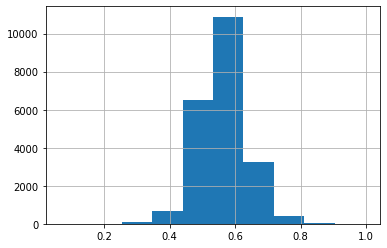

In [4]:
train_dataset[train_dataset['PeriodLS']<1][train_dataset.label=='ClassA']['PeriodLS'].hist()

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

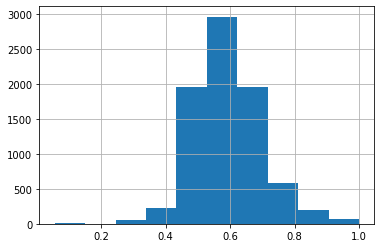

In [5]:
test_dataset[test_dataset['PeriodLS']<1][test_dataset.label=='ClassA']['PeriodLS'].hist()

<AxesSubplot:>

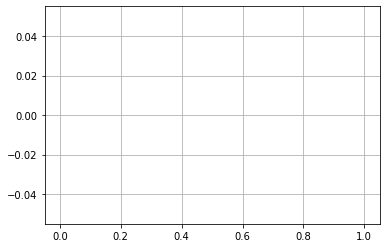

In [6]:
train_dataset[train_dataset.label==1]['Amplitude'].hist()

<AxesSubplot:>

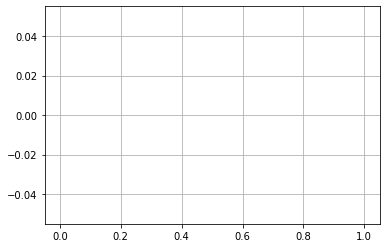

In [7]:
test_dataset[test_dataset.label==1]['Amplitude'].hist()

1.0


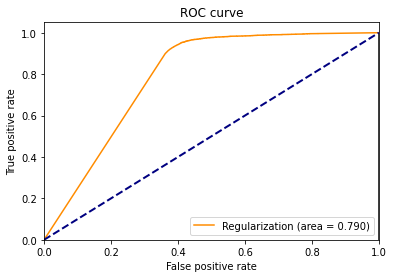

0.7901829636497946

In [8]:
nn.get_roc_curve(net, test_loader, input_size, title="Regularization")

In [9]:
torch.save(net.state_dict(), 'model.pkl')

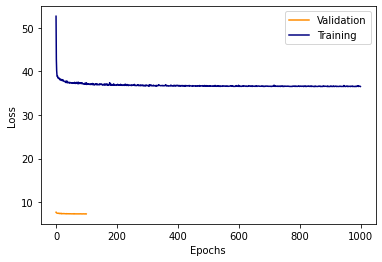

In [10]:
ut.plot_training(hist_val, hist_train)

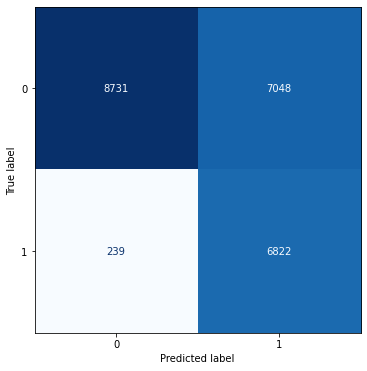

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
curves, labels, probs_test = ut.get_predictions(net, test_loader_pred, device)
pred_labels = probs_test.argmax(1, keepdim = True)
ut.plot_confusion_matrix(np.round(labels), pred_labels, ax)

In [12]:
#csv_file = open("size_MLP_noise.csv", "a")
#csv_file.write(str(np.asarray(acc_testing))+","+str(np.asarray(acc_training))+","+str(samples)+","+str(epsilon)+","+str(n)+","+str(hidden_size)+"\n")
#csv_file.close()

In [13]:
outputs, intermediates, intermediates2, labels = ut.get_representations(net, train_loader, device)
outputs_test, intermediates_test, intermediates2_test, labels_test = ut.get_representations(net, test_loader, device)

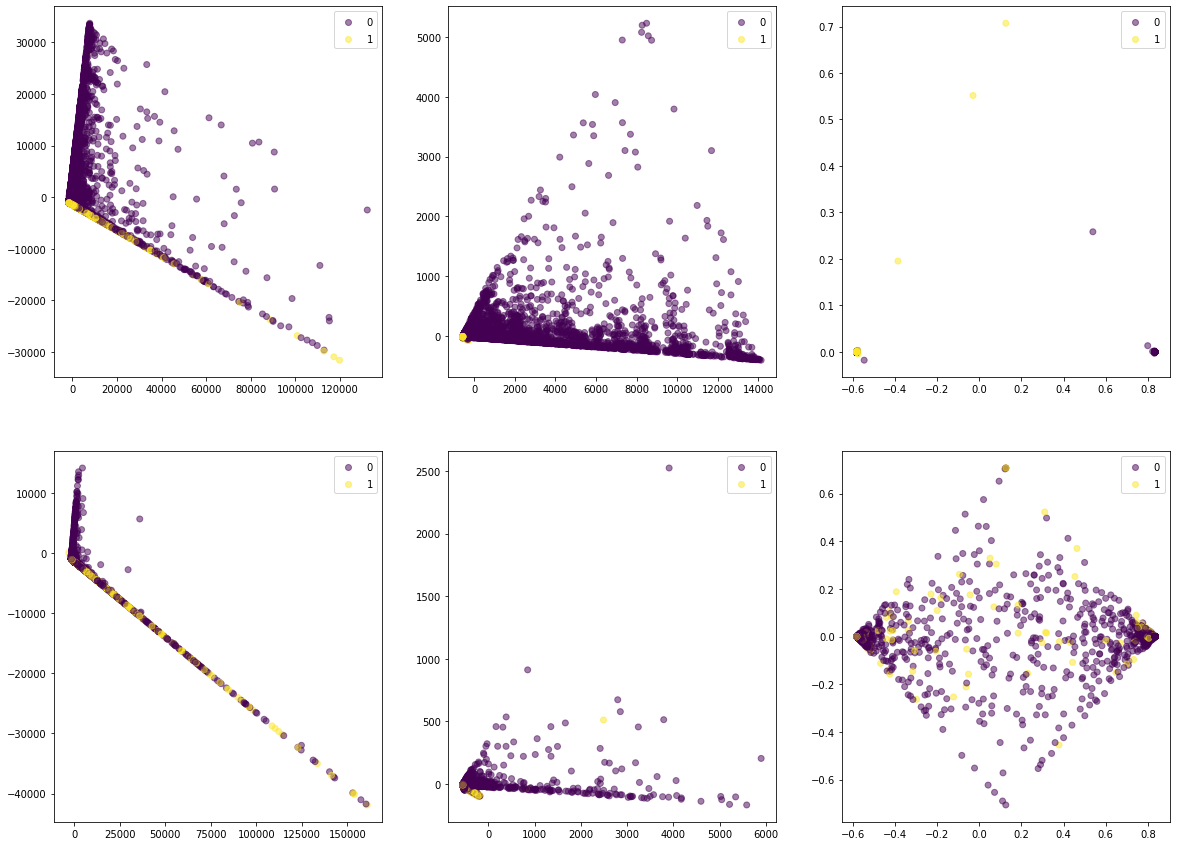

In [14]:
intermediate_pca_data, intermediate_pca_data_test = ut.get_pca(intermediates, data_test=intermediates_test)
fig, axs = plt.subplots(2, 3, figsize=(20,15))
ut.plot_representations(intermediate_pca_data, labels, axs[0, 0])
ut.plot_representations(intermediate_pca_data_test, labels_test, axs[1, 0])
intermediate2_pca_data, intermediate2_pca_data_test = ut.get_pca(intermediates2, data_test=intermediates2_test)
ut.plot_representations(intermediate2_pca_data, labels, axs[0, 1])
ut.plot_representations(intermediate2_pca_data_test, labels_test, axs[1, 1])
output_pca_data, output_pca_data_test = ut.get_pca(outputs, data_test=outputs_test)
ut.plot_representations(output_pca_data, labels, axs[0, 2])
ut.plot_representations(output_pca_data_test, labels_test, axs[1, 2])

first
first ..
first ...


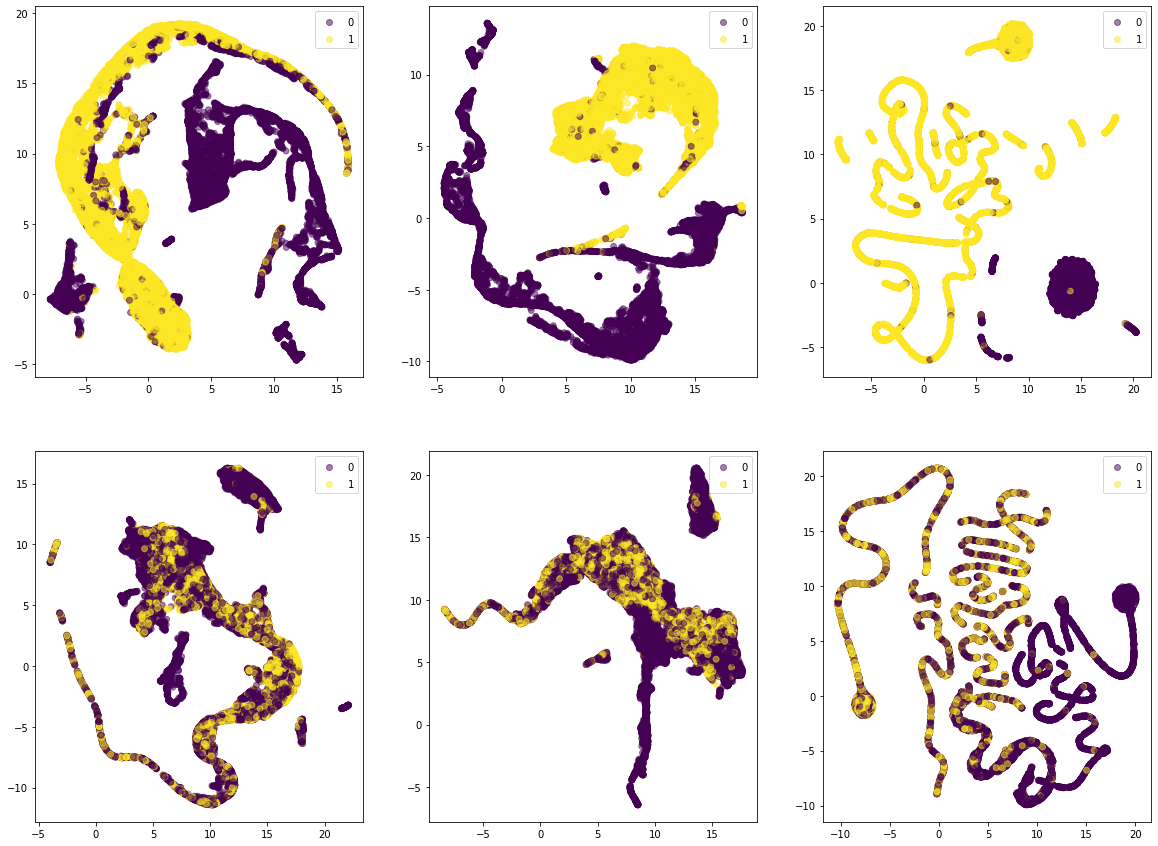

In [15]:
import umap

fig, axs = plt.subplots(2, 3, figsize=(20,15))
print('first')
reducer = umap.UMAP()
print('first ..')
mapper_train = reducer.fit_transform(intermediates.numpy())
print('first ...')
reducer = umap.UMAP()
mapper_test = reducer.fit_transform(intermediates_test.numpy())
ut.plot_representations(mapper_train, labels, axs[0, 0])
ut.plot_representations(mapper_test, labels_test, axs[1, 0])

reducer = umap.UMAP()
mapper_train = reducer.fit_transform(intermediates2.numpy())
reducer = umap.UMAP()
mapper_test = reducer.fit_transform(intermediates2_test.numpy())
ut.plot_representations(mapper_train, labels, axs[0, 1])
ut.plot_representations(mapper_test, labels_test, axs[1, 1])

reducer = umap.UMAP()
mapper_train = reducer.fit_transform(outputs.numpy())
reducer = umap.UMAP()
mapper_test = reducer.fit_transform(outputs_test.numpy())

ut.plot_representations(mapper_train, labels, axs[0, 2])
ut.plot_representations(mapper_test, labels_test, axs[1, 2])

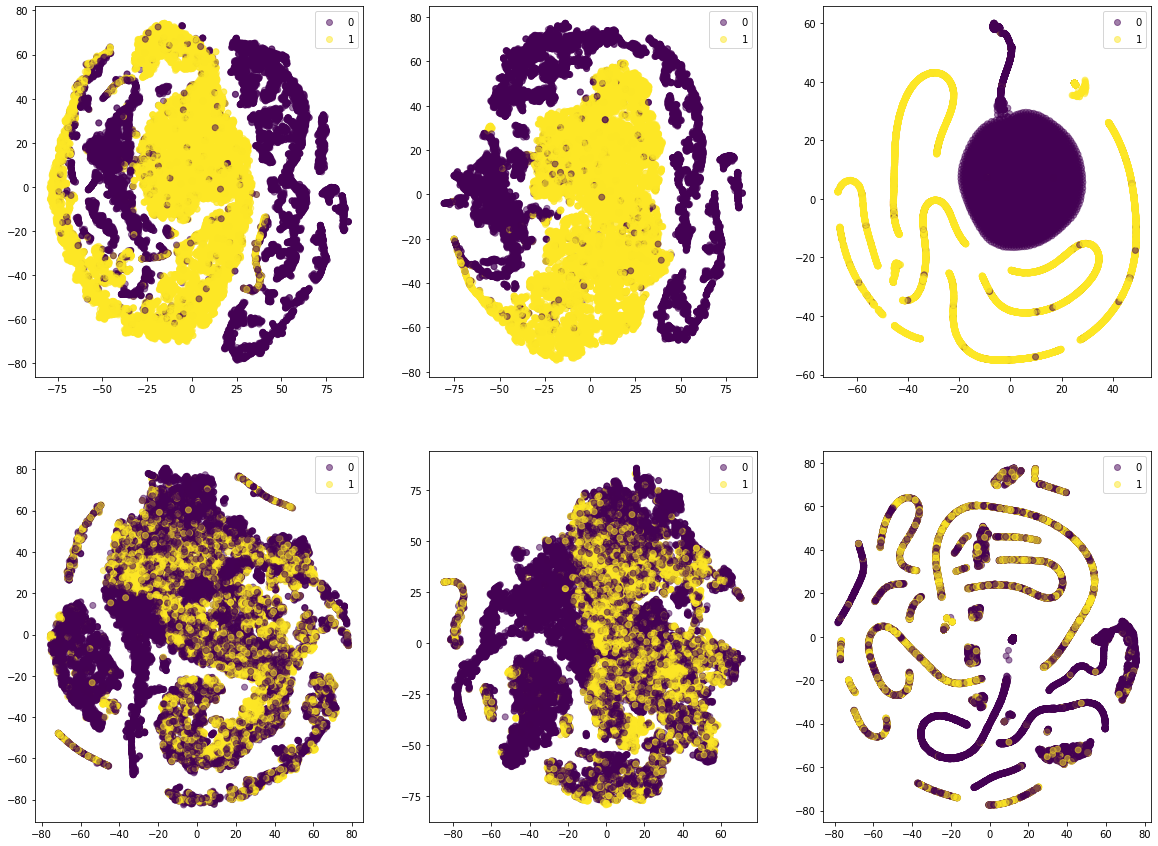

In [16]:
N_CURVES = 25000

fig, axs = plt.subplots(2, 3, figsize=(20,15))
intermediate_tsne_data, intermediate_tsne_data_test = ut.get_tsne(intermediates, data_test= intermediates_test, n_curves = N_CURVES)
ut.plot_representations(intermediate_tsne_data, labels, axs[0, 0],  n_curves = N_CURVES)
ut.plot_representations(intermediate_tsne_data_test, labels_test, axs[1, 0], n_curves = N_CURVES)

intermediate2_tsne_data, intermediate2_tsne_data_test = ut.get_tsne(intermediates2, data_test=intermediates2_test, n_curves = N_CURVES)
ut.plot_representations(intermediate2_tsne_data, labels, axs[0, 1], n_curves = N_CURVES)
ut.plot_representations(intermediate2_tsne_data_test, labels_test, axs[1, 1], n_curves = N_CURVES)

output_tsne_data, output2_tsne_data_test = ut.get_tsne(outputs, data_test=outputs_test, n_curves = N_CURVES)
ut.plot_representations(output_tsne_data, labels, axs[0, 2], n_curves = N_CURVES)
ut.plot_representations(output2_tsne_data_test, labels_test, axs[1, 2], n_curves = N_CURVES)

In [17]:
#fig, ax = plt.subplots(1, 1, figsize=(15,15))
#curves, labels, probs_train = ut.get_predictions(net, train_loader_pred, device)
#pred_labels = probs_train.argmax(1, keepdim = True)
#ut.plot_confusion_matrix(np.round(labels), pred_labels, ax)


In [18]:
pred_labels

tensor([[0],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]])

In [19]:
curves, labels, probs_train_sample = ut.get_predictions(net, train_loader, device)

In [20]:
#N_WEIGHTS = 25
#weights = net.fc2.weight.data
#plot_weights(weights, N_WEIGHTS)

In [21]:
weights1 = net.fc1.weight.data
w1 = weights1.cpu().numpy().reshape(-1,1)
weights2 = net.fc2.weight.data
w2 = weights2.cpu().numpy().reshape(-1,1)
weights3 = net.fc3.weight.data
w3 = weights3.cpu().numpy().reshape(-1,1)

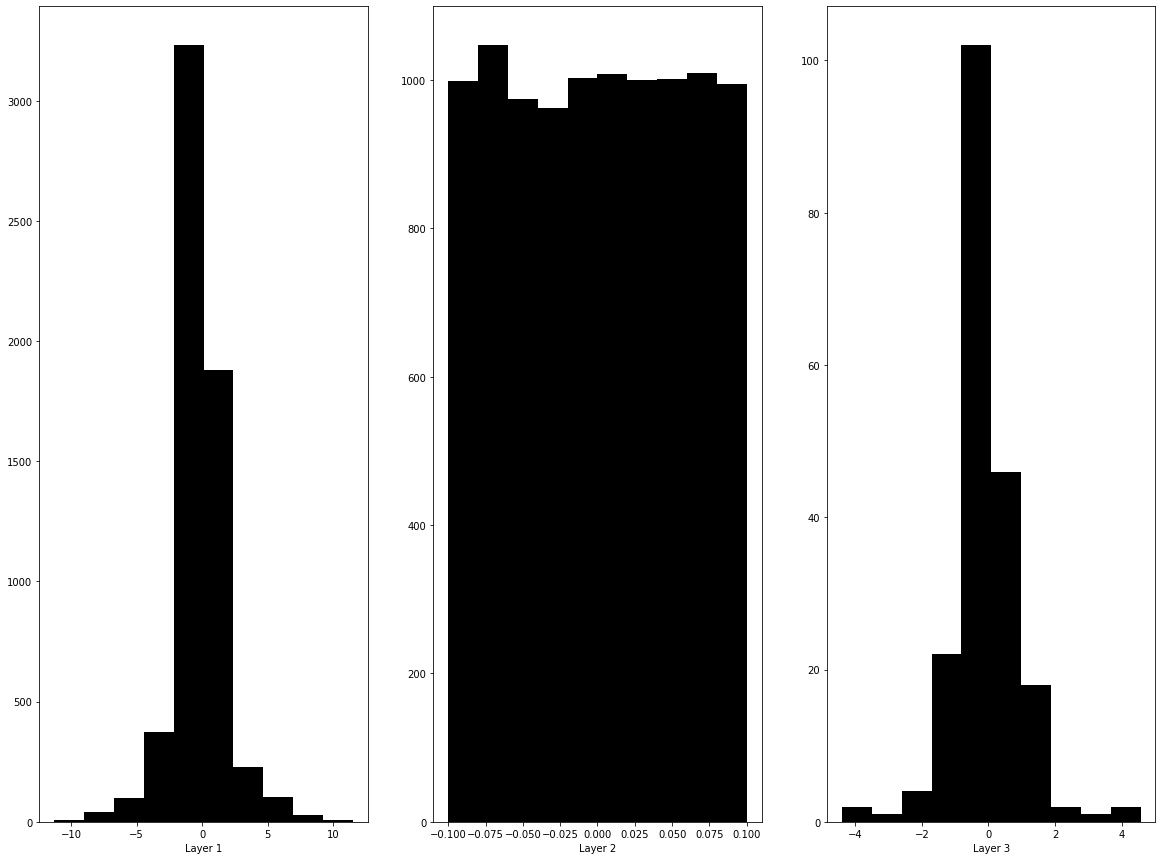

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,15))
ax1.hist(w1, color='black')
ax1.set_xlabel('Layer 1')
ax2.hist(w2, color='black')
ax2.set_xlabel('Layer 2')
ax3.hist(w3, color='black')
ax3.set_xlabel('Layer 3')
plt.show()

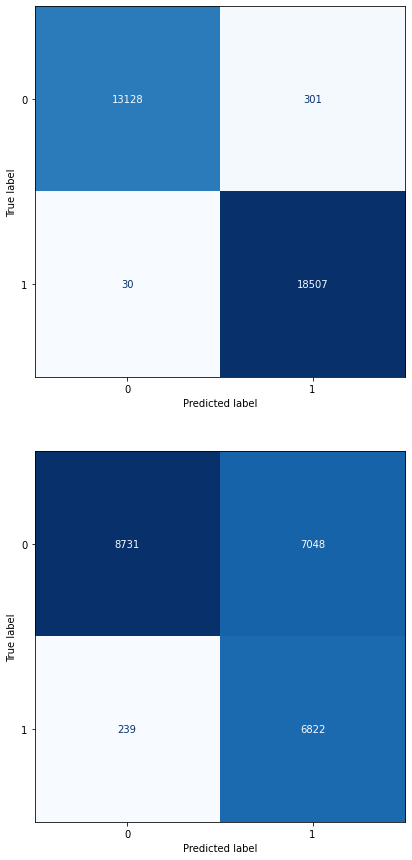

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
curves, labels, probs_train = ut.get_predictions(net, train_loader_pred, device)
pred_labels = torch.argmax(probs_train, 1)
ut.plot_confusion_matrix(np.round(labels), pred_labels, ax1)
curves, labels, probs_test = ut.get_predictions(net, test_loader_pred, device)
pred_labels = torch.argmax(probs_test, 1)
ut.plot_confusion_matrix(np.round(labels), pred_labels, ax2)